In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [84]:
# Read Excel file (.xlsx)
df = pd.read_excel("FYP Dataset/Influenza Malaysia.xlsx")

# Save as CSV (for faster ML processing)
df.to_csv("FYP Dataset/Influenza Malaysia.csv")  # Omit `index=False` if you want to keep the index

# Display the first 5 rows
df.head()

WHO region              ITZ COUNTRY/AREA/TERRITORY COUNTRY_CODE  \
0        WPR  South-East Asia               Malaysia          MYS   
1        WPR  South-East Asia               Malaysia          MYS   
2        WPR  South-East Asia               Malaysia          MYS   
3        WPR  South-East Asia               Malaysia          MYS   
4        WPR  South-East Asia               Malaysia          MYS   

  ORIGIN_SOURCE  ISO_YEAR  ISO_WEEK                 ISO_SDATE  \
0   NONSENTINEL      2019        44  2019-10-27T16:00:00.000Z   
1   NONSENTINEL      2020         1  2019-12-29T16:00:00.000Z   
2   NONSENTINEL      2020         2  2020-01-05T16:00:00.000Z   
3   NONSENTINEL      2020         3  2020-01-12T16:00:00.000Z   
4   NONSENTINEL      2020         4  2020-01-19T16:00:00.000Z   

   SPEC_RECEIVED_NB  SPEC_PROCESSED_NB  ...  AH5  ANOTSUBTYPED  INF_A  BVIC  \
0              27.0                 27  ...  NaN           1.0    1.0   NaN   
1              45.0                 45  ...  NaN           5.0    5.0   NaN   
2              55.0                 55  ...  NaN          11.0   11.0   NaN   
3              56.0                 56  ...  NaN          12.0   12.0   NaN   
4              66.0                 66  ...  NaN           9.0    9.0   NaN   

   BYAM  BNOTDETERMINED  INF_B  INF_ALL  INF_NEGATIVE  ILI_ACTIVITY  
0   NaN             NaN    NaN      1.0          26.0             1  
1   NaN             NaN    NaN      5.0          40.0             1  
2   NaN             2.0    2.0     13.0          42.0             1  
3   NaN             1.0    1.0     13.0          43.0             1  
4   NaN             NaN    NaN      9.0          57.0             1  

[5 rows x 23 columns]

In [85]:
df.columns

Index(['WHO region', 'ITZ', 'COUNTRY/AREA/TERRITORY', 'COUNTRY_CODE',
       'ORIGIN_SOURCE', 'ISO_YEAR', 'ISO_WEEK', 'ISO_SDATE',
       'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'AH1', 'AH1N12009', 'AH3',
       'AH5', 'ANOTSUBTYPED', 'INF_A', 'BVIC', 'BYAM', 'BNOTDETERMINED',
       'INF_B', 'INF_ALL', 'INF_NEGATIVE', 'ILI_ACTIVITY'],
      dtype='object')

In [86]:
df.drop(['WHO region', 'ITZ', 'COUNTRY/AREA/TERRITORY', 'COUNTRY_CODE',
       'ORIGIN_SOURCE', 'ISO_YEAR', 'ISO_WEEK',
       'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'BVIC', 'BYAM', 'BNOTDETERMINED',
       'INF_B', 'INF_ALL', 'INF_NEGATIVE', 'ILI_ACTIVITY'], axis=1, inplace=True)

In [90]:
df.head()

ISO_SDATE  AH1  AH1N12009  AH3  AH5  ANOTSUBTYPED  INF_A
0  2019-10-27T16:00:00.000Z  NaN        NaN  NaN  NaN           1.0    1.0
1  2019-12-29T16:00:00.000Z  NaN        NaN  NaN  NaN           5.0    5.0
2  2020-01-05T16:00:00.000Z  NaN        NaN  NaN  NaN          11.0   11.0
3  2020-01-12T16:00:00.000Z  NaN        NaN  NaN  NaN          12.0   12.0
4  2020-01-19T16:00:00.000Z  NaN        NaN  NaN  NaN           9.0    9.0

In [92]:
df.dtypes

ISO_SDATE        object
AH1             float64
AH1N12009       float64
AH3             float64
AH5             float64
ANOTSUBTYPED    float64
INF_A           float64
dtype: object

In [94]:
# Replace NaN with 0 in the entire DataFrame
df = df.fillna(0)

In [96]:
# Convert 'ISO_SDATE' to datetime, remove the timezone but keep the time
df['Datetime'] = pd.to_datetime(df['ISO_SDATE']).dt.tz_localize(None)

In [98]:
df.set_index('Datetime', inplace=True)

# Add the values of AH1, AH1N12009, AH3, AH5, ANOTSUBTYPED and store in 'SUM_INF_A'
df['SUM_INF_A'] = df['AH1'] + df['AH1N12009'] + df['AH3'] + df['AH5'] + df['ANOTSUBTYPED']

# Sort the DataFrame by 'Datetime'
df = df.sort_values(by='Datetime')

# Display the updated DataFrame
df.head()

ISO_SDATE  AH1  AH1N12009  AH3  AH5  \
Datetime                                                                  
1996-12-22 16:00:00  1996-12-22T16:00:00.000Z  0.0        0.0  0.0  0.0   
1996-12-29 16:00:00  1996-12-29T16:00:00.000Z  0.0        0.0  0.0  0.0   
1997-01-05 16:00:00  1997-01-05T16:00:00.000Z  0.0        0.0  2.0  0.0   
1997-01-26 16:00:00  1997-01-26T16:00:00.000Z  0.0        0.0  0.0  0.0   
1997-02-02 16:00:00  1997-02-02T16:00:00.000Z  0.0        0.0  0.0  0.0   

                     ANOTSUBTYPED  INF_A  SUM_INF_A  
Datetime                                             
1996-12-22 16:00:00           0.0    0.0        0.0  
1996-12-29 16:00:00           0.0    0.0        0.0  
1997-01-05 16:00:00           1.0    3.0        3.0  
1997-01-26 16:00:00           0.0    0.0        0.0  
1997-02-02 16:00:00           0.0    0.0        0.0

In [100]:
duplicate_dates = df[df.index.duplicated(keep=False)]
print(duplicate_dates)

                                    ISO_SDATE  AH1  AH1N12009   AH3  AH5  \
Datetime                                                                   
2019-10-27 16:00:00  2019-10-27T16:00:00.000Z  0.0       11.0   2.0  0.0   
2019-10-27 16:00:00  2019-10-27T16:00:00.000Z  0.0        0.0   0.0  0.0   
2019-12-29 16:00:00  2019-12-29T16:00:00.000Z  0.0        0.0   0.0  0.0   
2019-12-29 16:00:00  2019-12-29T16:00:00.000Z  0.0       22.0   1.0  0.0   
2020-01-05 16:00:00  2020-01-05T16:00:00.000Z  0.0        0.0   0.0  0.0   
...                                       ...  ...        ...   ...  ...   
2024-08-04 16:00:00  2024-08-04T16:00:00.000Z  0.0       59.0  72.0  0.0   
2024-08-11 16:00:00  2024-08-11T16:00:00.000Z  0.0       37.0  72.0  0.0   
2024-08-11 16:00:00  2024-08-11T16:00:00.000Z  0.0        0.0   4.0  0.0   
2024-08-18 16:00:00  2024-08-18T16:00:00.000Z  0.0       43.0  72.0  0.0   
2024-08-18 16:00:00  2024-08-18T16:00:00.000Z  0.0        2.0   3.0  0.0   

           

In [102]:
print(df['SUM_INF_A'].sum())           # Total before aggregation
summed_df = df.groupby(df.index).sum()
print(summed_df['SUM_INF_A'].sum())    # Total after aggregation

19337.0
19337.0


In [108]:
summed_df.columns

Index(['ISO_SDATE', 'AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A',
       'SUM_INF_A'],
      dtype='object')

In [110]:
summed_df.shape

(1433, 8)

In [114]:
summed_df.drop(['ISO_SDATE', 'INF_A'], axis=1, inplace=True)

In [116]:
summed_df.head()

AH1  AH1N12009  AH3  AH5  ANOTSUBTYPED  SUM_INF_A
Datetime                                                              
1996-12-22 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1996-12-29 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1997-01-05 16:00:00  0.0        0.0  2.0  0.0           1.0        3.0
1997-01-26 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1997-02-02 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0

In [118]:
# Reorder columns manually
summed_df = summed_df[['AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'SUM_INF_A']]  # Specify the new column order

summed_df.head()

AH1  AH1N12009  AH3  AH5  ANOTSUBTYPED  SUM_INF_A
Datetime                                                              
1996-12-22 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1996-12-29 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1997-01-05 16:00:00  0.0        0.0  2.0  0.0           1.0        3.0
1997-01-26 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0
1997-02-02 16:00:00  0.0        0.0  0.0  0.0           0.0        0.0

In [120]:
# df.dtypes
summed_df.tail()

AH1  AH1N12009   AH3  AH5  ANOTSUBTYPED  SUM_INF_A
Datetime                                                               
2025-04-13 16:00:00  0.0       39.0  15.0  0.0           0.0       54.0
2025-04-20 16:00:00  0.0       34.0  17.0  0.0           1.0       52.0
2025-04-27 16:00:00  0.0       49.0  16.0  0.0           0.0       65.0
2025-05-04 16:00:00  0.0       40.0  32.0  0.0           0.0       72.0
2025-05-11 16:00:00  0.0       54.0  26.0  0.0           0.0       80.0

In [122]:
summed_df.dtypes

AH1             float64
AH1N12009       float64
AH3             float64
AH5             float64
ANOTSUBTYPED    float64
SUM_INF_A       float64
dtype: object

In [124]:
summed_df.drop(['AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED'], axis=1, inplace=True)

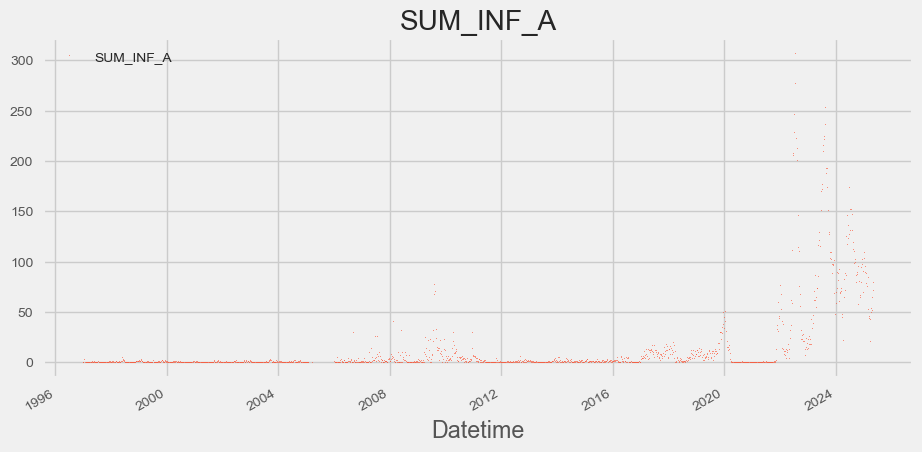

In [126]:
# Create a copy of the DataFrame
df_copy = summed_df.copy()

# Plot 'SUM_INF_A' column
color_pal = sns.color_palette()

# Plot the 'SUM_INF_A' column using the index as x
df_copy.plot(y='SUM_INF_A', style='.', figsize=(10, 5), ms=1, color=color_pal[1], title='SUM_INF_A')

# Show the plot
plt.show()

In [128]:
summed_df.columns

Index(['SUM_INF_A'], dtype='object')

In [130]:
# Find out the average month (highest)
summed_df.resample('M').mean()['SUM_INF_A'].idxmax()

Timestamp('2022-07-31 00:00:00')

In [132]:
# Find out the average week (highest)
summed_df.resample('W').mean()['SUM_INF_A'].idxmax()

Timestamp('2022-07-17 00:00:00')

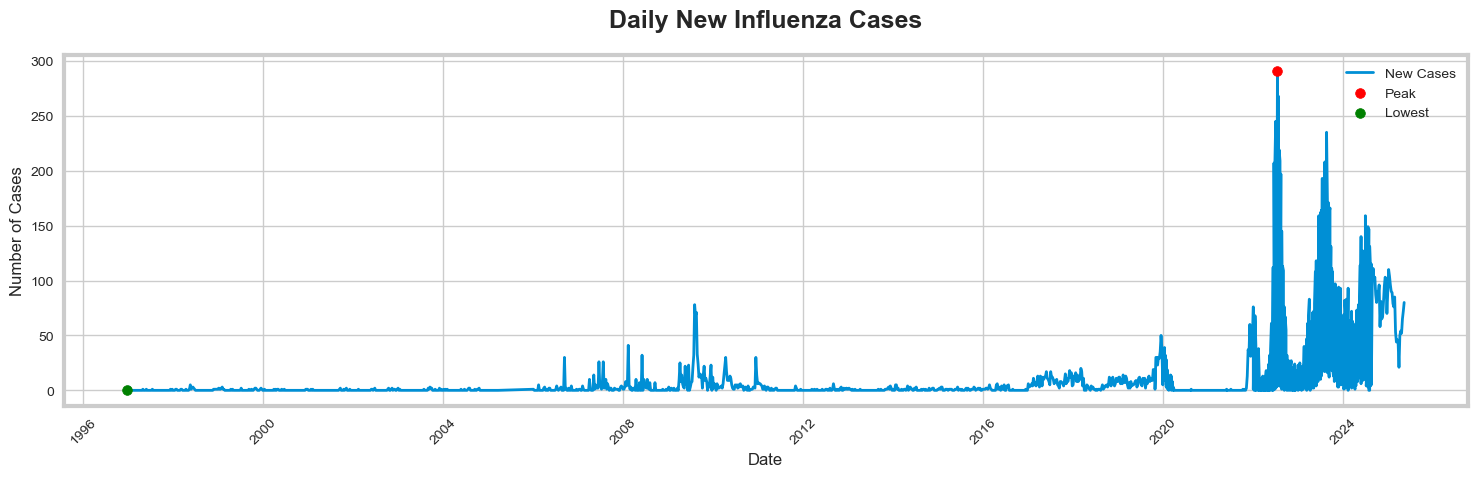

In [136]:
# Set a modern style
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df['SUM_INF_A'], color=color_pal[0], linewidth=2, label='New Cases')

# Highlight max and min values (optional)
plt.scatter(df['SUM_INF_A'].idxmax(), df['SUM_INF_A'].max(), color='red', label='Peak', zorder=5)
plt.scatter(df['SUM_INF_A'].idxmin(), df['SUM_INF_A'].min(), color='green', label='Lowest', zorder=5)

# Add title and labels
plt.title('Daily New Influenza Cases', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)

# Customize ticks
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend()

# Show plot
plt.show()

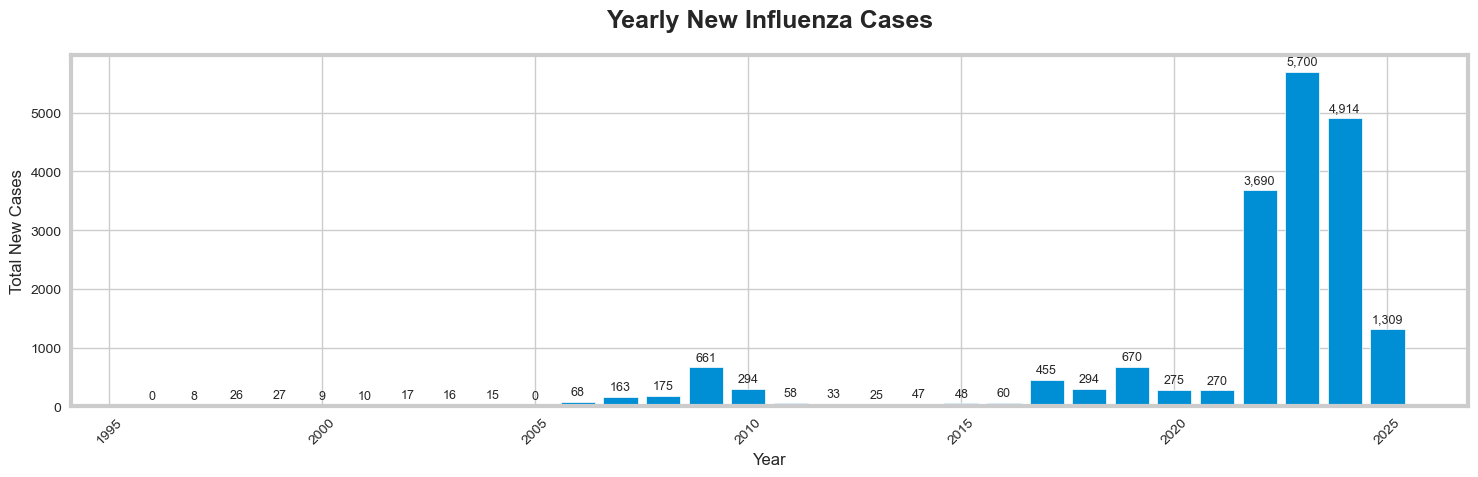

In [138]:
# Set style
sns.set_style("whitegrid")

# Resample and aggregate
yearly_cases = df['SUM_INF_A'].resample('Y').sum()

# Convert index to year for clearer x-axis labels
yearly_cases.index = yearly_cases.index.year

# Plot
plt.figure(figsize=(15, 5))
bars = plt.bar(yearly_cases.index, yearly_cases, color=color_pal[0])

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', fontsize=9)

# Title and labels
plt.title('Yearly New Influenza Cases', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total New Cases', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Engineered features (without prediction range)

14:34:19 - cmdstanpy - INFO - Chain [1] start processing
14:34:23 - cmdstanpy - INFO - Chain [1] done processing



Prophet Evaluation:
  MAE: 5.28
  MSE: 55.14
  RMSE: 7.43
  MAPE: 18.26%
  SMAPE: 15.54%
  R2: 0.98
Prophet - Train MAE: 0.62, Test MAE: 5.28
Prophet - Train RMSE: 1.34, Test RMSE: 7.43


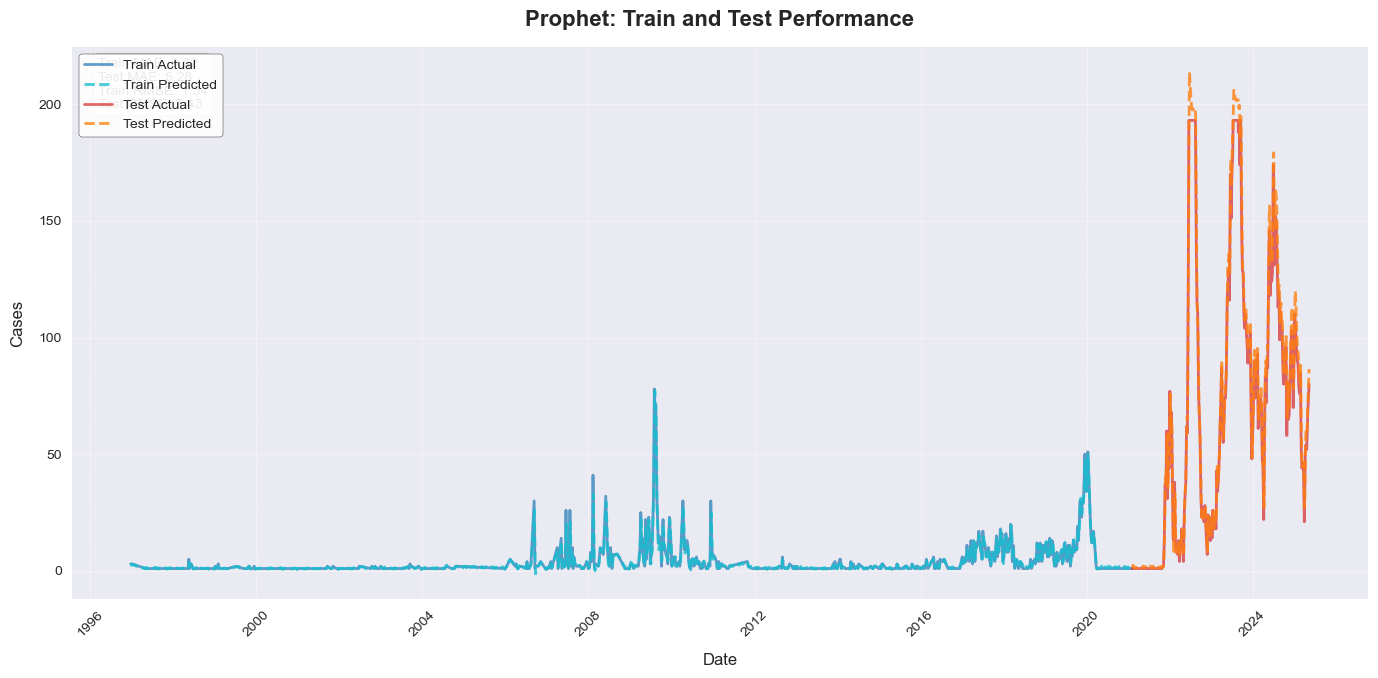

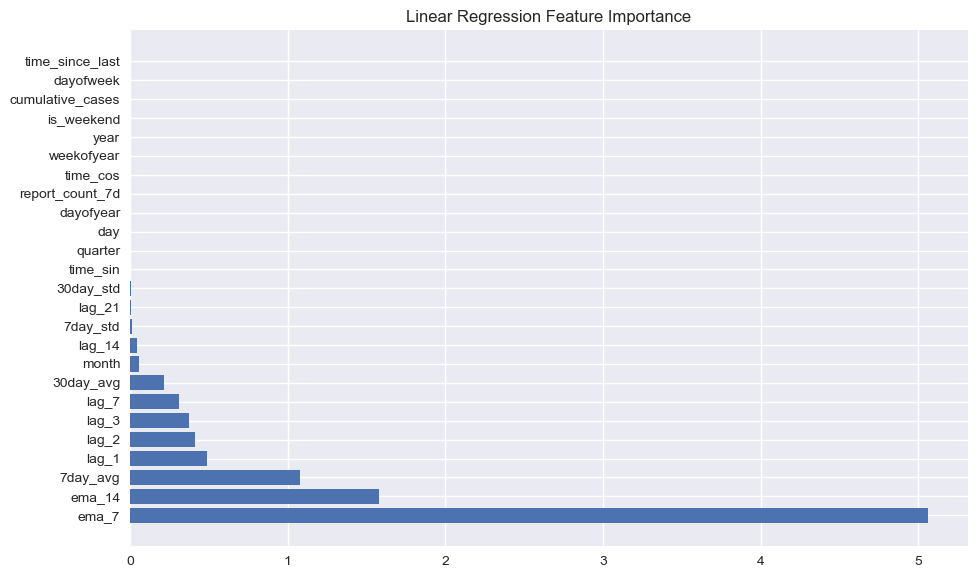


Linear Regression Evaluation:
  MAE: 0.33
  MSE: 0.22
  RMSE: 0.47
  MAPE: 0.80%
  SMAPE: 0.81%
  R2: 1.00
Linear Regression - Train MAE: 0.04, Test MAE: 0.33
Linear Regression - Train RMSE: 0.09, Test RMSE: 0.47


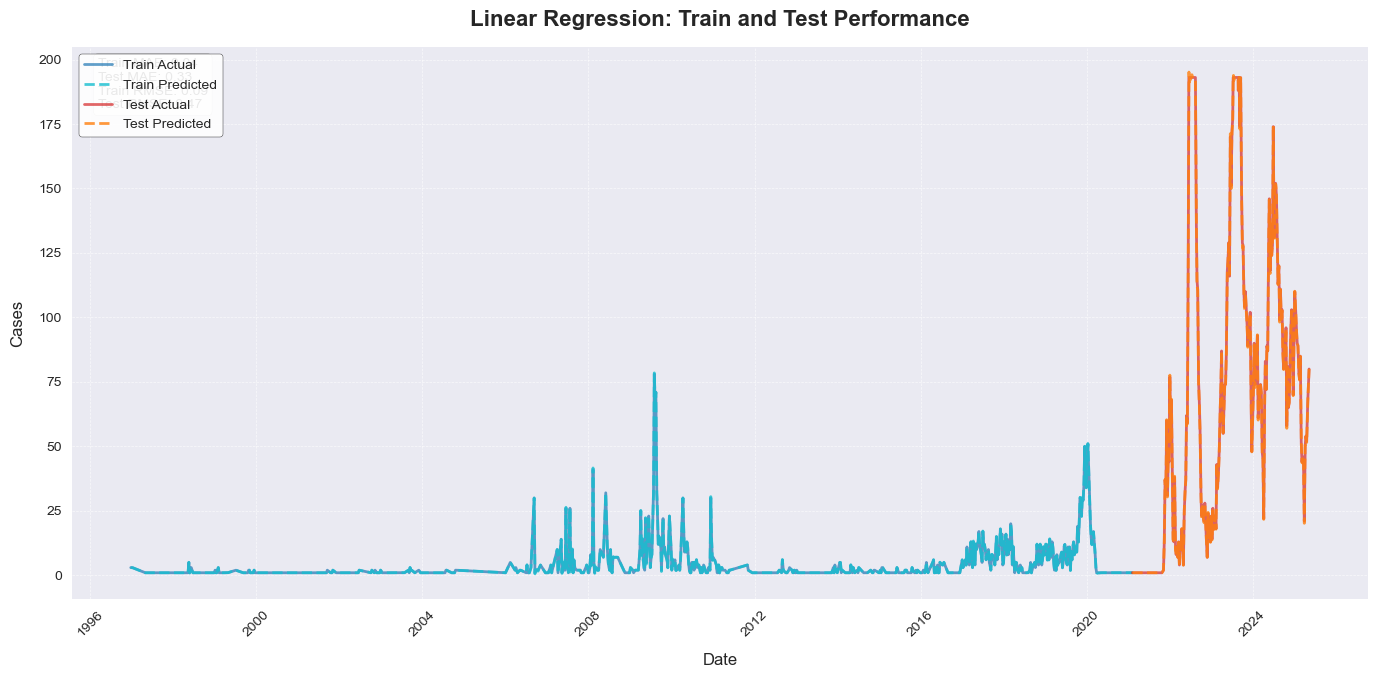

Running ACO for feature selection...
Iteration 0, Best MAE: 0.06
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05


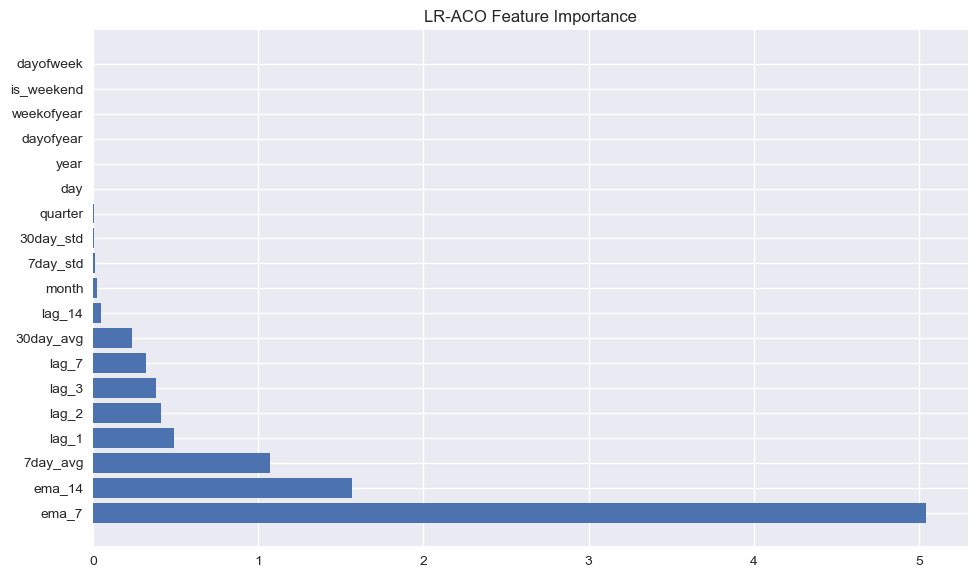


LR-ACO Evaluation:
  MAE: 0.33
  MSE: 0.21
  RMSE: 0.46
  MAPE: 1.01%
  SMAPE: 1.01%
  R2: 1.00
LR-ACO - Train MAE: 0.04, Test MAE: 0.33
LR-ACO - Train RMSE: 0.09, Test RMSE: 0.46


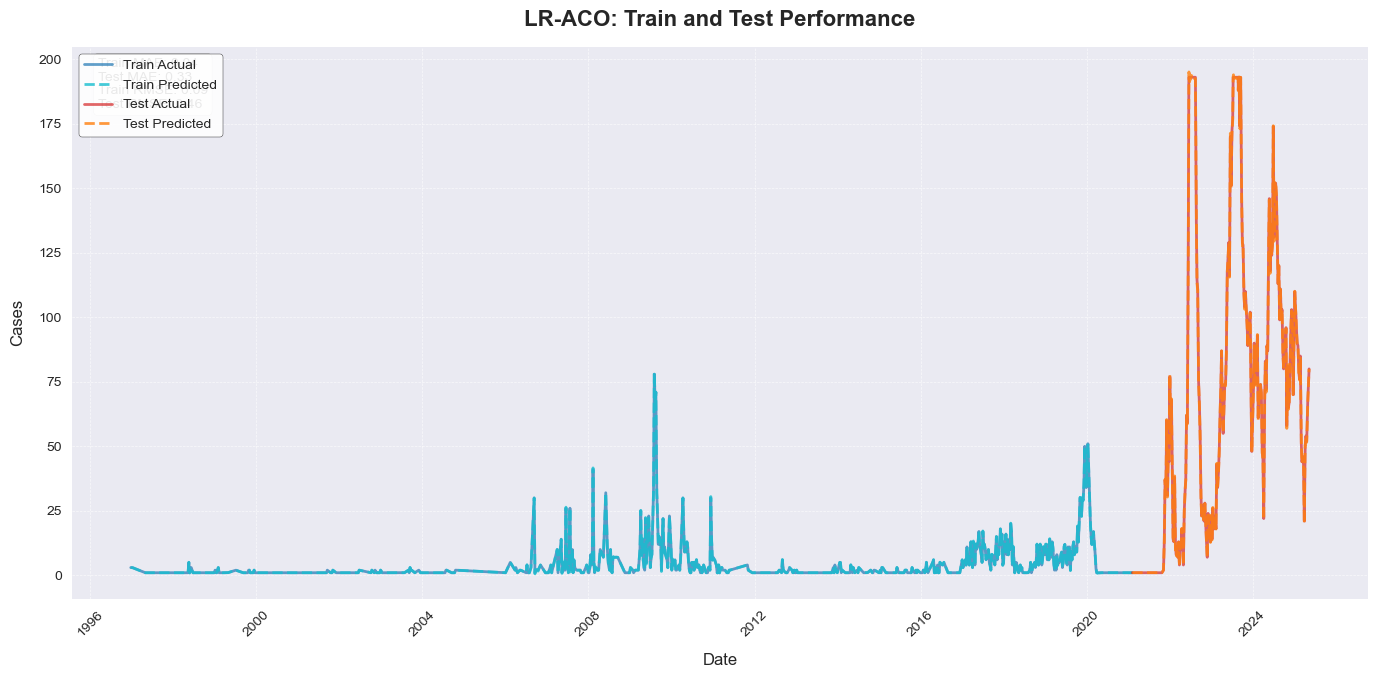

Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.10
Iteration 10, Best MAE: 0.08
Iteration 20, Best MAE: 0.08
Iteration 30, Best MAE: 0.08
Iteration 40, Best MAE: 0.08


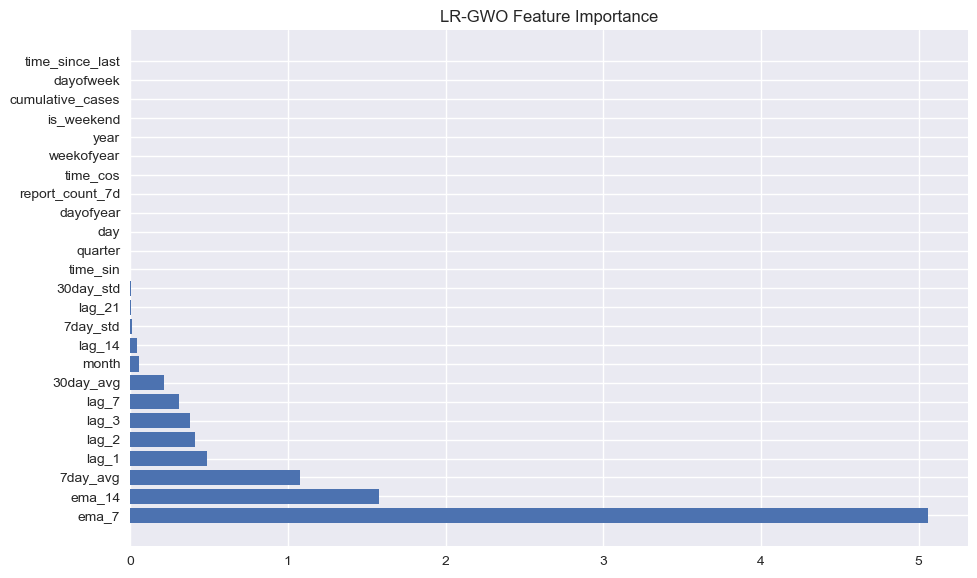


LR-GWO Evaluation:
  MAE: 0.33
  MSE: 0.22
  RMSE: 0.47
  MAPE: 0.80%
  SMAPE: 0.81%
  R2: 1.00
LR-GWO - Train MAE: 0.04, Test MAE: 0.33
LR-GWO - Train RMSE: 0.09, Test RMSE: 0.47


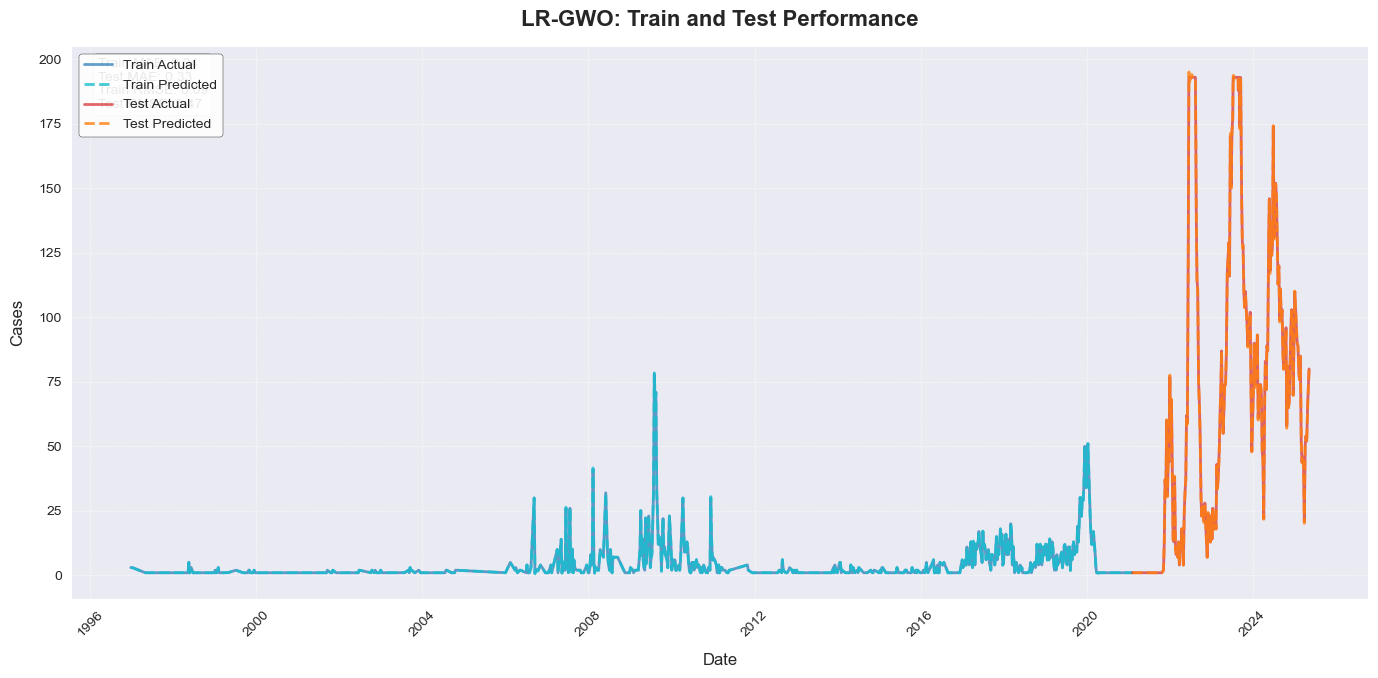

Running ACO for feature selection...
Iteration 0, Best MAE: 0.06
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.07
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05


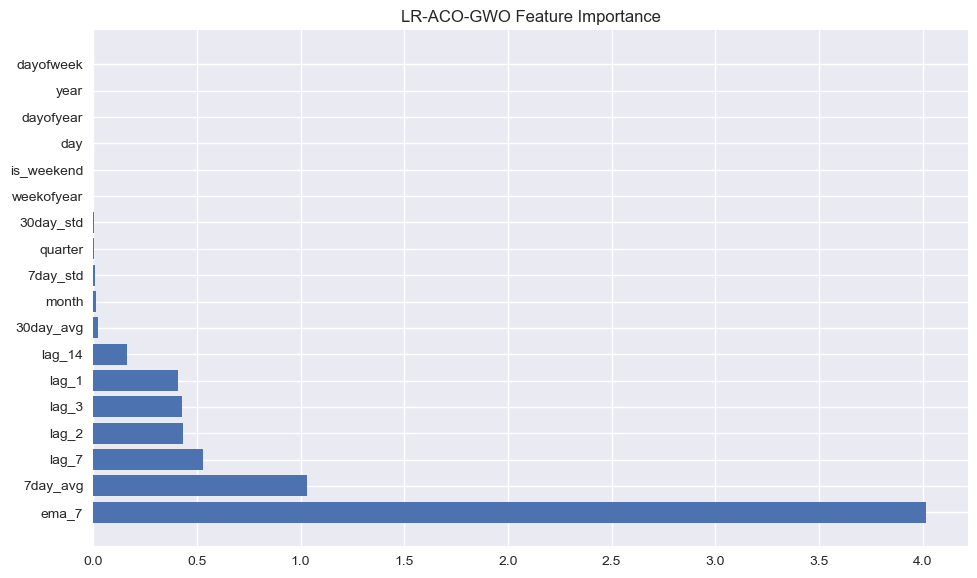


LR-ACO-GWO Evaluation:
  MAE: 0.32
  MSE: 0.24
  RMSE: 0.49
  MAPE: 0.73%
  SMAPE: 0.73%
  R2: 1.00
LR-ACO-GWO - Train MAE: 0.04, Test MAE: 0.32
LR-ACO-GWO - Train RMSE: 0.11, Test RMSE: 0.49


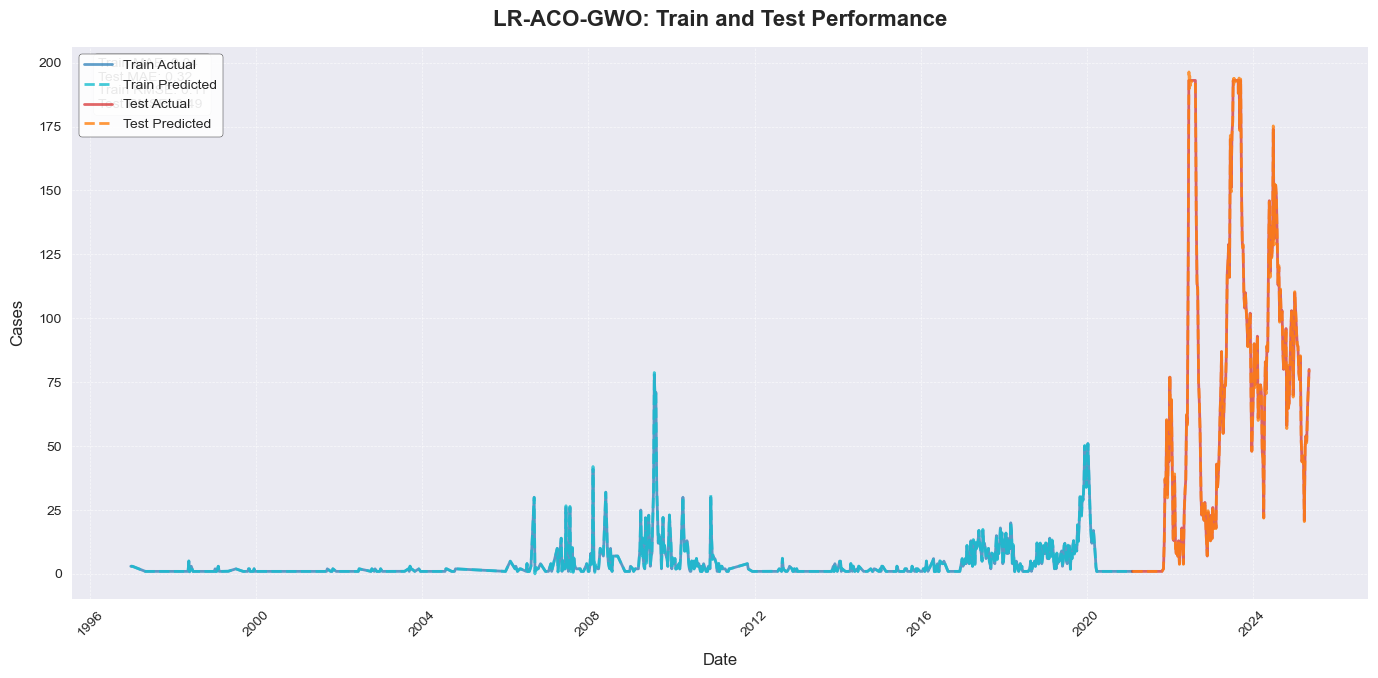


LR Bagging Ensemble Evaluation:
  MAE: 0.40
  MSE: 0.38
  RMSE: 0.61
  MAPE: 1.00%
  SMAPE: 1.00%
  R2: 1.00
LR Bagging Ensemble - Train MAE: 0.05, Test MAE: 0.40
LR Bagging Ensemble - Train RMSE: 0.13, Test RMSE: 0.61


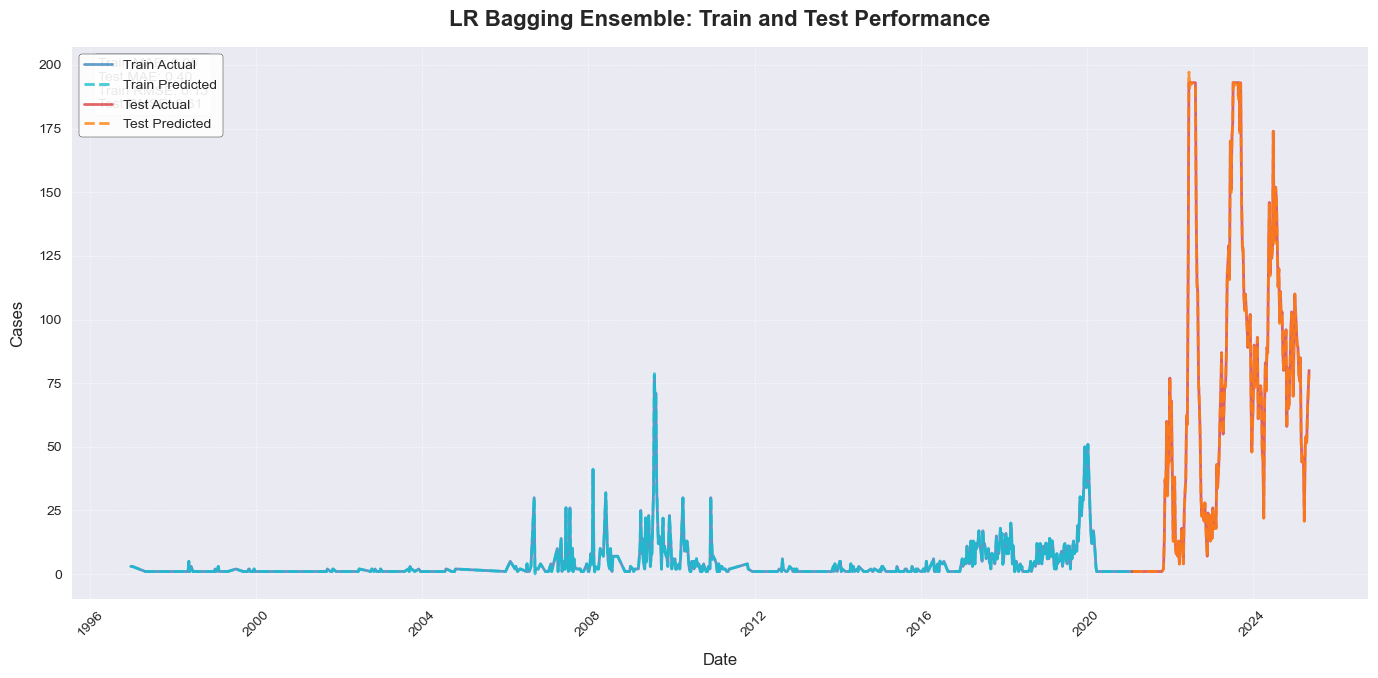

Running ACO for feature selection...
Iteration 0, Best MAE: 0.06
Iteration 10, Best MAE: 0.06
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Selected features by ACO: ['year', 'dayofweek', 'month', 'day', 'dayofyear', 'weekofyear', '7day_std', 'quarter', 'is_weekend', '30day_std', 'lag_7', 'lag_1', '7day_avg', 'lag_2', '30day_avg', 'lag_3', 'lag_14', 'ema_14', 'ema_7']
Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.05
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Optimized hyperparameters: {'n_estimators': 144.12488220395656, 'max_samples': 0.5}


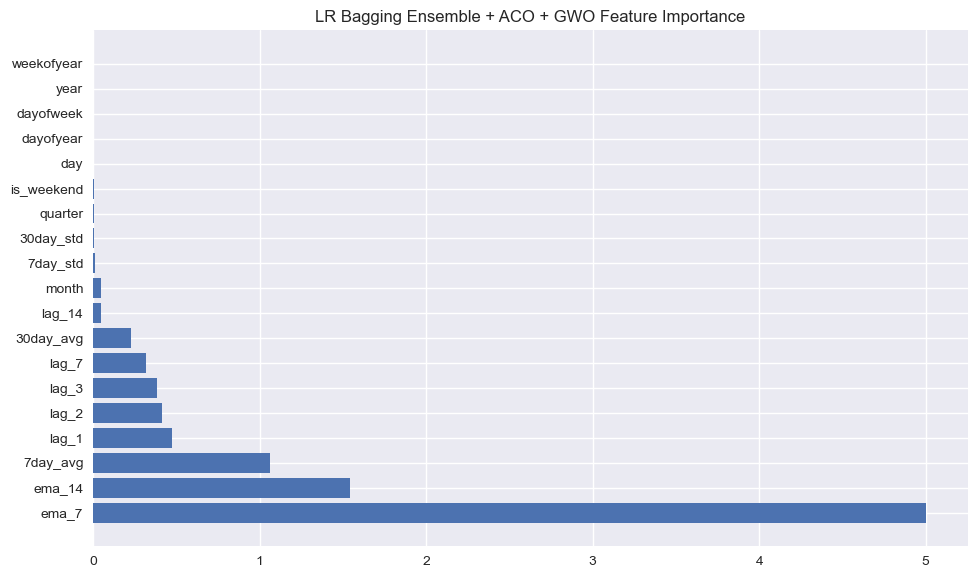


LR Bagging Ensemble + ACO + GWO Evaluation:
  MAE: 0.33
  MSE: 0.21
  RMSE: 0.46
  MAPE: 0.99%
  SMAPE: 0.99%
  R2: 1.00
LR Bagging Ensemble + ACO + GWO - Train MAE: 0.04, Test MAE: 0.33
LR Bagging Ensemble + ACO + GWO - Train RMSE: 0.09, Test RMSE: 0.46


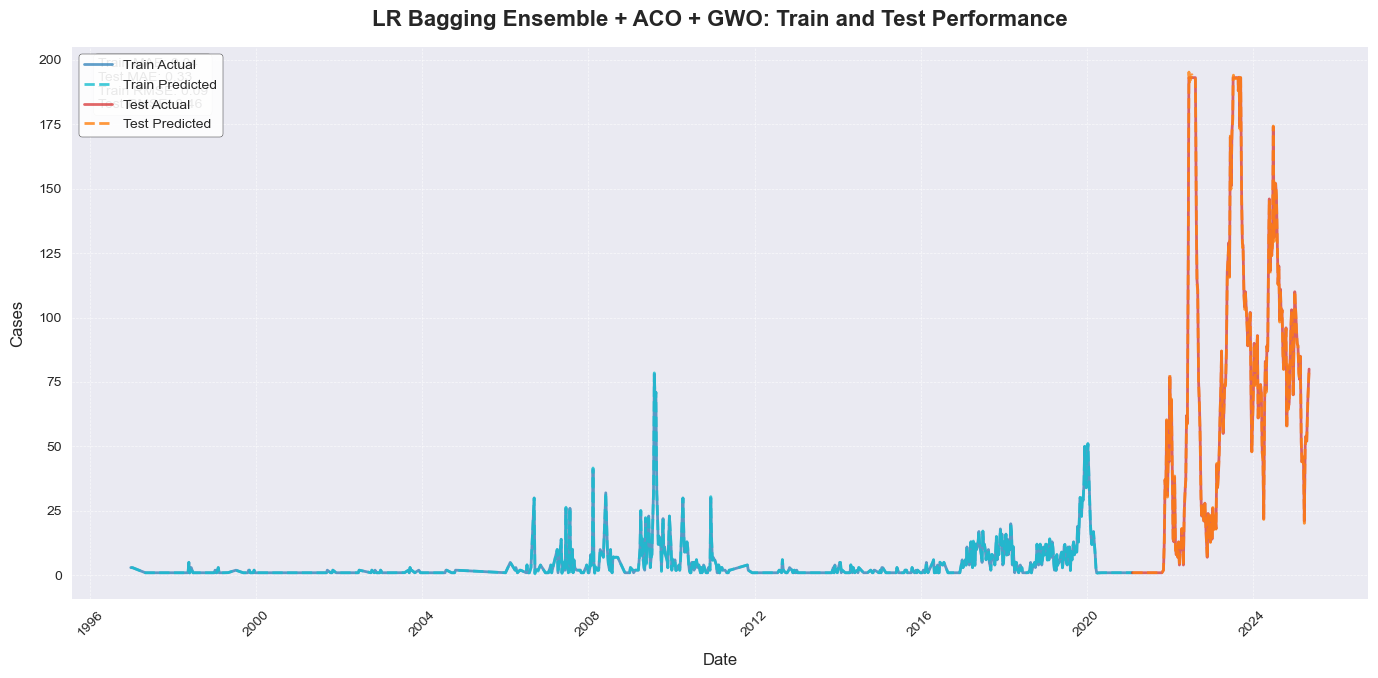

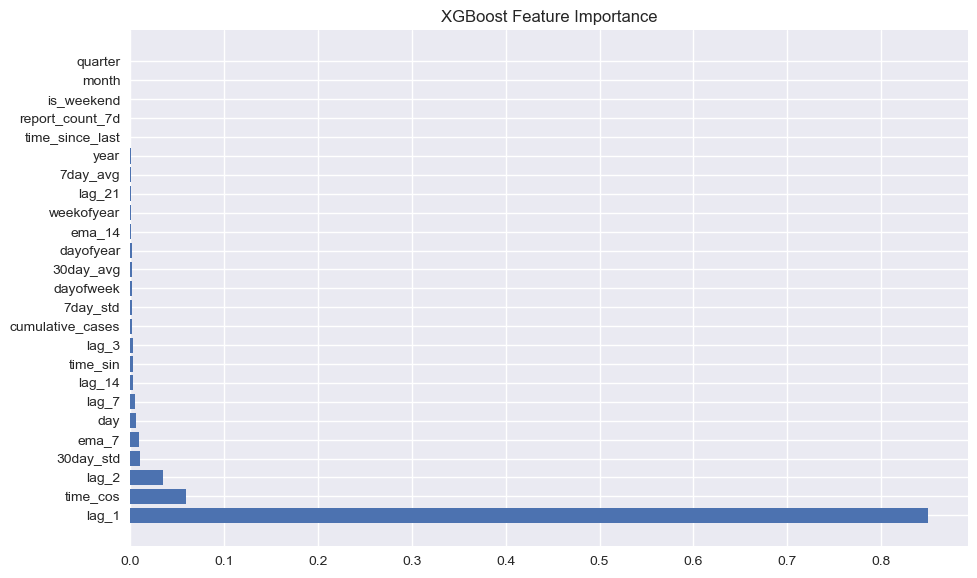


XGBoost Evaluation:
  MAE: 30.58
  MSE: 2564.81
  RMSE: 50.64
  MAPE: 25.59%
  SMAPE: 33.84%
  R2: 0.24
XGBoost - Train MAE: 0.15, Test MAE: 30.58
XGBoost - Train RMSE: 0.34, Test RMSE: 50.64


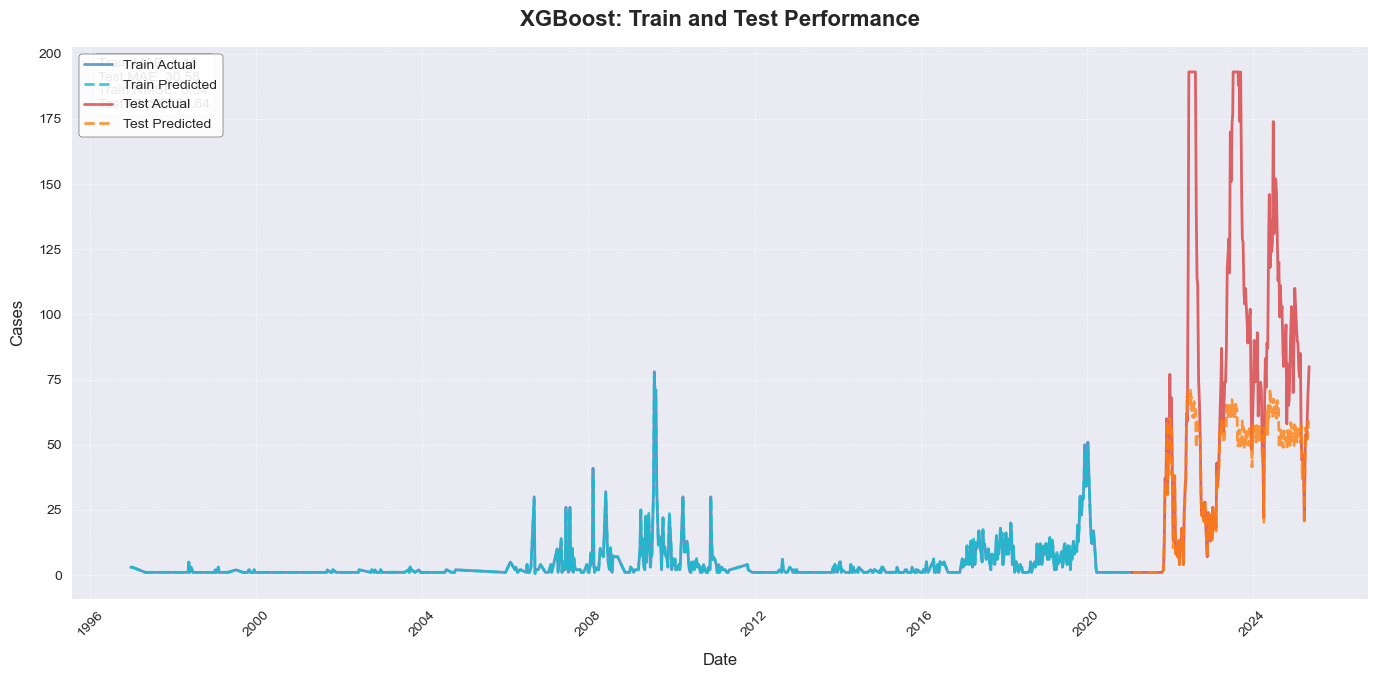

  File "C:\Users\user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\user\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



LightGBM Evaluation:
  MAE: 29.51
  MSE: 2402.32
  RMSE: 49.01
  MAPE: 24.68%
  SMAPE: 32.24%
  R2: 0.29
LightGBM - Train MAE: 0.15, Test MAE: 29.51
LightGBM - Train RMSE: 0.33, Test RMSE: 49.01


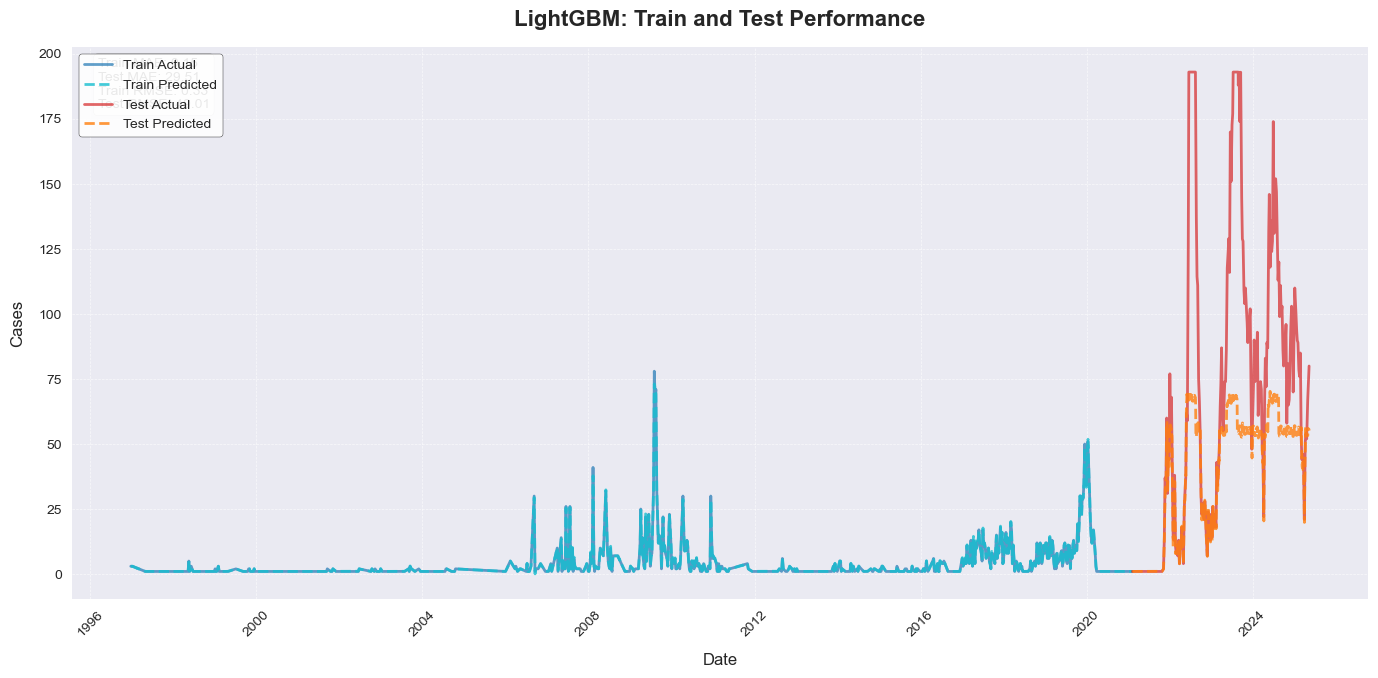

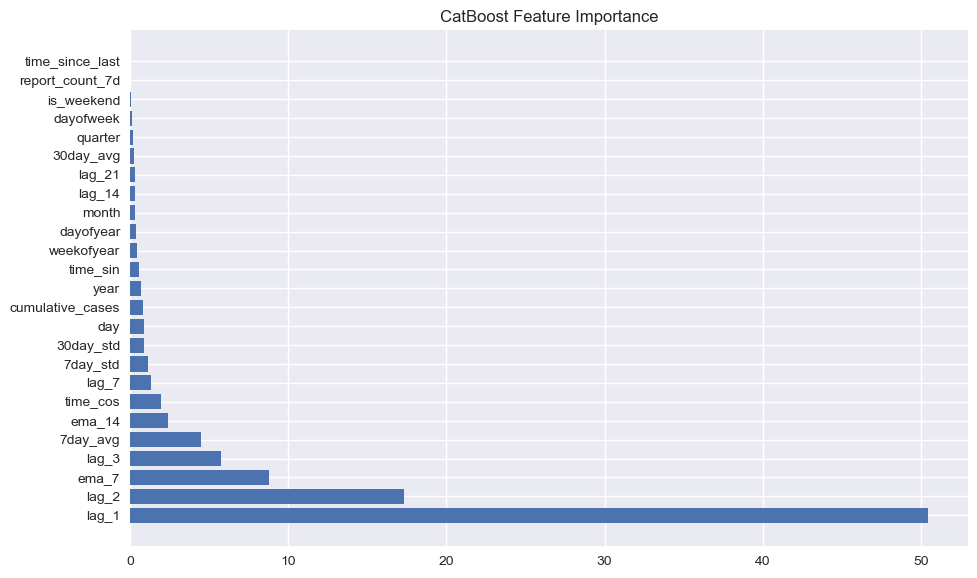


CatBoost Evaluation:
  MAE: 33.22
  MSE: 2888.56
  RMSE: 53.75
  MAPE: 28.51%
  SMAPE: 38.29%
  R2: 0.15
CatBoost - Train MAE: 0.18, Test MAE: 33.22
CatBoost - Train RMSE: 0.34, Test RMSE: 53.75


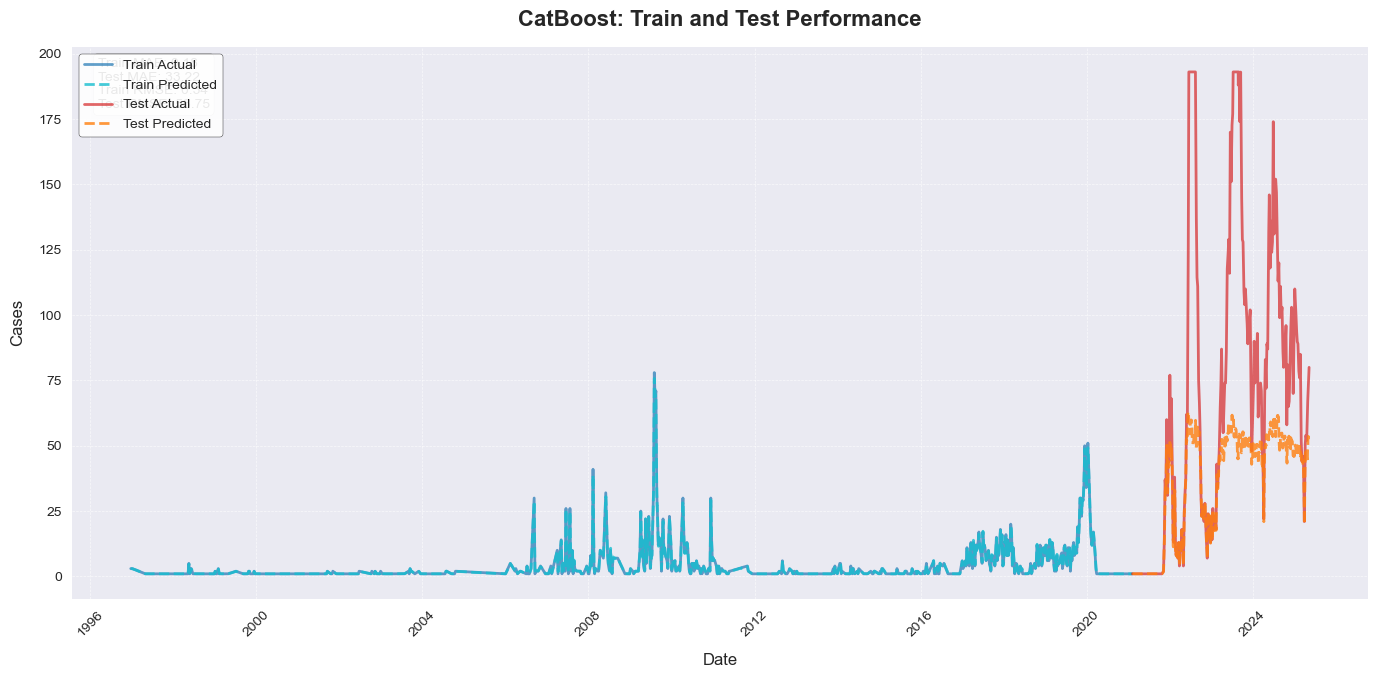

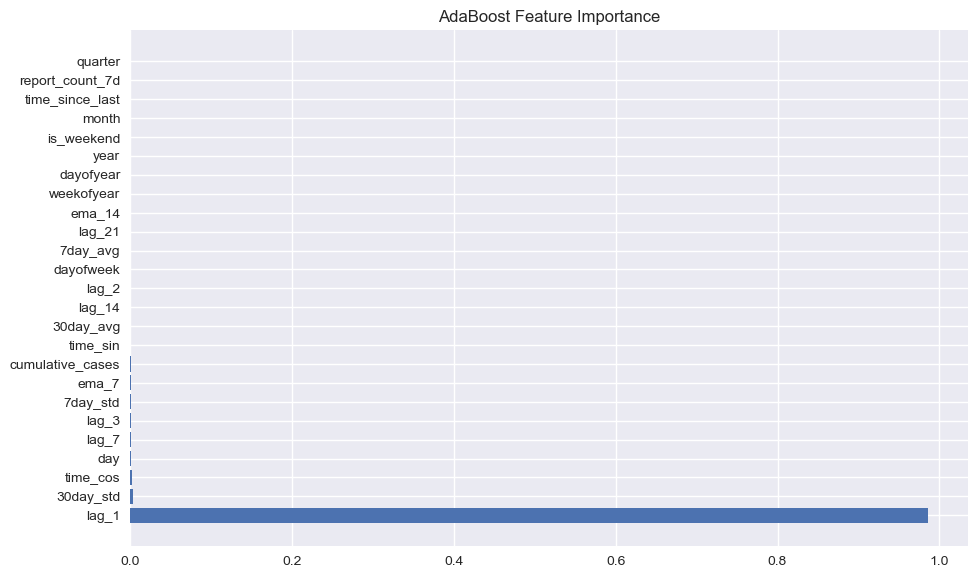


AdaBoost Evaluation:
  MAE: 26.23
  MSE: 2204.17
  RMSE: 46.95
  MAPE: 21.15%
  SMAPE: 27.32%
  R2: 0.35
AdaBoost - Train MAE: 0.22, Test MAE: 26.23
AdaBoost - Train RMSE: 0.44, Test RMSE: 46.95


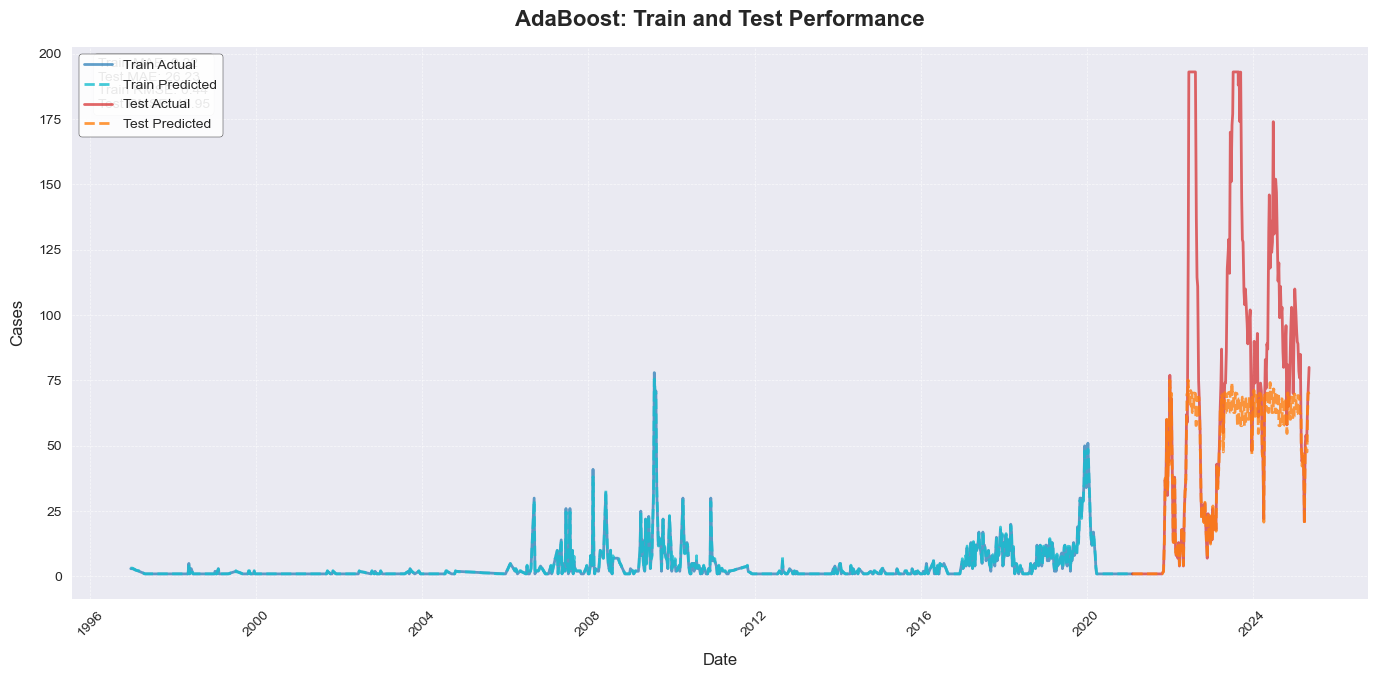


SVR Evaluation:
  MAE: 52.12
  MSE: 5569.26
  RMSE: 74.63
  MAPE: 103.31%
  SMAPE: 98.57%
  R2: -0.64
SVR - Train MAE: 0.05, Test MAE: 52.12
SVR - Train RMSE: 0.06, Test RMSE: 74.63


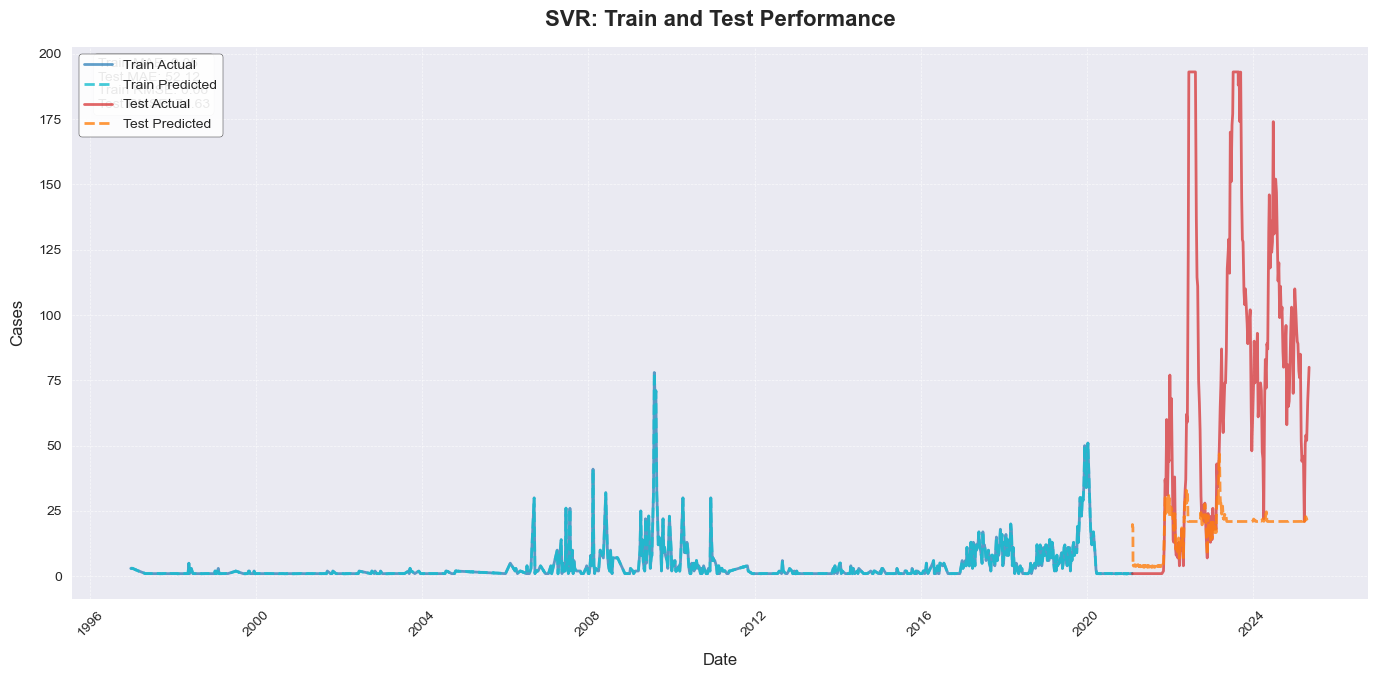


KNN Evaluation:
  MAE: 29.16
  MSE: 2361.40
  RMSE: 48.59
  MAPE: 30.80%
  SMAPE: 37.07%
  R2: 0.30
KNN - Train MAE: 0.31, Test MAE: 29.16
KNN - Train RMSE: 0.62, Test RMSE: 48.59


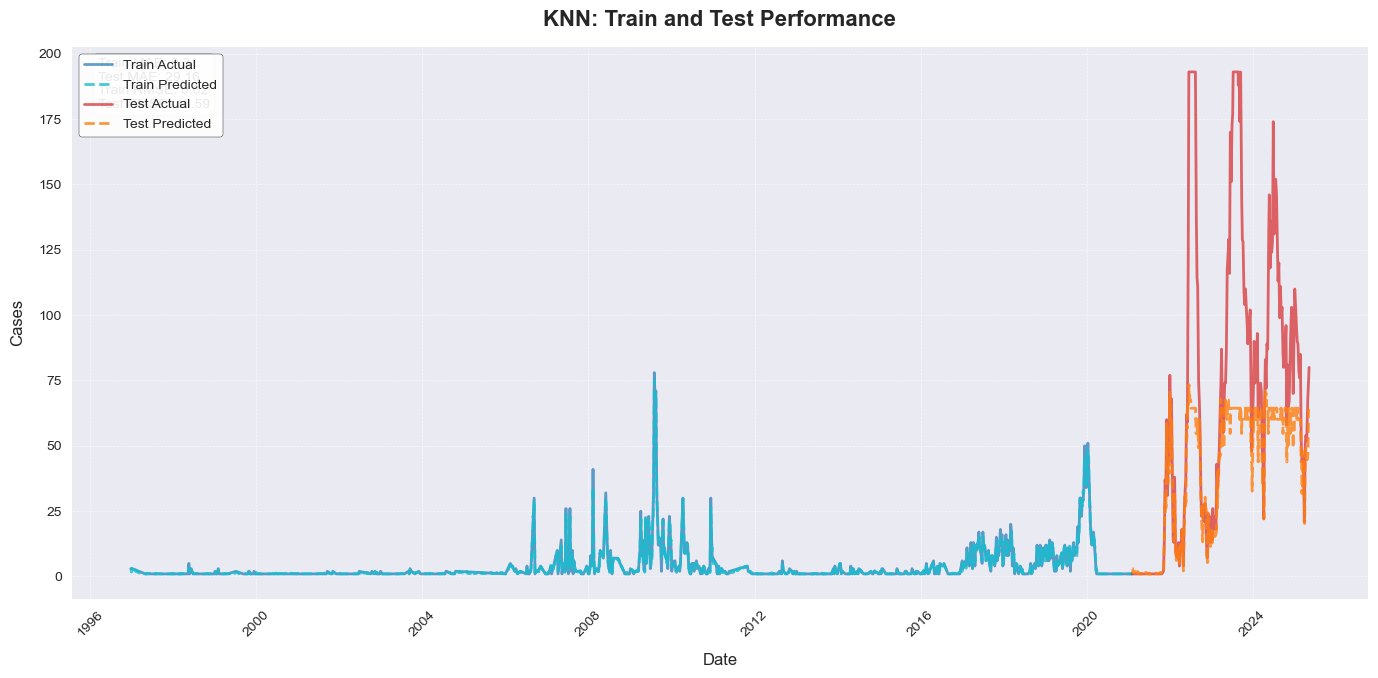

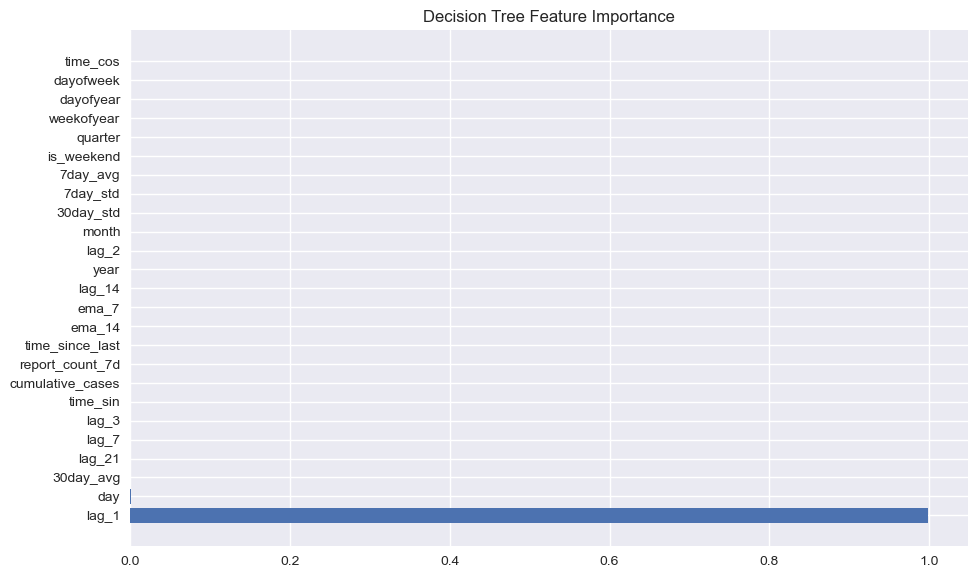


Decision Tree Evaluation:
  MAE: 25.94
  MSE: 2178.70
  RMSE: 46.68
  MAPE: 20.73%
  SMAPE: 26.70%
  R2: 0.36
Decision Tree - Train MAE: 0.25, Test MAE: 25.94
Decision Tree - Train RMSE: 0.56, Test RMSE: 46.68


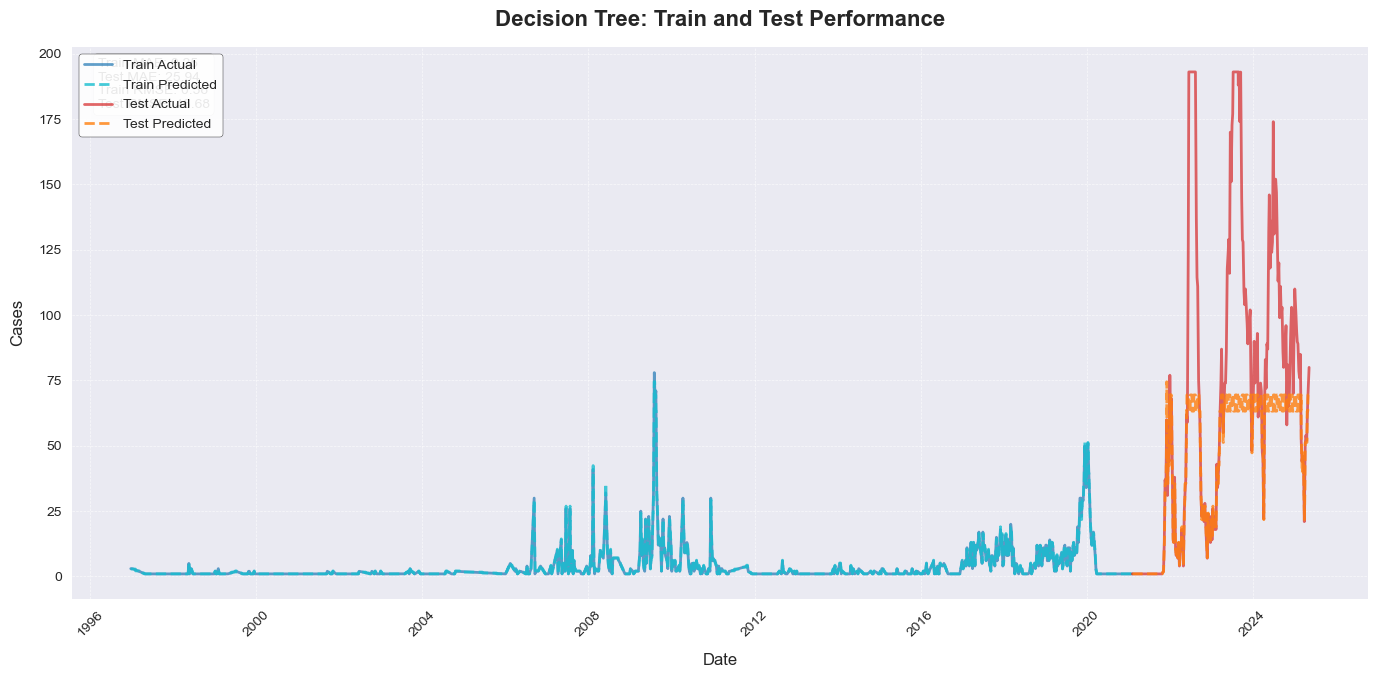

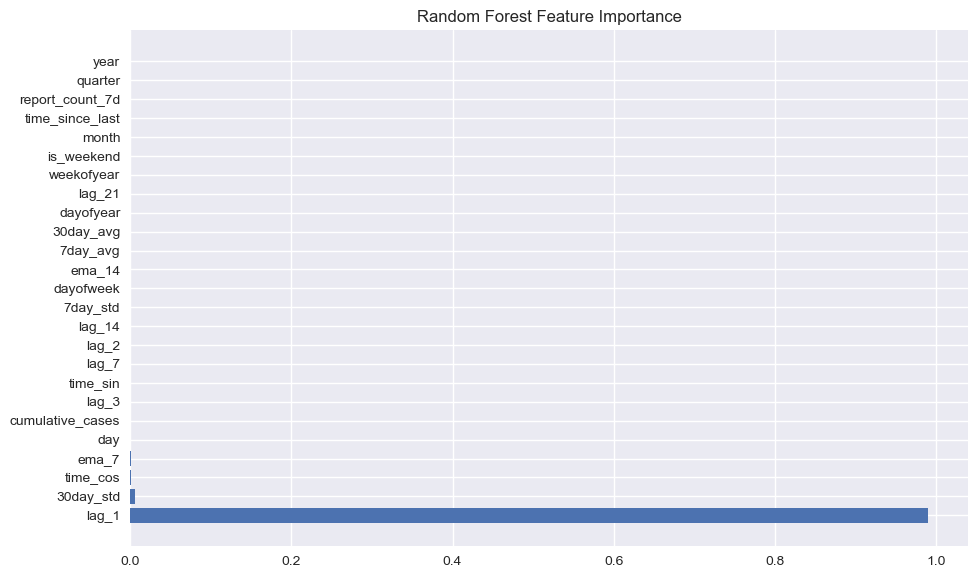


Random Forest Evaluation:
  MAE: 27.05
  MSE: 2274.76
  RMSE: 47.69
  MAPE: 21.69%
  SMAPE: 28.16%
  R2: 0.33
Random Forest - Train MAE: 0.21, Test MAE: 27.05
Random Forest - Train RMSE: 0.50, Test RMSE: 47.69


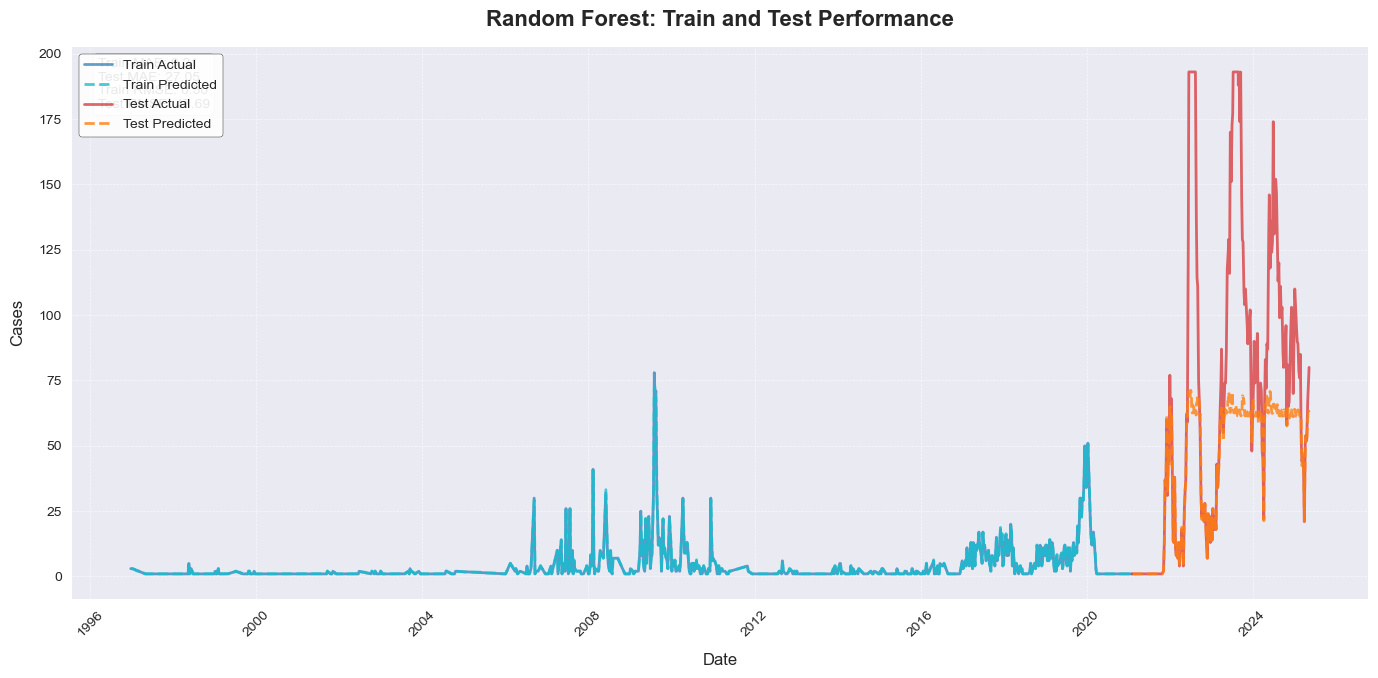


Voting Regressor Evaluation:
  MAE: 0.92
  MSE: 1.67
  RMSE: 1.29
  MAPE: 1.52%
  SMAPE: 1.54%
  R2: 1.00
Voting Regressor - Train MAE: 0.09, Test MAE: 0.92
Voting Regressor - Train RMSE: 0.22, Test RMSE: 1.29


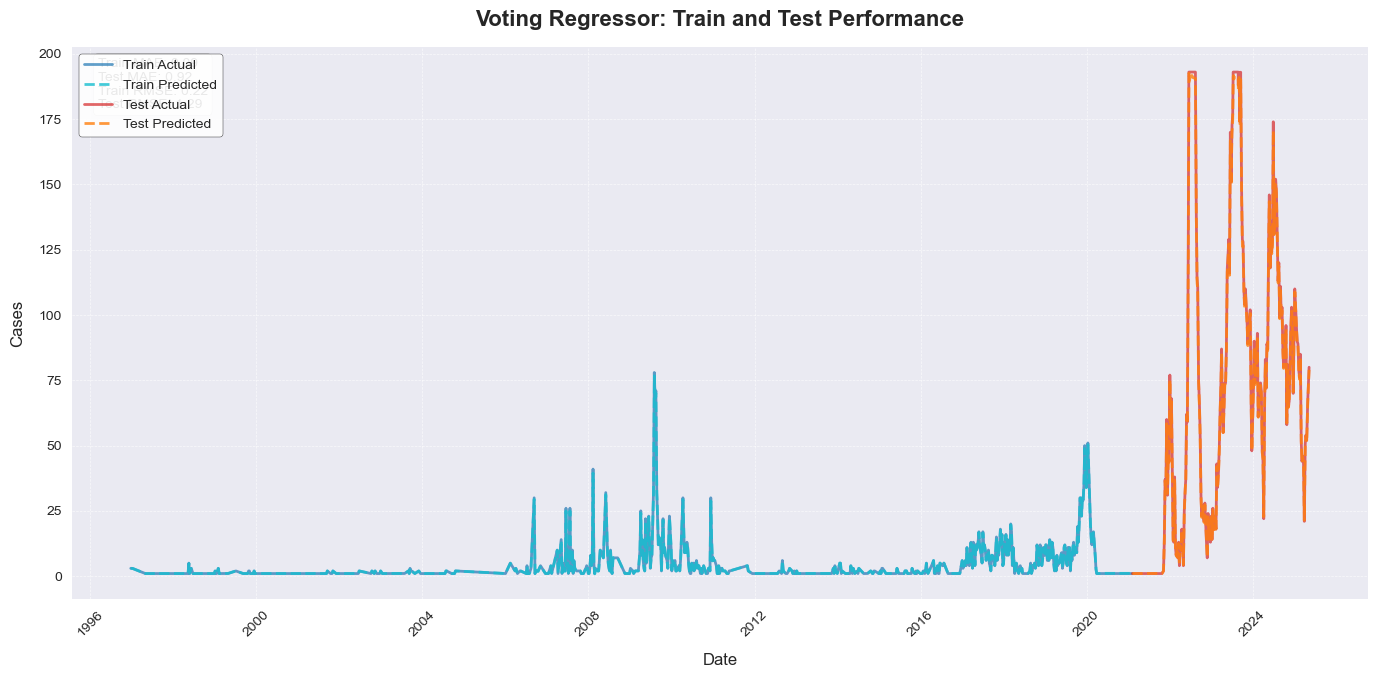


XGBoost + LR Evaluation:
  MAE: 26.91
  MSE: 2105.43
  RMSE: 45.88
  MAPE: 27.05%
  SMAPE: 33.46%
  R2: 0.38
XGBoost + LR - Train MAE: 0.47, Test MAE: 26.91
XGBoost + LR - Train RMSE: 0.99, Test RMSE: 45.88


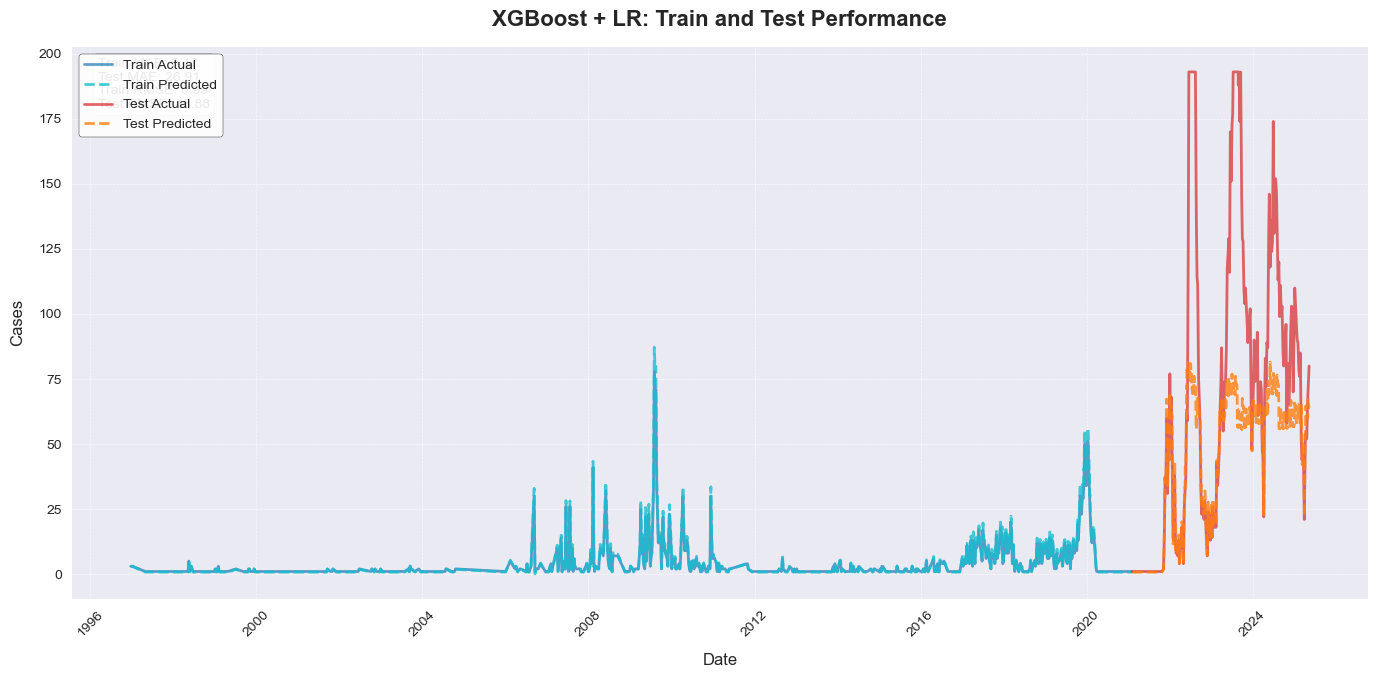

15:00:38 - cmdstanpy - INFO - Chain [1] start processing
15:00:43 - cmdstanpy - INFO - Chain [1] done processing


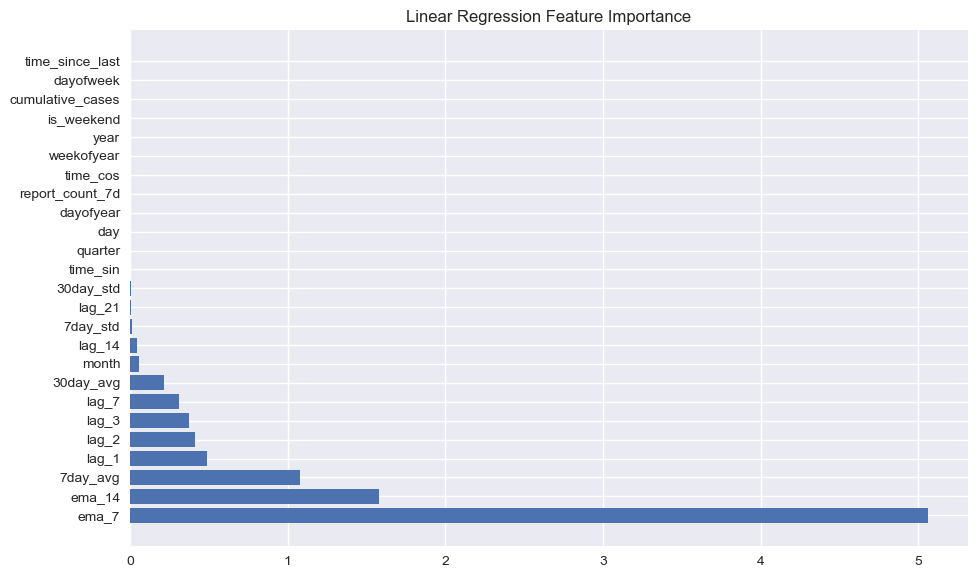


Prophet + LR Evaluation:
  MAE: 1.00
  MSE: 2.00
  RMSE: 1.41
  MAPE: 3.52%
  SMAPE: 3.40%
  R2: 1.00
Prophet + LR - Train MAE: 0.13, Test MAE: 1.00
Prophet + LR - Train RMSE: 0.28, Test RMSE: 1.41


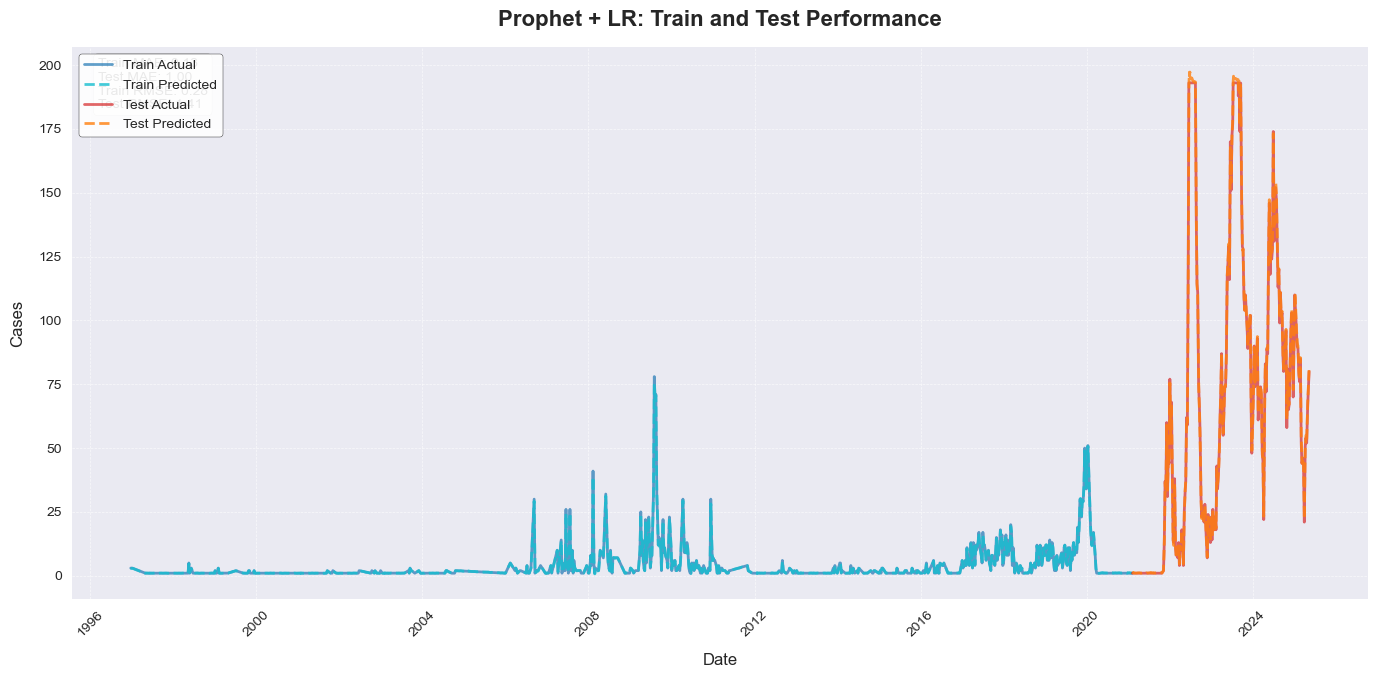


ANN Evaluation:
  MAE: 2.66
  MSE: 13.26
  RMSE: 3.64
  MAPE: 16.48%
  SMAPE: 13.20%
  R2: 1.00
ANN - Train MAE: 0.34, Test MAE: 2.66
ANN - Train RMSE: 0.70, Test RMSE: 3.64


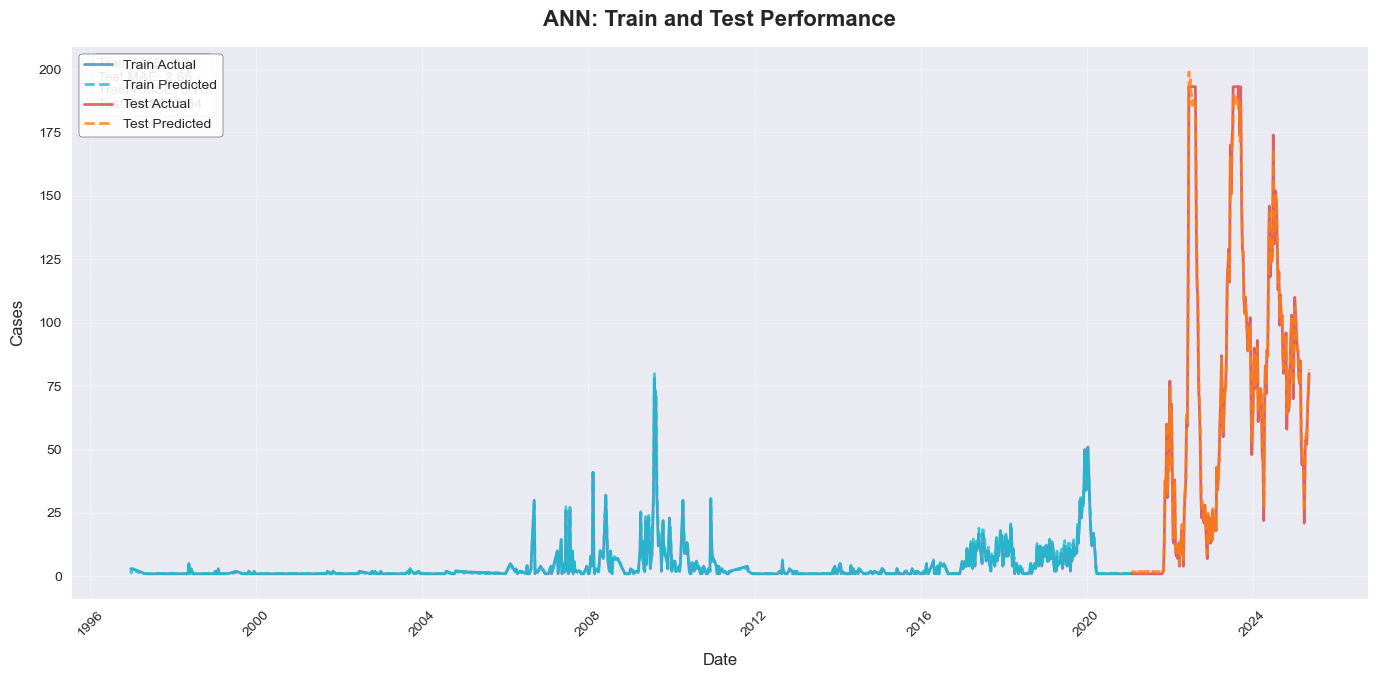

Training boosting base models with time-series cross-validation...
Fold 1: Train size 1472, Validation size 1468
Fold 2: Train size 2940, Validation size 1468
Fold 3: Train size 4408, Validation size 1468
Fold 4: Train size 5876, Validation size 1468
Fold 5: Train size 7344, Validation size 1468
Retraining boosting base models on full training set...

Boosting Stacking Evaluation:
  MAE: 24.78
  MSE: 1954.85
  RMSE: 44.21
  MAPE: 27.68%
  SMAPE: 31.38%
  R2: 0.42
Boosting Stacking - Train MAE: 0.65, Test MAE: 24.78
Boosting Stacking - Train RMSE: 0.91, Test RMSE: 44.21


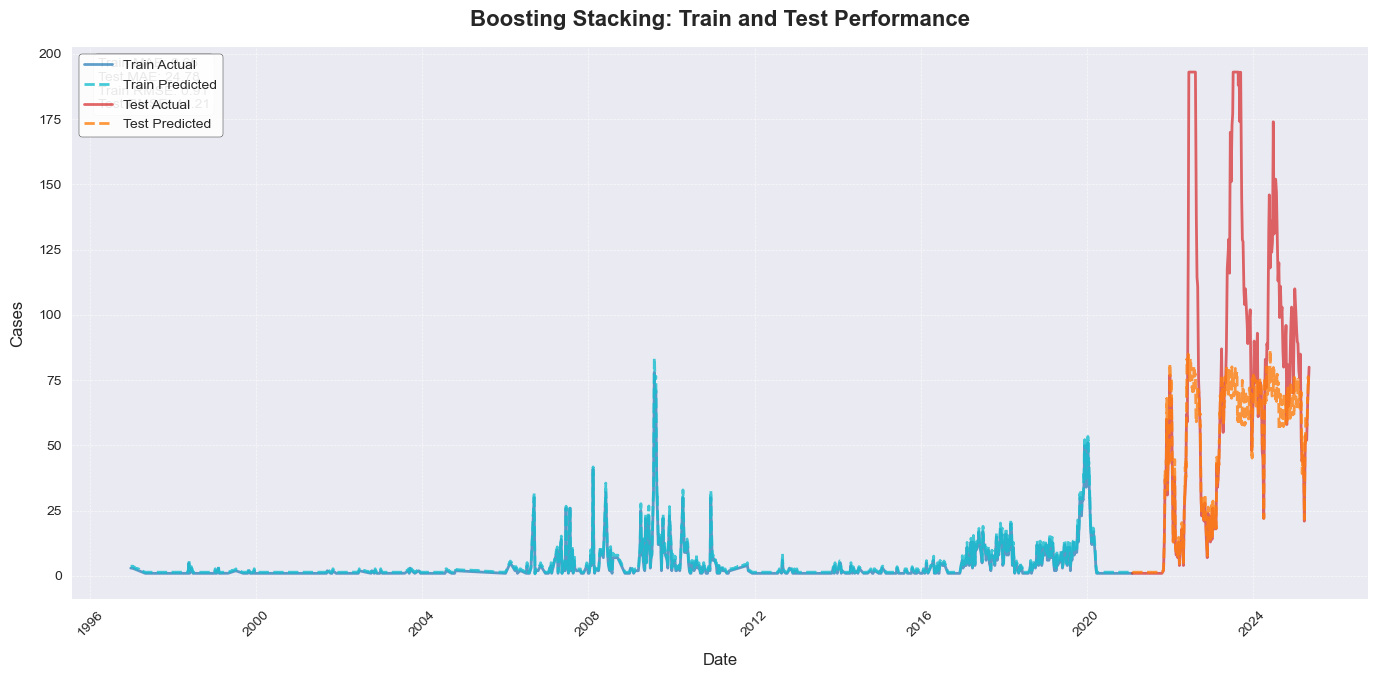

Training tree-based base models with time-series cross-validation...
Fold 1: Train size 1472, Validation size 1468
Fold 2: Train size 2940, Validation size 1468
Fold 3: Train size 4408, Validation size 1468
Fold 4: Train size 5876, Validation size 1468
Fold 5: Train size 7344, Validation size 1468
Retraining tree-based base models on full training set...

Tree Stacking Evaluation:
  MAE: 26.45
  MSE: 2136.65
  RMSE: 46.22
  MAPE: 30.43%
  SMAPE: 34.36%
  R2: 0.37
Tree Stacking - Train MAE: 0.70, Test MAE: 26.45
Tree Stacking - Train RMSE: 1.08, Test RMSE: 46.22


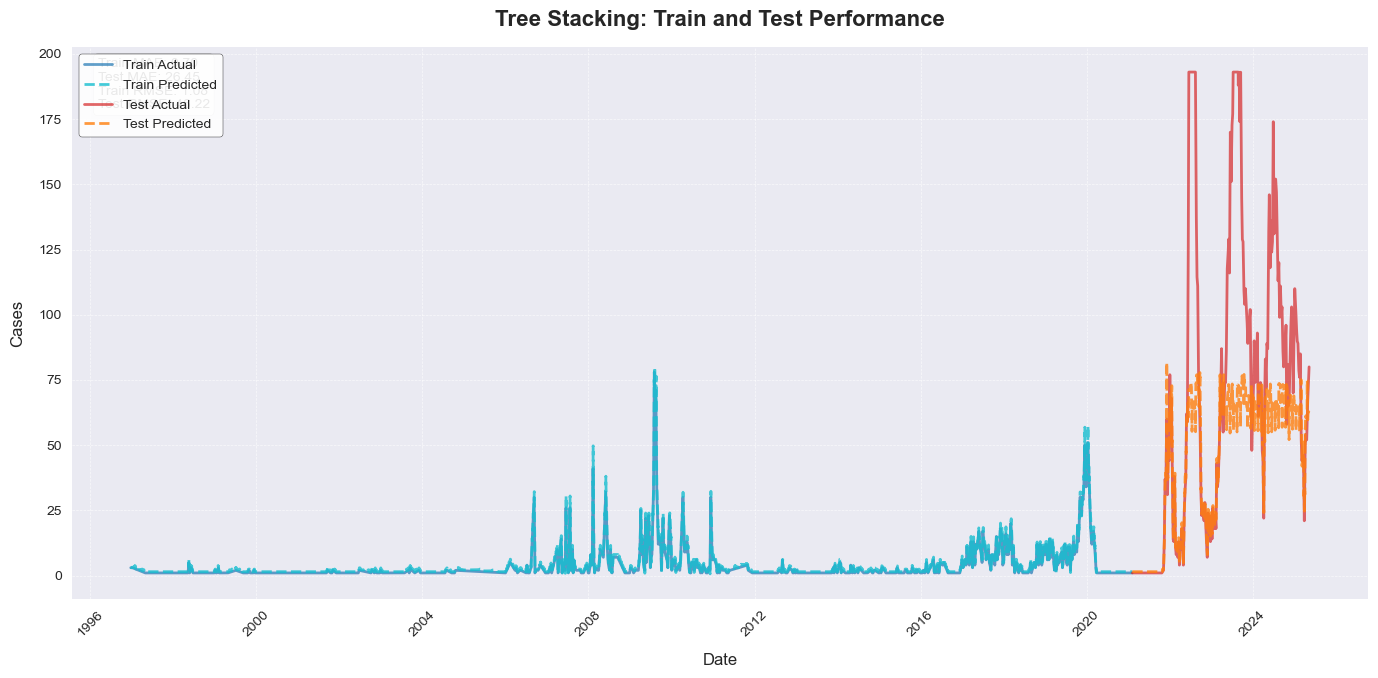


Model Performance Summary:
                          Model       MAE         MSE      RMSE       MAPE     SMAPE        R2
                     LR-ACO-GWO  0.323698    0.244263  0.494230   0.732613  0.733674  0.999928
LR Bagging Ensemble + ACO + GWO  0.327797    0.207882  0.455941   0.988281  0.990071  0.999939
                         LR-ACO  0.331708    0.212231  0.460685   1.010808  1.012333  0.999937
                         LR-GWO  0.332813    0.217968  0.466870   0.801688  0.808868  0.999936
              Linear Regression  0.332950    0.218130  0.467044   0.802787  0.809984  0.999936
            LR Bagging Ensemble  0.401834    0.375743  0.612979   0.996183  1.001570  0.999889
               Voting Regressor  0.918471    1.667440  1.291294   1.521026  1.539804  0.999508
                   Prophet + LR  0.995151    1.999317  1.413972   3.515122  3.398028  0.999410
                            ANN  2.658887   13.257436  3.641076  16.480171 13.197213  0.996090
                      

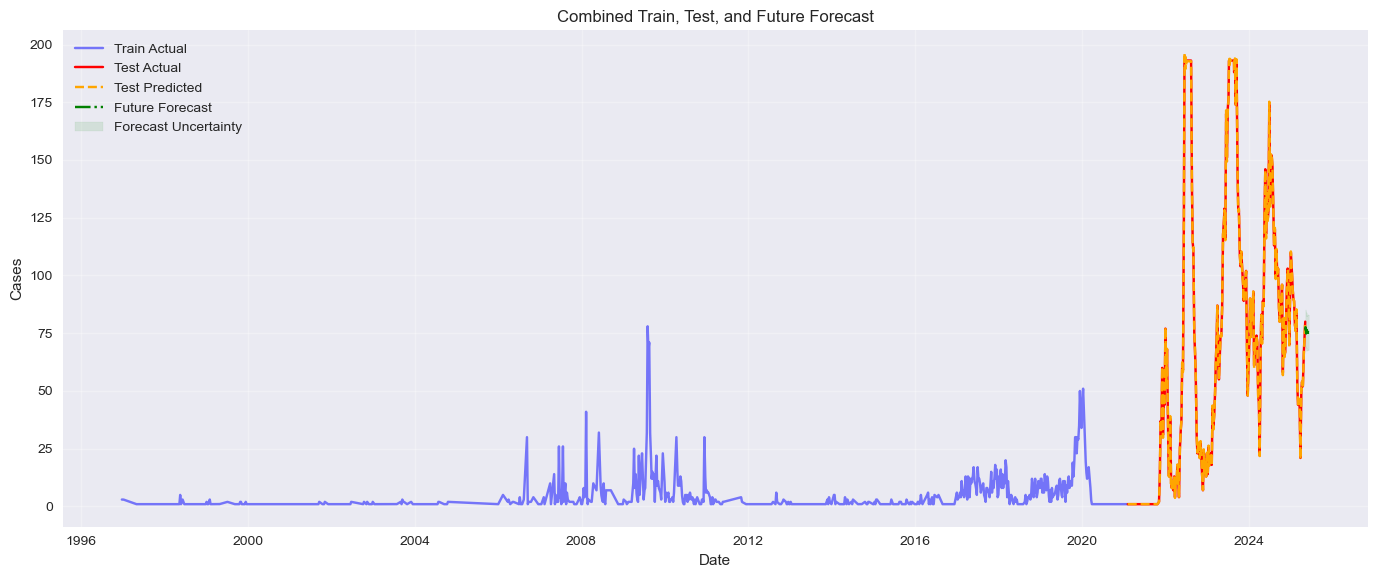

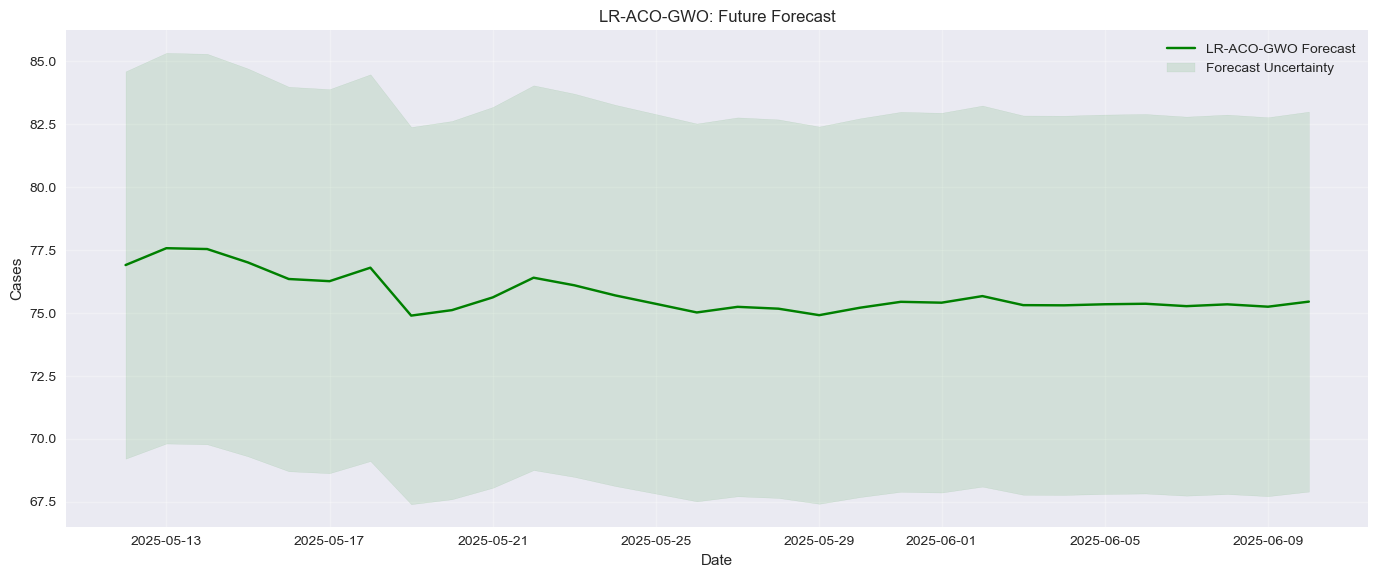


Future Forecasts for All Models:

Prophet Forecast:
        ds      yhat
2025-05-12 85.267785
2025-05-13 85.207794
2025-05-14 85.160955
2025-05-15 85.088403
2025-05-16 85.009615
2025-05-17 84.947574
2025-05-18 84.916335
2025-05-19 84.923316
2025-05-20 84.967873
2025-05-21 85.035880
2025-05-22 85.109188
2025-05-23 85.168006
2025-05-24 85.196148
2025-05-25 85.179047
2025-05-26 85.114483
2025-05-27 85.013929
2025-05-28 84.893150
2025-05-29 84.772884
2025-05-30 84.671333
2025-05-31 84.601510
2025-06-01 84.564521
2025-06-02 84.248681
2025-06-03 84.580390
2025-06-04 84.620446
2025-06-05 84.668544
2025-06-06 84.714608
2025-06-07 84.408498
2025-06-08 84.775589
2025-06-09 84.784375
2025-06-10 84.782951

Linear Regression Forecast:
        ds      yhat
2025-05-12 77.671036
2025-05-13 78.271642
2025-05-14 77.935387
2025-05-15 77.346527
2025-05-16 77.035330
2025-05-17 77.059468
2025-05-18 77.529440
2025-05-19 76.139999
2025-05-20 76.592599
2025-05-21 77.030227
2025-05-22 77.489983
2025-05-23 77.1

In [25]:
# BEST ONE
from sklearn.ensemble import AdaBoostRegressor
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

# Configure logging to suppress unnecessary warnings
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Define universal feature set for ML models
FEATURES = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    '7day_avg', '30day_avg', '7day_std', '30day_std', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
    'lag_14', 'lag_21', 'ema_7', 'ema_14', 'time_since_last', 'report_count_7d',
    'cumulative_cases', 'time_sin', 'time_cos'
]

# === DATA PREPROCESSING ===

def preprocess_data(df, frequency='D', fixed_daily=True):
    """Preprocess input DataFrame for forecasting, handling both fixed and irregular time series."""
    try:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if 'SUM_INF_A' not in df.columns:
            raise ValueError("DataFrame must contain 'SUM_INF_A' column")

        df = df.copy()
        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)
        elif not pd.api.types.is_datetime64_any_dtype(df.index):
            df.index = pd.to_datetime(df.index)
            df.index.name = 'Datetime'
        df.index = pd.to_datetime(df.index)

        if fixed_daily:
            df = df.resample(frequency).sum(numeric_only=True).fillna(0)
        else:
            df = df.sort_index()
            df['SUM_INF_A'] = df['SUM_INF_A'].replace(0, np.nan).interpolate(method='time').fillna(method='bfill')

        df.index.name = 'ds'
        df.rename(columns={'SUM_INF_A': 'y'}, inplace=True)
        df['y'] = df['y'].replace(0, np.nan).interpolate(method='time').fillna(method='bfill')
        df['y'] = df['y'].clip(lower=df['y'].quantile(0.01), upper=df['y'].quantile(0.99))
        df['y_log'] = np.log(df['y'].clip(lower=df['y'].quantile(0.01)))
        df = df.reset_index()
        return df
    except Exception as e:
        print(f"Error in preprocess_data: {e}")
        raise

def add_features(df, fixed_daily=True, is_future=False, base_df=None):
    """Add time-series features to DataFrame, ensuring no data leakage."""
    try:
        df = df.copy()
        df['ds'] = pd.to_datetime(df['ds'])

        df['dayofweek'] = df['ds'].dt.dayofweek
        df['month'] = df['ds'].dt.month
        df['is_weekend'] = df['dayofweek'].ge(5).astype(int)
        df['year'] = df['ds'].dt.year
        df['day'] = df['ds'].dt.day
        df['dayofyear'] = df['ds'].dt.dayofyear
        df['weekofyear'] = df['ds'].dt.isocalendar().week
        df['quarter'] = df['ds'].dt.quarter

        if not is_future:
            df.set_index('ds', inplace=True)
            window = '7D' if fixed_daily else '7D'
            df['7day_avg'] = df['y'].rolling(window, min_periods=1, closed='both' if not fixed_daily else None).mean()
            df['30day_avg'] = df['y'].rolling('30D', min_periods=1, closed='both' if not fixed_daily else None).mean()
            df['7day_std'] = df['y'].rolling(window, min_periods=1, closed='both' if not fixed_daily else None).std()
            df['30day_std'] = df['y'].rolling('30D', min_periods=1, closed='both' if not fixed_daily else None).std()
            df = df.reset_index()

            lags = [1, 2, 3, 7, 14, 21]
            if fixed_daily:
                for lag in lags:
                    df[f'lag_{lag}'] = df['y'].shift(lag)
            else:
                for lag in lags:
                    df[f'lag_{lag}'] = df['y'].shift(1)
                    for i in range(1, len(df)):
                        time_diff = (df['ds'].iloc[i] - df['ds'].iloc[:i]).dt.total_seconds() / 86400
                        idx = np.argmin(np.abs(time_diff - lag))
                        df.loc[df.index[i], f'lag_{lag}'] = df['y'].iloc[idx]

            df['ema_7'] = df['y'].ewm(span=7, adjust=False).mean()
            df['ema_14'] = df['y'].ewm(span=14, adjust=False).mean()
            df['time_since_last'] = df['ds'].diff().dt.total_seconds() / 86400
            df.set_index('ds', inplace=True)
            df['report_count_7d'] = df['y'].rolling('7D', min_periods=1).count()
            df = df.reset_index()
            df['cumulative_cases'] = df['y'].cumsum()
            df['time_sin'] = np.sin(2 * np.pi * df['ds'].dt.dayofyear / 365)
            df['time_cos'] = np.cos(2 * np.pi * df['ds'].dt.dayofyear / 365)

            if fixed_daily:
                stl = STL(df.set_index('ds')['y'], period=7, robust=True)
                result = stl.fit()
                df['trend'] = result.trend.values
                df['seasonal'] = result.seasonal.values
                df['resid'] = result.resid.values

        else:
            if base_df is None:
                raise ValueError("base_df must be provided for future forecasting")
            
            lags = [1, 2, 3, 7, 14, 21]
            latest_values = base_df.tail(max(lags)).copy()
            y_values = latest_values['y'].values
            
            df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
            df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
            df['7day_std'] = base_df['7day_std'].iloc[-7:].mean()
            df['30day_std'] = base_df['30day_std'].iloc[-30:].mean()
            
            if fixed_daily:
                for lag in lags:
                    if len(y_values) >= lag:
                        df[f'lag_{lag}'] = y_values[-lag]
            else:
                for lag in lags:
                    df[f'lag_{lag}'] = y_values[-1]
                    for i in range(len(df)):
                        time_diff = (df['ds'].iloc[i] - base_df['ds']).dt.total_seconds() / 86400
                        idx = np.argmin(np.abs(time_diff - lag))
                        df.loc[df.index[i], f'lag_{lag}'] = base_df['y'].iloc[idx]

            df['ema_7'] = base_df['ema_7'].iloc[-1]
            df['ema_14'] = base_df['ema_14'].iloc[-1]
            df['time_since_last'] = base_df['time_since_last'].mean()
            df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
            df['cumulative_cases'] = base_df['cumulative_cases'].iloc[-1]
            df['time_sin'] = np.sin(2 * np.pi * df['ds'].dt.dayofyear / 365)
            df['time_cos'] = np.cos(2 * np.pi * df['ds'].dt.dayofyear / 365)

        df[FEATURES] = df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        df['time_since_last'] = df['time_since_last'].fillna(df['time_since_last'].mean())
        
        return df
    except Exception as e:
        print(f"Error in add_features: {e}")
        raise

# === MODEL IMPLEMENTATIONS ===

def create_prophet_model():
    """Create and configure a Prophet model with custom seasonalities and regressors."""
    model = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=12,
        holidays_prior_scale=15,
        weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_range=0.9
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
    model.add_country_holidays(country_name='Malaysia')
    for reg in ['7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']:
        model.add_regressor(reg)
    return model

def run_linear_regression(train_df, test_df, target='y'):
    """Fit and forecast using Linear Regression model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('Linear Regression Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model
    except Exception as e:
        print(f"Error in run_linear_regression: {e}")
        raise

def run_voting_regressor(train_df, test_df, target='y'):
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        estimators = [
            ('lr', LinearRegression()),
            ('ridge', Ridge(alpha=1.0)),
            ('lasso', Lasso(alpha=1.0))
        ]
        model = VotingRegressor(estimators=estimators, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        return predictions, model
    except Exception as e:
        print(f"Error in run_voting_regressor: {e}")
        raise

from sklearn.ensemble import StackingRegressor

def run_xgboost_lr(train_df, test_df, target='y'):
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        xgb_model = XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=3,
            random_state=42,
            verbosity=0
        )
        
        # Define stacking model
        model = StackingRegressor(
            estimators=[('xgboost', xgb_model)],
            final_estimator=LinearRegression()
        )
        
        # Fit model
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)  
        
        return predictions, model

    except Exception as e:
        print(f"Error in run_xgboost_lr: {e}")
        raise
        
def run_xgboost(train_df, test_df, target='y'):
    """Fit and forecast using XGBoost model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

def run_lightgbm(train_df, test_df, target='y'):
    """Fit and forecast using LightGBM model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions, model

def run_catboost(train_df, test_df, target='y'):
    """Fit and forecast using CatBoost model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.get_feature_importance()
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('CatBoost Feature Importance')
    plt.tight_layout()
    plt.show()    
    plt.close()
    return predictions, model

def run_adaboost(train_df, test_df, target='y'):
    """Fit and forecast using AdaBoost model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('AdaBoost Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model
    except Exception as e:
        print(f"Error in run_adaboost: {e}")
        raise

def run_svr(train_df, test_df, target='y'):
    """Fit and forecast using SVR model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = SVR(kernel='rbf', C=100, epsilon=0.1)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions, (model, scaler)

def run_knn(train_df, test_df, target='y'):
    """Fit and forecast using KNN model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions, (model, scaler)

def run_decision_tree(train_df, test_df, target='y'):
    """Fit and forecast using Decision Tree model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('Decision Tree Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

def run_random_forest(train_df, test_df, target='y'):
    """Fit and forecast using Random Forest model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

# === NEW STACKING MODELS ===

class StackingModelWrapper:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        
    def predict(self, X):
        base_preds = []
        for name, model in self.base_models.items():
            base_preds.append(model.predict(X))
        stacked_X = np.column_stack(base_preds)
        return self.meta_model.predict(stacked_X)

def create_boosting_stacking_model(train_df, test_df, target='y'):
    """Create a stacking ensemble with boosting models (XGBoost, LightGBM, CatBoost, AdaBoost) and Linear Regression as meta-model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]

        # Define base boosting models
        base_models = {
            'xgb': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42),
            'lgbm': LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1),
            'catboost': CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0),
            'adaboost': AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            )
        }

        # Prepare out-of-fold predictions for meta-model training
        tscv = TimeSeriesSplit(n_splits=5)
        oof_preds = np.zeros((len(X_train), len(base_models)))
        
        print("Training boosting base models with time-series cross-validation...")
        for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            print(f"Fold {i+1}: Train size {len(train_idx)}, Validation size {len(val_idx)}")
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            
            for j, (name, model) in enumerate(base_models.items()):
                model.fit(X_tr, y_tr)
                oof_preds[val_idx, j] = model.predict(X_val)
        
        # Train meta-model on out-of-fold predictions
        meta_model = LinearRegression()
        meta_model.fit(oof_preds, y_train)
        
        # Train base models on full training data for final predictions
        print("Retraining boosting base models on full training set...")
        final_base_models = {}
        for name, model in base_models.items():
            model.fit(X_train, y_train)
            final_base_models[name] = model
        
        # Create predictions for test set
        test_base_preds = np.column_stack([
            model.predict(X_test) for model in final_base_models.values()
        ])
        predictions = meta_model.predict(test_base_preds)
        
        return predictions, StackingModelWrapper(final_base_models, meta_model)
    except Exception as e:
        print(f"Error in create_boosting_stacking_model: {e}")
        raise

def create_tree_stacking_model(train_df, test_df, target='y'):
    """Create a stacking ensemble with tree-based models (Decision Tree, Random Forest, AdaBoost) and Linear Regression as meta-model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]

        # Define base tree-based models
        base_models = {
            'dt': DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
            'rf': RandomForestRegressor(
                n_estimators=100,
                max_depth=5,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            ),
            'adaboost': AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            )
        }

        # Prepare out-of-fold predictions for meta-model training
        tscv = TimeSeriesSplit(n_splits=5)
        oof_preds = np.zeros((len(X_train), len(base_models)))
        
        print("Training tree-based base models with time-series cross-validation...")
        for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            print(f"Fold {i+1}: Train size {len(train_idx)}, Validation size {len(val_idx)}")
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            
            for j, (name, model) in enumerate(base_models.items()):
                model.fit(X_tr, y_tr)
                oof_preds[val_idx, j] = model.predict(X_val)
        
        # Train meta-model on out-of-fold predictions
        meta_model = LinearRegression()
        meta_model.fit(oof_preds, y_train)
        
        # Train base models on full training data for final predictions
        print("Retraining tree-based base models on full training set...")
        final_base_models = {}
        for name, model in base_models.items():
            model.fit(X_train, y_train)
            final_base_models[name] = model
        
        # Create predictions for test set
        test_base_preds = np.column_stack([
            model.predict(X_test) for model in final_base_models.values()
        ])
        predictions = meta_model.predict(test_base_preds)
        
        return predictions, StackingModelWrapper(final_base_models, meta_model)
    except Exception as e:
        print(f"Error in create_tree_stacking_model: {e}")
        raise

def create_lr_bagging_ensemble(train_df, test_df):
    """Create a bagging ensemble of Linear Regression models."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()['y']
        X_test = test_df.dropna()[FEATURES]
        model = BaggingRegressor(
            estimator=LinearRegression(),
            n_estimators=100,
            max_samples=0.8,
            max_features=0.8,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        return predictions, model
    except Exception as e:
        print(f"Error in create_lr_bagging_ensemble: {e}")
        raise

def run_prophet_lr_ensemble(train_df, test_df):
    """Create a simple averaging ensemble of Prophet and Linear Regression."""
    try:
        prophet_model = create_prophet_model()
        prophet_model.fit(train_df)
        prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
        prophet_test = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
        prophet_pred = prophet_model.predict(prophet_test)['yhat'].values
        lr_pred, lr_model = run_linear_regression(train_df, test_df)
        ensemble_pred = 0.2 * prophet_pred + 0.8 * lr_pred
        return ensemble_pred, {'prophet': prophet_model, 'lr': lr_model}
    except Exception as e:
        print(f"Error in run_prophet_lr_ensemble: {e}")
        raise

def create_neural_network(input_dim):
    """Create and configure a feedforward ANN for time series forecasting."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def run_neural_network(train_df, test_df, target='y', epochs=100, batch_size=32):
    """Fit and forecast using ANN model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model = create_neural_network(input_dim=len(FEATURES))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
        predictions = model.predict(X_test_scaled, verbose=0).flatten()
        return predictions, (model, scaler)
    except Exception as e:
        print(f"Error in run_neural_network: {e}")
        raise

# === ACO for Feature Selection ===

class AntColonyOptimization:
    def __init__(self, n_ants, n_features, n_iterations=50, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.n_ants = n_ants
        self.n_features = n_features
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromones = np.ones(n_features)
        self.best_solution = None
        self.best_score = np.inf

    def _evaluate_solution(self, selected_features, train_df, target='y'):
        if not selected_features:
            return np.inf
        selected_feature_names = [FEATURES[i] for i in selected_features]
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        tscv = TimeSeriesSplit(n_splits=5)
        mae_scores = []
        for train_idx, val_idx in tscv.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model = LinearRegression()
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            mae_scores.append(mae)
        return np.mean(mae_scores)

    def _construct_solution(self):
        selected_features = []
        available_features = list(range(self.n_features))
        n_select = np.random.randint(1, self.n_features + 1)
        for _ in range(n_select):
            if not available_features:
                break
            pheromones = self.pheromones[available_features]
            heuristic = 1.0 / (1.0 + np.arange(len(available_features)))
            probabilities = (pheromones ** self.alpha) * (heuristic ** self.beta)
            probabilities /= probabilities.sum()
            selected_idx = np.random.choice(len(available_features), p=probabilities)
            selected_feature = available_features.pop(selected_idx)
            selected_features.append(selected_feature)
        return selected_features

    def _update_pheromones(self, solutions, scores):
        self.pheromones *= (1 - self.evaporation_rate)
        for solution, score in zip(solutions, scores):
            for feature_idx in solution:
                self.pheromones[feature_idx] += self.Q / score
        best_idx = np.argmin(scores)
        if scores[best_idx] < self.best_score:
            self.best_score = scores[best_idx]
            self.best_solution = solutions[best_idx]

    def optimize(self, train_df, target='y'):
        print("Running ACO for feature selection...")
        for iteration in range(self.n_iterations):
            solutions = []
            scores = []
            for _ in range(self.n_ants):
                solution = self._construct_solution()
                score = self._evaluate_solution(solution, train_df, target)
                solutions.append(solution)
                scores.append(score)
            self._update_pheromones(solutions, scores)
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best MAE: {self.best_score:.2f}")
        return self.best_solution

def run_lr_aco(train_df, test_df, target='y', n_ants=20, n_iterations=50):
    """Fit and forecast using Linear Regression with ACO feature selection."""
    try:
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-ACO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model, selected_feature_indices
    except Exception as e:
        print(f"Error in run_lr_aco: {e}")
        raise

# === Grey Wolf Optimization ===

class GreyWolfOptimization:
    def __init__(self, n_wolves, n_iterations, search_space, train_df, selected_features, target='y'):
        self.n_wolves = n_wolves
        self.n_iterations = n_iterations
        self.search_space = search_space
        self.train_df = train_df
        self.selected_features = selected_features
        self.target = target
        self.best_alpha = None
        self.best_score = np.inf

    def _evaluate_solution(self, params):
        try:
            selected_feature_names = [FEATURES[i] for i in self.selected_features]
            X_train = self.train_df.dropna()[selected_feature_names]
            y_train = self.train_df.dropna()[self.target]
            tscv = TimeSeriesSplit(n_splits=5)
            mae_scores = []
            for train_idx, val_idx in tscv.split(X_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                model = Ridge(alpha=params['alpha'])
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
                mae = mean_absolute_error(y_val, y_pred)
                mae_scores.append(mae)
            return np.mean(mae_scores)
        except Exception as e:
            print(f"Error in GWO evaluation: {e}")
            return np.inf

    def optimize(self):
        print("Running GWO for hyperparameter optimization...")
        wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                  for key, bounds in self.search_space.items()}
        alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
        alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

        for iteration in range(self.n_iterations):
            a = 2 - iteration * (2 / self.n_iterations)
            for i in range(self.n_wolves):
                params = {key: wolves[key][i] for key in self.search_space}
                score = self._evaluate_solution(params)
                if score < alpha_score:
                    delta_score, delta_pos = beta_score, beta_pos
                    beta_score, beta_pos = alpha_score, alpha_pos
                    alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                elif score < beta_score:
                    delta_score, delta_pos = beta_score, beta_pos
                    beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                elif score < delta_score:
                    delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

            for key in self.search_space:
                for i in range(self.n_wolves):
                    r1, r2 = np.random.random(2)
                    A1, C1 = 2 * a * r1 - a, 2 * r2
                    D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                    X1 = alpha_pos[key] - A1 * D_alpha
                    r1, r2 = np.random.random(2)
                    A2, C2 = 2 * a * r1 - a, 2 * r2
                    D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                    X2 = beta_pos[key] - A2 * D_beta
                    r1, r2 = np.random.random(2)
                    A3, C3 = 2 * a * r1 - a, 2 * r2
                    D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                    X3 = delta_pos[key] - A3 * D_delta
                    wolves[key][i] = (X1 + X2 + X3) / 3
                    wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
        self.best_alpha = alpha_pos
        self.best_score = alpha_score
        return alpha_pos

def run_lr_gwo(train_df, test_df, target='y', n_wolves=20, n_iterations=50):
    """Fit and forecast using Linear Regression (Ridge) with GWO hyperparameter optimization."""
    try:
        # Define search space for GWO (optimizing Ridge's alpha parameter)
        search_space = {'alpha': [1e-6, 1e2]}  # Range for alpha: from very small to moderate regularization
        
        # GWO implementation for hyperparameter optimization
        class GreyWolfOptimization:
            def __init__(self, n_wolves, n_iterations, search_space, train_df, target):
                self.n_wolves = n_wolves
                self.n_iterations = n_iterations
                self.search_space = search_space
                self.train_df = train_df
                self.target = target
                self.best_alpha = None
                self.best_score = np.inf

            def _evaluate_solution(self, params):
                try:
                    X_train = self.train_df.dropna()[FEATURES]
                    y_train = self.train_df.dropna()[self.target]
                    tscv = TimeSeriesSplit(n_splits=5)
                    mae_scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        model = Ridge(alpha=params['alpha'])
                        model.fit(X_tr, y_tr)
                        y_pred = model.predict(X_val)
                        mae = mean_absolute_error(y_val, y_pred)
                        mae_scores.append(mae)
                    return np.mean(mae_scores)
                except Exception as e:
                    print(f"Error in GWO evaluation: {e}")
                    return np.inf

            def optimize(self):
                print("Running GWO for hyperparameter optimization...")
                wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                          for key, bounds in self.search_space.items()}
                alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
                alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

                for iteration in range(self.n_iterations):
                    a = 2 - iteration * (2 / self.n_iterations)  # Linearly decrease a from 2 to 0
                    for i in range(self.n_wolves):
                        params = {key: wolves[key][i] for key in self.search_space}
                        score = self._evaluate_solution(params)
                        if score < alpha_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = alpha_score, alpha_pos
                            alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < beta_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < delta_score:
                            delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

                    for key in self.search_space:
                        for i in range(self.n_wolves):
                            r1, r2 = np.random.random(2)
                            A1, C1 = 2 * a * r1 - a, 2 * r2
                            D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                            X1 = alpha_pos[key] - A1 * D_alpha
                            r1, r2 = np.random.random(2)
                            A2, C2 = 2 * a * r1 - a, 2 * r2
                            D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                            X2 = beta_pos[key] - A2 * D_beta
                            r1, r2 = np.random.random(2)
                            A3, C3 = 2 * a * r1 - a, 2 * r2
                            D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                            X3 = delta_pos[key] - A3 * D_delta
                            wolves[key][i] = (X1 + X2 + X3) / 3
                            wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

                    if iteration % 10 == 0:
                        print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
                self.best_alpha = alpha_pos
                self.best_score = alpha_score
                return alpha_pos

        # Run GWO to optimize alpha
        gwo = GreyWolfOptimization(n_wolves=n_wolves, n_iterations=n_iterations, search_space=search_space,
                                  train_df=train_df, target=target)
        best_params = gwo.optimize()
        
        # Train Ridge model with optimized alpha
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = Ridge(alpha=best_params['alpha'])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Plot feature importance
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        return predictions, model
    except Exception as e:
        print(f"Error in run_lr_gwo: {e}")
        raise

def run_lr_aco_gwo(train_df, test_df, target='y', n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50):
    """Fit and forecast using Linear Regression with ACO feature selection and GWO hyperparameter optimization."""
    try:
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations_aco)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        search_space = {'alpha': [1e-6, 1e2]}
        gwo = GreyWolfOptimization(n_wolves=n_wolves, n_iterations=n_iterations_gwo, search_space=search_space,
                                  train_df=train_df, selected_features=selected_feature_indices, target=target)
        best_params = gwo.optimize()
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = Ridge(alpha=best_params['alpha'])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-ACO-GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model, selected_feature_indices, best_params
    except Exception as e:
        print(f"Error in run_lr_aco_gwo: {e}")
        raise

def run_lr_bagging_aco_gwo(train_df, test_df, target='y', n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50):
    """Fit and forecast using Linear Regression Bagging Ensemble with ACO feature selection and GWO hyperparameter optimization."""
    try:
        # Step 1: ACO for feature selection
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations_aco)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        print(f"Selected features by ACO: {selected_feature_names}")

        # Step 2: GWO for hyperparameter optimization
        search_space = {
            'n_estimators': [10, 200],  # Range for number of estimators
            'max_samples': [0.5, 1.0]   # Range for max_samples
        }

        class GreyWolfOptimizationBagging:
            def __init__(self, n_wolves, n_iterations, search_space, train_df, selected_features, target):
                self.n_wolves = n_wolves
                self.n_iterations = n_iterations
                self.search_space = search_space
                self.train_df = train_df
                self.selected_features = selected_features
                self.target = target
                self.best_alpha = None
                self.best_score = np.inf

            def _evaluate_solution(self, params):
                try:
                    selected_feature_names = [FEATURES[i] for i in self.selected_features]
                    X_train = self.train_df.dropna()[selected_feature_names]
                    y_train = self.train_df.dropna()[self.target]
                    tscv = TimeSeriesSplit(n_splits=5)
                    mae_scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        model = BaggingRegressor(
                            estimator=LinearRegression(),
                            n_estimators=int(params['n_estimators']),
                            max_samples=params['max_samples'],
                            bootstrap=True,
                            random_state=42,
                            n_jobs=-1
                        )
                        model.fit(X_tr, y_tr)
                        y_pred = model.predict(X_val)
                        mae = mean_absolute_error(y_val, y_pred)
                        mae_scores.append(mae)
                    return np.mean(mae_scores)
                except Exception as e:
                    print(f"Error in GWO evaluation: {e}")
                    return np.inf

            def optimize(self):
                print("Running GWO for hyperparameter optimization...")
                wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                          for key, bounds in self.search_space.items()}
                alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
                alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

                for iteration in range(self.n_iterations):
                    a = 2 - iteration * (2 / self.n_iterations)
                    for i in range(self.n_wolves):
                        params = {key: wolves[key][i] for key in self.search_space}
                        score = self._evaluate_solution(params)
                        if score < alpha_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = alpha_score, alpha_pos
                            alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < beta_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < delta_score:
                            delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

                    for key in self.search_space:
                        for i in range(self.n_wolves):
                            r1, r2 = np.random.random(2)
                            A1, C1 = 2 * a * r1 - a, 2 * r2
                            D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                            X1 = alpha_pos[key] - A1 * D_alpha
                            r1, r2 = np.random.random(2)
                            A2, C2 = 2 * a * r1 - a, 2 * r2
                            D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                            X2 = beta_pos[key] - A2 * D_beta
                            r1, r2 = np.random.random(2)
                            A3, C3 = 2 * a * r1 - a, 2 * r2
                            D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                            X3 = delta_pos[key] - A3 * D_delta
                            wolves[key][i] = (X1 + X2 + X3) / 3
                            wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

                    if iteration % 10 == 0:
                        print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
                self.best_alpha = alpha_pos
                self.best_score = alpha_score
                return alpha_pos

        # Run GWO to optimize hyperparameters
        gwo = GreyWolfOptimizationBagging(
            n_wolves=n_wolves,
            n_iterations=n_iterations_gwo,
            search_space=search_space,
            train_df=train_df,
            selected_features=selected_feature_indices,
            target=target
        )
        best_params = gwo.optimize()
        print(f"Optimized hyperparameters: {best_params}")

        # Step 3: Train Bagging Regressor with selected features and optimized hyperparameters
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = BaggingRegressor(
            estimator=LinearRegression(),
            n_estimators=int(best_params['n_estimators']),
            max_samples=best_params['max_samples'],
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Step 4: Feature importance (average of base estimators' coefficients)
        feature_importance = np.zeros(len(selected_feature_names))
        for estimator in model.estimators_:
            feature_importance += np.abs(estimator.coef_)
        feature_importance /= len(model.estimators_)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR Bagging Ensemble + ACO + GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()

        return predictions, (model, selected_feature_indices), best_params
    except Exception as e:
        print(f"Error in run_lr_bagging_aco_gwo: {e}")
        raise
        
# === FORECASTING ===

def forecast_future_prophet(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Prophet model with adaptive smoothing."""
    try:
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates})
        future_df['dayofweek'] = future_df['ds'].dt.dayofweek
        future_df['is_weekend'] = future_df['ds'].dt.dayofweek.ge(5).astype(int)
        future_df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
        future_df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
        future_df['time_since_last'] = base_df['time_since_last'].mean()
        future_df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
        forecast = model.predict(future_df)
        recent_std = base_df['y'].iloc[-30:].std()
        sigma = max(0.8, min(1.5, recent_std / 10)) if recent_std > 0 else 1.0
        forecast['yhat_smoothed'] = gaussian_filter1d(forecast['yhat'], sigma=sigma)
        return forecast
    except Exception as e:
        print(f"Error in forecast_future_prophet: {e}")
        raise

def forecast_future_ml(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for ML models."""
    try:
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        full_df['year'] = full_df['ds'].dt.year
        full_df['month'] = full_df['ds'].dt.month
        full_df['day'] = full_df['ds'].dt.day
        full_df['dayofweek'] = full_df['ds'].dt.dayofweek
        full_df['dayofyear'] = full_df['ds'].dt.dayofyear
        full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
        full_df['quarter'] = full_df['ds'].dt.quarter
        full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
        full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
        full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
        full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
        full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
        lags = [1, 2, 3, 7, 14, 21]
        latest_values = base_df.tail(max(lags)).copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
                for i in full_df[full_df['is_future']].index:
                    time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
        full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
        full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
        full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
        default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
        full_df['time_since_last'] = full_df['time_since_last'].fillna(default_time_since_last)
        full_df = full_df.set_index('ds')
        full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
        full_df = full_df.reset_index()
        full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
        full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)
        future_preds = []
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][FEATURES]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
        return pd.DataFrame({'ds': future_dates, 'yhat': future_preds})
    except Exception as e:
        print(f"Error in forecast_future_ml: {e}")
        raise

def forecast_future_voting_regressor(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Voting Regressor model."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_voting_regressor: {e}")
        raise

def forecast_future_xgboost_lr(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for XGBoost with Linear Regression model."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_xgboost_lr: {e}")
        raise
        
def forecast_future_lr_aco(model, selected_feature_indices, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for LR-ACO model."""
    try:
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        for feature in selected_feature_names:
            if feature in ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'is_weekend']:
                full_df[feature] = getattr(full_df['ds'].dt, feature) if feature != 'is_weekend' else full_df['ds'].dt.dayofweek.ge(5).astype(int)
            elif feature == 'weekofyear':
                full_df[feature] = full_df['ds'].dt.isocalendar().week
            elif feature in ['7day_avg', '30day_avg', '7day_std', '30day_std']:
                window = 7 if '7day' in feature else 30
                stat = 'mean' if 'avg' in feature else 'std'
                full_df[feature] = full_df['y'].rolling(window=window, min_periods=1).agg(stat).fillna(method='ffill')
            elif feature.startswith('lag_'):
                lag = int(feature.split('_')[1])
                latest_values = base_df.tail(lag).copy()
                y_values = latest_values['y'].values
                if fixed_daily and len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], feature] = y_values[-lag]
                else:
                    full_df.loc[full_df['is_future'], feature] = y_values[-1] if y_values.size > 0 else 0
            elif feature in ['ema_7', 'ema_14']:
                span = 7 if '7' in feature else 14
                full_df[feature] = full_df['y'].ewm(span=span, adjust=False).mean().fillna(method='ffill')
            elif feature == 'time_since_last':
                full_df[feature] = full_df['ds'].diff().dt.total_seconds() / 86400
                default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
                full_df[feature] = full_df[feature].fillna(default_time_since_last)
            elif feature == 'report_count_7d':
                full_df = full_df.set_index('ds')
                full_df[feature] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
                full_df = full_df.reset_index()
            elif feature == 'cumulative_cases':
                full_df[feature] = full_df['y'].cumsum().fillna(method='ffill')
            elif feature == 'time_sin':
                full_df[feature] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
            elif feature == 'time_cos':
                full_df[feature] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[selected_feature_names] = future_df[selected_feature_names].fillna(method='ffill').fillna(method='bfill')
        future_preds = []
        lags = [int(f.split('_')[1]) for f in selected_feature_names if f.startswith('lag_')]
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][selected_feature_names]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            if fixed_daily:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
            else:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
        return pd.DataFrame({'ds': future_dates, 'yhat': future_preds})
    except Exception as e:
        print(f"Error in forecast_future_lr_aco: {e}")
        raise

def forecast_future_lr_gwo(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for LR-GWO model."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_lr_gwo: {e}")
        raise

def forecast_future_lr_aco_gwo(model, selected_feature_indices, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for LR-ACO-GWO model."""
    try:
        return forecast_future_lr_aco(model, selected_feature_indices, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_lr_aco_gwo: {e}")
        raise

def forecast_future_lr_bagging(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Linear Regression Bagging Ensemble model."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_lr_bagging: {e}")
        raise

def forecast_future_lr_bagging_aco_gwo(model_tuple, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for LR Bagging Ensemble + ACO + GWO model."""
    try:
        model, selected_feature_indices = model_tuple
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        return forecast_future_lr_aco(model, selected_feature_indices, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_lr_bagging_aco_gwo: {e}")
        raise

def forecast_future_adaboost(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for AdaBoost model."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily)
    except Exception as e:
        print(f"Error in forecast_future_adaboost: {e}")
        raise

def forecast_future_svr(model_tuple, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for SVR model."""
    model, scaler = model_tuple
    base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
    base_df['ds'] = pd.to_datetime(base_df['ds'])
    last_date = base_df['ds'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                   [last_date + timedelta(days=i) for i in range(1, periods + 1)]
    future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
    hist_df = base_df.copy()
    hist_df['is_future'] = False
    full_df = pd.concat([hist_df, future_df], ignore_index=True)
    full_df['year'] = full_df['ds'].dt.year
    full_df['month'] = full_df['ds'].dt.month
    full_df['day'] = full_df['ds'].dt.day
    full_df['dayofweek'] = full_df['ds'].dt.dayofweek
    full_df['dayofyear'] = full_df['ds'].dt.dayofyear
    full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
    full_df['quarter'] = full_df['ds'].dt.quarter
    full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
    full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
    full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
    full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
    full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
    lags = [1, 2, 3, 7, 14, 21]
    latest_values = base_df.tail(max(lags)).copy()
    y_values = latest_values['y'].values
    if fixed_daily:
        for lag in lags:
            if len(y_values) >= lag:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
    else:
        for lag in lags:
            full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
            for i in full_df[full_df['is_future']].index:
                time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                idx = np.argmin(np.abs(time_diff - lag))
                full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
    full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
    full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
    full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
    full_df = full_df.set_index('ds')
    full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
    full_df = full_df.reset_index()
    full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
    full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
    full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
    future_df = full_df[full_df['is_future']].copy()
    future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill')
    future_df['time_since_last'] = future_df['time_since_last'].fillna(base_df['time_since_last'].mean())
    future_preds = []
    future_df_scaled = scaler.transform(future_df[FEATURES])
    for i in range(len(future_df)):
        row = future_df_scaled[i:i+1]
        pred = model.predict(row)[0]
        future_preds.append(pred)
        if fixed_daily:
            for lag in lags:
                if i + lag < len(future_df):
                    future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
                    future_df_scaled[i + lag] = scaler.transform(future_df.iloc[i + lag][FEATURES].values.reshape(1, -1))
        else:
            for lag in lags:
                if i + 1 < len(future_df):
                    future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
                    future_df_scaled[i + 1] = scaler.transform(future_df.iloc[i + 1][FEATURES].values.reshape(1, -1))
    return pd.DataFrame({'ds': future_dates, 'yhat': future_preds})

def forecast_future_knn(model_tuple, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for KNN model."""
    return forecast_future_svr(model_tuple, base_df, periods, freq, fixed_daily)

def forecast_future_decision_tree(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Decision Tree model."""
    return forecast_future_ml(model, base_df, periods, freq, fixed_daily)

def forecast_future_random_forest(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Random Forest model."""
    return forecast_future_ml(model, base_df, periods, freq, fixed_daily)

def forecast_future_stacked(model_wrapper, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Stacked model."""
    try:
        lags = [1, 2, 3, 7, 14, 21]
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates})
        future_df = add_features(future_df, fixed_daily=fixed_daily, is_future=True, base_df=base_df)
        future_df['year'] = future_df['ds'].dt.year
        future_df['month'] = future_df['ds'].dt.month
        future_df['day'] = future_df['ds'].dt.day
        future_df['dayofweek'] = future_df['ds'].dt.dayofweek
        future_df['dayofyear'] = future_df['ds'].dt.dayofyear
        future_df['weekofyear'] = future_df['ds'].dt.isocalendar().week
        future_df['quarter'] = future_df['ds'].dt.quarter
        future_df['is_weekend'] = future_df['ds'].dt.dayofweek.ge(5).astype(int)
        future_df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
        future_df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
        future_df['7day_std'] = base_df['7day_std'].iloc[-7:].mean()
        future_df['30day_std'] = base_df['30day_std'].iloc[-30:].mean()
        latest_values = base_df.iloc[-max(lags):].copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    future_df[f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                future_df[f'lag_{lag}'] = y_values[-1]
                for i in range(len(future_df)):
                    time_diff = (future_df['ds'].iloc[i] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    future_df.loc[future_df.index[i], f'lag_{lag}'] = base_df['y'].iloc[idx]
        future_df['ema_7'] = base_df['ema_7'].iloc[-1]
        future_df['ema_14'] = base_df['ema_14'].iloc[-1]
        future_df['time_since_last'] = base_df['time_since_last'].mean()
        future_df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
        future_df['cumulative_cases'] = base_df['cumulative_cases'].iloc[-1]
        future_df['time_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df['time_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill')
        future_preds = []
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][FEATURES]
            pred = model_wrapper.predict(row)[0]
            future_preds.append(pred)
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.loc[future_df.index[i + lag], f'lag_{lag}'] = pred
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.loc[future_df.index[i + 1], f'lag_{lag}'] = pred
        return pd.DataFrame({'ds': future_dates, 'yhat': future_preds})
    except Exception as e:
        print(f"Error in forecast_future_stacked: {e}")
        raise

def forecast_future_prophet_lr_ensemble(models, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Prophet + Linear Regression ensemble."""
    try:
        prophet_forecast = forecast_future_prophet(models['prophet'], base_df, periods, freq, fixed_daily)
        prophet_yhat = prophet_forecast['yhat'].values
        lr_forecast = forecast_future_ml(models['lr'], base_df, periods, freq, fixed_daily)
        lr_yhat = lr_forecast['yhat'].values
        ensemble_yhat = 0.2 * prophet_yhat + 0.8 * lr_yhat
        return pd.DataFrame({
            'ds': prophet_forecast['ds'],
            'yhat': ensemble_yhat,
            'yhat_smoothed': gaussian_filter1d(ensemble_yhat, sigma=1.0)
        })
    except Exception as e:
        print(f"Error in forecast_future_prophet_lr_ensemble: {e}")
        raise

def forecast_future_neural_network(model_tuple, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for ANN model."""
    try:
        model, scaler = model_tuple
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        full_df['year'] = full_df['ds'].dt.year
        full_df['month'] = full_df['ds'].dt.month
        full_df['day'] = full_df['ds'].dt.day
        full_df['dayofweek'] = full_df['ds'].dt.dayofweek
        full_df['dayofyear'] = full_df['ds'].dt.dayofyear
        full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
        full_df['quarter'] = full_df['ds'].dt.quarter
        full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
        full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
        full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
        full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
        full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
        lags = [1, 2, 3, 7, 14, 21]
        latest_values = base_df.tail(max(lags)).copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
                for i in full_df[full_df['is_future']].index:
                    time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
        full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
        full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
        full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
        default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
        full_df['time_since_last'] = full_df['time_since_last'].fillna(default_time_since_last)
        full_df = full_df.set_index('ds')
        full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
        full_df = full_df.reset_index()
        full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
        full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)
        future_preds = []
        future_df_scaled = scaler.transform(future_df[FEATURES])
        for i in range(len(future_df)):
            row = future_df_scaled[i:i+1]
            pred = model.predict(row, verbose=0)[0][0]
            future_preds.append(pred)
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + lag] = scaler.transform(future_df.iloc[i + lag][FEATURES].values.reshape(1, -1))
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + 1] = scaler.transform(future_df.iloc[i + 1][FEATURES].values.reshape(1, -1))
        return pd.DataFrame({'ds': future_dates, 'yhat': future_preds})
    except Exception as e:
        print(f"Error in forecast_future_neural_network: {e}")
        raise
        
# === EVALUATION AND VISUALIZATION ===

from sklearn.metrics import r2_score  # Add import for R² score

def evaluate_predictions(true, pred, label=""):
    """Calculate and print evaluation metrics for predictions, including MSE, SMAPE, and R²."""
    try:
        true = np.array(true)
        pred = np.array(pred)
        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        metrics = {
            'MAE': mean_absolute_error(true, pred),
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mean_absolute_percentage_error(true, pred) * 100,
            'SMAPE': 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-10)),
            'R2': r2_score(true, pred)
        }
        print(f"\n{label} Evaluation:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.2f}{'%' if k in ['MAPE', 'SMAPE'] else ''}")
        return metrics
    except Exception as e:
        print(f"Error in evaluate_predictions: {e}")
        return {}

def plot_train_test_performance(model, train_df, test_df, model_name):
    """Compare training and test performance with model-specific prediction handling and enhanced visualization."""
    try:
        train_pred = None
        test_pred = None
        if model_name == "Prophet":
            prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
            train_input = train_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            test_input = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            train_pred = model.predict(train_input)['yhat'].values
            test_pred = model.predict(test_input)['yhat'].values
        elif model_name in ["SVR", "KNN", "ANN"]:
            actual_model, scaler = model
            train_scaled = scaler.transform(train_df[FEATURES])
            test_scaled = scaler.transform(test_df[FEATURES])
            train_pred = actual_model.predict(train_scaled, verbose=0).flatten() if model_name == "ANN" else actual_model.predict(train_scaled)
            test_pred = actual_model.predict(test_scaled, verbose=0).flatten() if model_name == "ANN" else actual_model.predict(test_scaled)
        elif model_name == "Huber Regression":
            actual_model, scaler, selected_features = model
            train_scaled = scaler.transform(train_df[selected_features])
            test_scaled = scaler.transform(test_df[selected_features])
            train_pred = actual_model.predict(train_scaled)
            test_pred = actual_model.predict(test_scaled)
        elif model_name in ["Boosting Stacking", "Tree Stacking"]:
            train_pred = model.predict(train_df[FEATURES])
            test_pred = model.predict(test_df[FEATURES])
        elif model_name == "Prophet + LR":
            prophet_model = model['prophet']
            lr_model = model['lr']
            prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
            train_input = train_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            test_input = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            train_pred_prophet = prophet_model.predict(train_input)['yhat'].values
            test_pred_prophet = prophet_model.predict(test_input)['yhat'].values
            train_pred_lr = lr_model.predict(train_df[FEATURES])
            test_pred_lr = lr_model.predict(test_df[FEATURES])
            train_pred = 0.2 * train_pred_prophet + 0.8 * train_pred_lr
            test_pred = 0.2 * test_pred_prophet + 0.8 * test_pred_lr
        elif model_name in ["LR-ACO", "LR-ACO-GWO", "LR Bagging Ensemble + ACO + GWO"]:
            actual_model, selected_features = model
            selected_feature_names = [FEATURES[i] for i in selected_features]
            train_pred = actual_model.predict(train_df[selected_feature_names])
            test_pred = actual_model.predict(test_df[selected_feature_names])
        else:
            train_pred = model.predict(train_df[FEATURES])
            test_pred = model.predict(test_df[FEATURES])

        train_mae = mean_absolute_error(train_df['y'], train_pred)
        test_mae = mean_absolute_error(test_df['y'], test_pred)
        train_mse = mean_squared_error(train_df['y'], train_pred)
        test_mse = mean_squared_error(test_df['y'], test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        print(f"{model_name} - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
        print(f"{model_name} - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

        # Set style and context for better visuals
        plt.style.use('seaborn-v0_8')  # Use a clean, modern style
        plt.figure(figsize=(14, 7), facecolor='white')

        # Plot actual and predicted data with enhanced styling
        plt.plot(train_df['ds'], train_df['y'], 
                 label='Train Actual', 
                 color='#1f77b4',  # Muted blue
                 linewidth=2, 
                 alpha=0.7)
        plt.plot(train_df['ds'], train_pred, 
                 label='Train Predicted', 
                 color='#17becf',  # Cyan
                 linewidth=2, 
                 linestyle='--',
                 alpha=0.8)
        plt.plot(test_df['ds'], test_df['y'], 
                 label='Test Actual', 
                 color='#d62728',  # Muted red
                 linewidth=2, 
                 alpha=0.7)
        plt.plot(test_df['ds'], test_pred, 
                 label='Test Predicted', 
                 color='#ff7f0e',  # Orange
                 linewidth=2, 
                 linestyle='--',
                 alpha=0.8)

        # Customize title and labels with better fonts
        plt.title(f"{model_name}: Train and Test Performance", 
                  fontsize=16, 
                  fontweight='bold', 
                  pad=15)
        plt.xlabel("Date", fontsize=12, labelpad=10)
        plt.ylabel("Cases", fontsize=12, labelpad=10)

        # Enhance legend
        plt.legend(loc='upper left', 
                  fontsize=10, 
                  frameon=True, 
                  facecolor='white', 
                  edgecolor='black', 
                  framealpha=0.9)

        # Customize grid
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Add annotations for MAE and RMSE
        metrics_text = (f"Train MAE: {train_mae:.2f}\nTest MAE: {test_mae:.2f}\n"
                       f"Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}")
        plt.text(0.02, 0.98, metrics_text, 
                 transform=plt.gca().transAxes, 
                 fontsize=10, 
                 verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

        # Customize axes
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_color('gray')
        plt.gca().spines['bottom'].set_color('gray')
        plt.gca().tick_params(axis='both', which='major', labelsize=10)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Save and show plot
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Failed to plot train-test performance for {model_name}: {e}")

def plot_combined_forecast(train_df, test_df, test_forecast, future_forecast):
    """Plot combined train, test, and future forecasts."""
    try:
        plt.figure(figsize=(14, 6))
        plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='blue', alpha=0.5)
        plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='red')
        plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Predicted', color='orange', linestyle='--')
        plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Forecast', color='green', linestyle='-.')
        plt.fill_between(future_forecast['ds'], 
                         future_forecast.get('yhat_lower', future_forecast['yhat'] * 0.9),
                         future_forecast.get('yhat_upper', future_forecast['yhat'] * 1.1),
                         color='green', alpha=0.1, label='Forecast Uncertainty')
        plt.title("Combined Train, Test, and Future Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cases")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot combined forecast: {e}")

def plot_best_model_forecast(future_forecast, model_name):
    """Plot future forecast for the best model."""
    try:
        plt.figure(figsize=(14, 6))
        plt.plot(future_forecast['ds'], future_forecast['yhat'], label=f'{model_name} Forecast', color='green')
        plt.fill_between(future_forecast['ds'], 
                         future_forecast.get('yhat_lower', future_forecast['yhat'] * 0.9),
                         future_forecast.get('yhat_upper', future_forecast['yhat'] * 1.1),
                         color='green', alpha=0.1, label='Forecast Uncertainty')
        plt.title(f"{model_name}: Future Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cases")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot best model forecast: {e}")

# === MAIN EXECUTION ===

def main(df, periods=30, test_size=0.15, freq='D', fixed_daily=True):
    """Execute the forecasting pipeline with multiple models.

    Args:
        df (pd.DataFrame): Input DataFrame with 'date' and 'cases' columns.
        periods (int): Number of future periods to forecast (default: 30).
        test_size (float): Proportion of data for test set (default: 0.15).
        freq (str): Frequency of data (default: 'D').
        fixed_daily (bool): Whether data is fixed daily (default: True).

    Returns:
        tuple: (predictions_dict, future_forecasts, best_model)
    """
    try:
        # Preprocess data and split into train/test
        df_processed = preprocess_data(df, frequency=freq, fixed_daily=fixed_daily)
        df_processed = add_features(df_processed, fixed_daily=fixed_daily)
        
        # Verify that required columns are present
        required_cols = ['ds', 'y', '7day_avg', '30day_avg', 'time_since_last', 'report_count_7d']
        missing_cols = [col for col in required_cols if col not in df_processed.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in df_processed: {missing_cols}")
            
        split_idx = int((1 - test_size) * len(df_processed))
        train_df, test_df = df_processed.iloc[:split_idx], df_processed.iloc[split_idx:]

        # Add features to train and test separately
        train_df = add_features(train_df, fixed_daily=fixed_daily)
        test_df = add_features(test_df, fixed_daily=fixed_daily, base_df=train_df)
        
        # Initialize models
        models = {
            'Prophet': create_prophet_model(),
            'Linear Regression': LinearRegression(),
            'Voting Regressor': None,
            'XGBoost + LR': None,
            'XGBoost': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42),
            'LightGBM': LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1),
            'CatBoost': CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0),
            'AdaBoost': None,
            'SVR': None,
            'KNN': None,
            'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10,
                                                  min_samples_leaf=5, random_state=42, n_jobs=-1),
            'Prophet + LR': None,
            'LR Bagging Ensemble': None,
            'ANN': None,
            'LR-ACO': None,
            'LR-ACO-GWO': None,
            'Boosting Stacking': None,
            'Tree Stacking': None,
            'LR-GWO': None,
            'LR Bagging Ensemble + ACO + GWO': None
        }

        predictions_dict = {}
        models_dict = {}
        future_forecasts = {}
        metrics_dict = {}  # Store metrics for all models

        # Run Prophet
        try:
            models['Prophet'].fit(train_df)
            future_test = test_df[['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']].copy()
            future_test = future_test.fillna(method='ffill').fillna(method='bfill')
            prophet_forecast = models['Prophet'].predict(future_test)
            predictions_dict['Prophet'] = prophet_forecast['yhat'].values
            models_dict['Prophet'] = models['Prophet']
            metrics_dict['Prophet'] = evaluate_predictions(test_df['y'], prophet_forecast['yhat'], "Prophet")
            future_forecasts['Prophet'] = forecast_future_prophet(models['Prophet'], df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(models['Prophet'], train_df, test_df, "Prophet")
        except Exception as e:
            print(f"Prophet model failed: {e}")

        # Run Linear Regression
        try:
            lr_pred, lr_model = run_linear_regression(train_df.copy(), test_df.copy())
            predictions_dict['Linear Regression'] = lr_pred
            models_dict['Linear Regression'] = lr_model
            metrics_dict['Linear Regression'] = evaluate_predictions(test_df['y'], lr_pred, "Linear Regression")
            future_forecasts['Linear Regression'] = forecast_future_ml(lr_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(lr_model, train_df, test_df, "Linear Regression")
        except Exception as e:
            print(f"Linear Regression model failed: {e}")

        # Run LR-ACO
        try:
            lr_aco_pred, lr_aco_model, selected_features = run_lr_aco(train_df.copy(), test_df.copy(), n_ants=20, n_iterations=50)
            predictions_dict['LR-ACO'] = lr_aco_pred
            models_dict['LR-ACO'] = (lr_aco_model, selected_features)
            metrics_dict['LR-ACO'] = evaluate_predictions(test_df['y'], lr_aco_pred, "LR-ACO")
            future_forecasts['LR-ACO'] = forecast_future_lr_aco(lr_aco_model, selected_features, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(models_dict['LR-ACO'], train_df, test_df, "LR-ACO")
        except Exception as e:
            print(f"LR-ACO model failed: {e}")

        # Run LR-GWO
        try:
            lr_gwo_pred, lr_gwo_model = run_lr_gwo(train_df.copy(), test_df.copy(), n_wolves=20, n_iterations=50)
            predictions_dict['LR-GWO'] = lr_gwo_pred
            models_dict['LR-GWO'] = lr_gwo_model
            metrics_dict['LR-GWO'] = evaluate_predictions(test_df['y'], lr_gwo_pred, "LR-GWO")
            future_forecasts['LR-GWO'] = forecast_future_lr_gwo(lr_gwo_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(lr_gwo_model, train_df, test_df, "LR-GWO")
        except Exception as e:
            print(f"LR-GWO model failed: {e}")

        # Run LR-ACO-GWO
        try:
            lr_aco_gwo_pred, lr_aco_gwo_model, selected_features, best_params = run_lr_aco_gwo(
                train_df.copy(), test_df.copy(), n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50
            )
            predictions_dict['LR-ACO-GWO'] = lr_aco_gwo_pred
            models_dict['LR-ACO-GWO'] = (lr_aco_gwo_model, selected_features)
            metrics_dict['LR-ACO-GWO'] = evaluate_predictions(test_df['y'], lr_aco_gwo_pred, "LR-ACO-GWO")
            future_forecasts['LR-ACO-GWO'] = forecast_future_lr_aco_gwo(
                lr_aco_gwo_model, selected_features, df_processed, periods, freq, fixed_daily
            )
            plot_train_test_performance(models_dict['LR-ACO-GWO'], train_df, test_df, "LR-ACO-GWO")
        except Exception as e:
            print(f"LR-ACO-GWO model failed: {e}")

        # Run Linear Regression Bagging Ensemble
        try:
            lr_bag_pred, lr_bag_model = create_lr_bagging_ensemble(train_df.copy(), test_df.copy())
            predictions_dict['LR Bagging Ensemble'] = lr_bag_pred
            models_dict['LR Bagging Ensemble'] = lr_bag_model
            metrics_dict['LR Bagging Ensemble'] = evaluate_predictions(test_df['y'], lr_bag_pred, "LR Bagging Ensemble")
            future_forecasts['LR Bagging Ensemble'] = forecast_future_lr_bagging(lr_bag_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(lr_bag_model, train_df, test_df, "LR Bagging Ensemble")
        except Exception as e:
            print(f"LR Bagging Ensemble failed: {e}")

        # Run LR Bagging Ensemble + ACO + GWO
        try:
            lr_bagging_aco_gwo_pred, lr_bagging_aco_gwo_model, best_params = run_lr_bagging_aco_gwo(
                train_df.copy(), test_df.copy(), n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50
            )
            predictions_dict['LR Bagging Ensemble + ACO + GWO'] = lr_bagging_aco_gwo_pred
            models_dict['LR Bagging Ensemble + ACO + GWO'] = lr_bagging_aco_gwo_model
            metrics_dict['LR Bagging Ensemble + ACO + GWO'] = evaluate_predictions(test_df['y'], lr_bagging_aco_gwo_pred, "LR Bagging Ensemble + ACO + GWO")
            future_forecasts['LR Bagging Ensemble + ACO + GWO'] = forecast_future_lr_bagging_aco_gwo(
                lr_bagging_aco_gwo_model, df_processed, periods, freq, fixed_daily
            )
            plot_train_test_performance(lr_bagging_aco_gwo_model, train_df, test_df, "LR Bagging Ensemble + ACO + GWO")
        except Exception as e:
            print(f"LR Bagging Ensemble + ACO + GWO model failed: {e}")

        # Run XGBoost
        try:
            xgb_pred, xgb_model = run_xgboost(train_df.copy(), test_df.copy())
            predictions_dict['XGBoost'] = xgb_pred
            models_dict['XGBoost'] = xgb_model
            metrics_dict['XGBoost'] = evaluate_predictions(test_df['y'], xgb_pred, "XGBoost")
            future_forecasts['XGBoost'] = forecast_future_ml(xgb_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(xgb_model, train_df, test_df, "XGBoost")
        except Exception as e:
            print(f"XGBoost model failed: {e}")

        # Run LightGBM
        try:
            lgbm_pred, lgbm_model = run_lightgbm(train_df.copy(), test_df.copy())
            predictions_dict['LightGBM'] = lgbm_pred
            models_dict['LightGBM'] = lgbm_model
            metrics_dict['LightGBM'] = evaluate_predictions(test_df['y'], lgbm_pred, "LightGBM")
            future_forecasts['LightGBM'] = forecast_future_ml(lgbm_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(lgbm_model, train_df, test_df, "LightGBM")
        except Exception as e:
            print(f"LightGBM model failed: {e}")

        # Run CatBoost
        try:
            cb_pred, cb_model = run_catboost(train_df.copy(), test_df.copy())
            predictions_dict['CatBoost'] = cb_pred
            models_dict['CatBoost'] = cb_model
            metrics_dict['CatBoost'] = evaluate_predictions(test_df['y'], cb_pred, "CatBoost")
            future_forecasts['CatBoost'] = forecast_future_ml(cb_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(cb_model, train_df, test_df, "CatBoost")
        except Exception as e:
            print(f"CatBoost model failed: {e}")

        # Run AdaBoost
        try:
            adaboost_pred, adaboost_model = run_adaboost(train_df.copy(), test_df.copy())
            predictions_dict['AdaBoost'] = adaboost_pred
            models_dict['AdaBoost'] = adaboost_model
            metrics_dict['AdaBoost'] = evaluate_predictions(test_df['y'], adaboost_pred, "AdaBoost")
            future_forecasts['AdaBoost'] = forecast_future_adaboost(adaboost_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(adaboost_model, train_df, test_df, "AdaBoost")
        except Exception as e:
            print(f"AdaBoost model failed: {e}")

        # Run SVR
        try:
            svr_pred, svr_model = run_svr(train_df.copy(), test_df.copy())
            predictions_dict['SVR'] = svr_pred
            models_dict['SVR'] = svr_model
            metrics_dict['SVR'] = evaluate_predictions(test_df['y'], svr_pred, "SVR")
            future_forecasts['SVR'] = forecast_future_svr(svr_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(svr_model, train_df, test_df, "SVR")
        except Exception as e:
            print(f"SVR model failed: {e}")

        # Run KNN
        try:
            knn_pred, knn_model = run_knn(train_df.copy(), test_df.copy())
            predictions_dict['KNN'] = knn_pred
            models_dict['KNN'] = knn_model
            metrics_dict['KNN'] = evaluate_predictions(test_df['y'], knn_pred, "KNN")
            future_forecasts['KNN'] = forecast_future_knn(knn_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(knn_model, train_df, test_df, "KNN")
        except Exception as e:
            print(f"KNN model failed: {e}")

        # Run Decision Tree
        try:
            dt_pred, dt_model = run_decision_tree(train_df.copy(), test_df.copy())
            predictions_dict['Decision Tree'] = dt_pred
            models_dict['Decision Tree'] = dt_model
            metrics_dict['Decision Tree'] = evaluate_predictions(test_df['y'], dt_pred, "Decision Tree")
            future_forecasts['Decision Tree'] = forecast_future_decision_tree(dt_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(dt_model, train_df, test_df, "Decision Tree")
        except Exception as e:
            print(f"Decision Tree model failed: {e}")

        # Run Random Forest
        try:
            rf_pred, rf_model = run_random_forest(train_df.copy(), test_df.copy())
            predictions_dict['Random Forest'] = rf_pred
            models_dict['Random Forest'] = rf_model
            metrics_dict['Random Forest'] = evaluate_predictions(test_df['y'], rf_pred, "Random Forest")
            future_forecasts['Random Forest'] = forecast_future_random_forest(rf_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(rf_model, train_df, test_df, "Random Forest")
        except Exception as e:
            print(f"Random Forest model failed: {e}")

        # Run Voting Regressor
        try:
            voting_pred, voting_model = run_voting_regressor(train_df.copy(), test_df.copy())
            predictions_dict['Voting Regressor'] = voting_pred
            models_dict['Voting Regressor'] = voting_model
            metrics_dict['Voting Regressor'] = evaluate_predictions(test_df['y'], voting_pred, "Voting Regressor")
            future_forecasts['Voting Regressor'] = forecast_future_voting_regressor(voting_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(voting_model, train_df, test_df, "Voting Regressor")
        except Exception as e:
            print(f"Voting Regressor model failed: {e}")

        # Run XGBoost + Linear Regression
        try:
            xgboost_lr_pred, xgboost_lr_model = run_xgboost_lr(train_df.copy(), test_df.copy())
            predictions_dict['XGBoost + LR'] = xgboost_lr_pred
            models_dict['XGBoost + LR'] = xgboost_lr_model
            metrics_dict['XGBoost + LR'] = evaluate_predictions(test_df['y'], xgboost_lr_pred, "XGBoost + LR")
            future_forecasts['XGBoost + LR'] = forecast_future_xgboost_lr(xgboost_lr_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(xgboost_lr_model, train_df, test_df, "XGBoost + LR")
        except Exception as e:
            print(f"XGBoost + LR model failed: {e}")

        # Run Prophet + Linear Regression Ensemble
        try:
            ensemble_pred, ensemble_model = run_prophet_lr_ensemble(train_df.copy(), test_df.copy())
            predictions_dict['Prophet + LR'] = ensemble_pred
            models_dict['Prophet + LR'] = ensemble_model
            metrics_dict['Prophet + LR'] = evaluate_predictions(test_df['y'], ensemble_pred, "Prophet + LR")
            future_forecasts['Prophet + LR'] = forecast_future_prophet_lr_ensemble(ensemble_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(ensemble_model, train_df, test_df, "Prophet + LR")
        except Exception as e:
            print(f"Prophet + LR failed: {e}")

        # Run ANN
        try:
            ann_pred, ann_model = run_neural_network(train_df.copy(), test_df.copy())
            predictions_dict['ANN'] = ann_pred
            models_dict['ANN'] = ann_model
            metrics_dict['ANN'] = evaluate_predictions(test_df['y'], ann_pred, "ANN")
            future_forecasts['ANN'] = forecast_future_neural_network(ann_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(ann_model, train_df, test_df, "ANN")
        except Exception as e:
            print(f"ANN model failed: {e}")

        # Run Boosting Stacking
        try:
            boosting_stacking_pred, boosting_stacking_model = create_boosting_stacking_model(train_df.copy(), test_df.copy())
            predictions_dict['Boosting Stacking'] = boosting_stacking_pred
            models_dict['Boosting Stacking'] = boosting_stacking_model
            metrics_dict['Boosting Stacking'] = evaluate_predictions(test_df['y'], boosting_stacking_pred, "Boosting Stacking")
            future_forecasts['Boosting Stacking'] = forecast_future_stacked(boosting_stacking_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(boosting_stacking_model, train_df, test_df, "Boosting Stacking")
        except Exception as e:
            print(f"Boosting Stacking model failed: {e}")

        # Run Tree Stacking
        try:
            tree_stacking_pred, tree_stacking_model = create_tree_stacking_model(train_df.copy(), test_df.copy())
            predictions_dict['Tree Stacking'] = tree_stacking_pred
            models_dict['Tree Stacking'] = tree_stacking_model
            metrics_dict['Tree Stacking'] = evaluate_predictions(test_df['y'], tree_stacking_pred, "Tree Stacking")
            future_forecasts['Tree Stacking'] = forecast_future_stacked(tree_stacking_model, df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(tree_stacking_model, train_df, test_df, "Tree Stacking")
        except Exception as e:
            print(f"Tree Stacking model failed: {e}")

        # Summarize performance
        results_df = pd.DataFrame({
            'Model': list(predictions_dict.keys()),
            'MAE': [metrics_dict[model].get('MAE', np.nan) for model in predictions_dict.keys()],
            'MSE': [metrics_dict[model].get('MSE', np.nan) for model in predictions_dict.keys()],
            'RMSE': [metrics_dict[model].get('RMSE', np.nan) for model in predictions_dict.keys()],
            'MAPE': [metrics_dict[model].get('MAPE', np.nan) for model in predictions_dict.keys()],
            'SMAPE': [metrics_dict[model].get('SMAPE', np.nan) for model in predictions_dict.keys()],
            'R2': [metrics_dict[model].get('R2', np.nan) for model in predictions_dict.keys()]
        })
        print("\nModel Performance Summary:")
        print(results_df.sort_values('MAE').to_string(index=False))

        # Plot best model forecasts
        mae_scores = {name: metrics_dict[name].get('MAE', np.inf) for name in predictions_dict.keys()}
        best_model = min(mae_scores, key=mae_scores.get) if mae_scores else None
        if best_model:
            print(f"\nBest performing model based on MAE: {best_model}")
            best_test_forecast = pd.DataFrame({
                'ds': test_df['ds'],
                'yhat': predictions_dict[best_model],
                'yhat_lower': predictions_dict[best_model] * 0.9,  # Approximation
                'yhat_upper': predictions_dict[best_model] * 1.1   # Approximation
            })
            print(f"Note: Uncertainty bounds for {best_model} are approximated (±10%)")
            best_future_forecast = future_forecasts[best_model]
            try:
                plot_combined_forecast(train_df, test_df, best_test_forecast, best_future_forecast)
                plot_best_model_forecast(future_forecasts[best_model], best_model)
            except Exception as e:
                print(f"Failed to plot forecasts for best model ({best_model}): {e}")

        return predictions_dict, future_forecasts, best_model

    except Exception as e:
        print(f"Pipeline failed: {e}")
        return {}, {}, None

if __name__ == "__main__":
    # Run pipeline and print forecasts
    predictions_dict, future_forecasts, best_model = main(summed_df)

    print("\nFuture Forecasts for All Models:")
    for model_name, forecast in future_forecasts.items():
        print(f"\n{model_name} Forecast:")
        print(forecast[['ds', 'yhat']].to_string(index=False))

    if best_model:
        print(f"\nBest Model ({best_model}) Detailed Forecast:")
        print(future_forecasts[best_model].to_string(index=False))

In [26]:
# Engineered features (with prediction range)


Prophet Evaluation:
  MAE: 5.83
  MSE: 65.64
  RMSE: 8.10
  MAPE: 18.94%
  SMAPE: 16.07%
  R2: 0.98
Prophet - Train MAE: 0.62, Test MAE: 5.83
Prophet - Train RMSE: 1.34, Test RMSE: 8.10


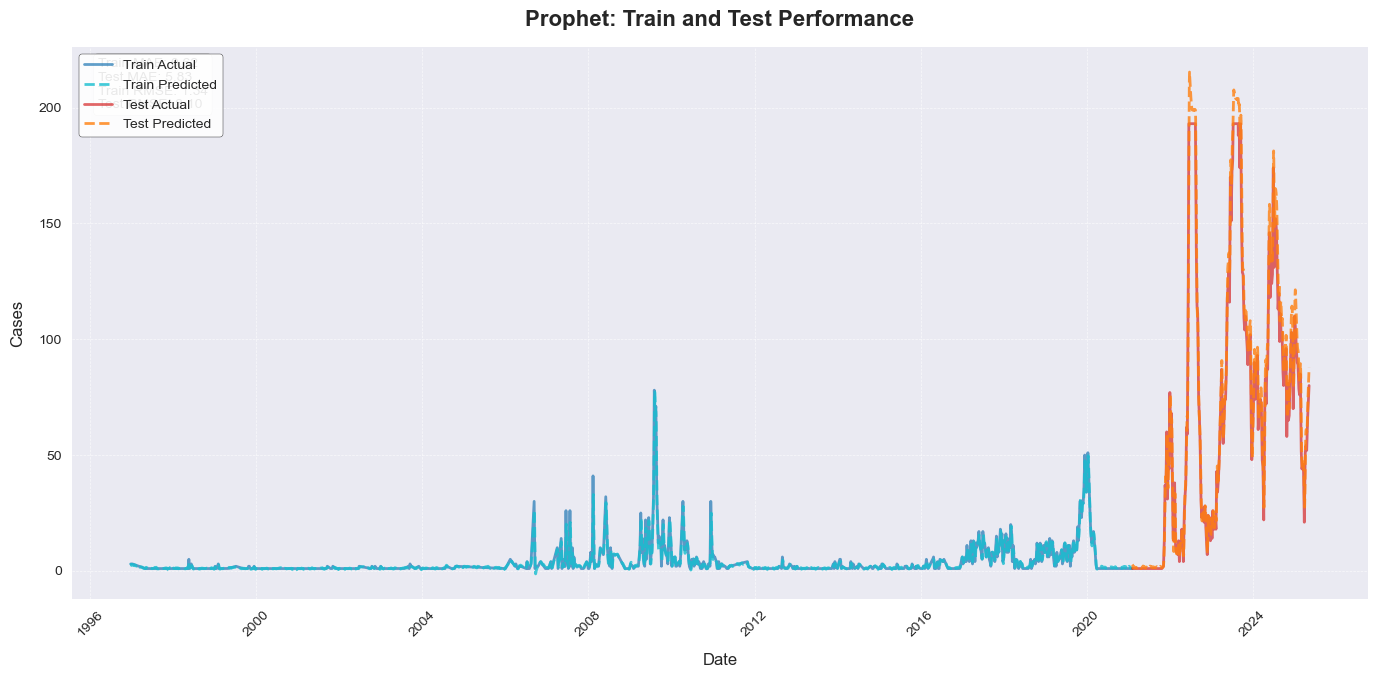

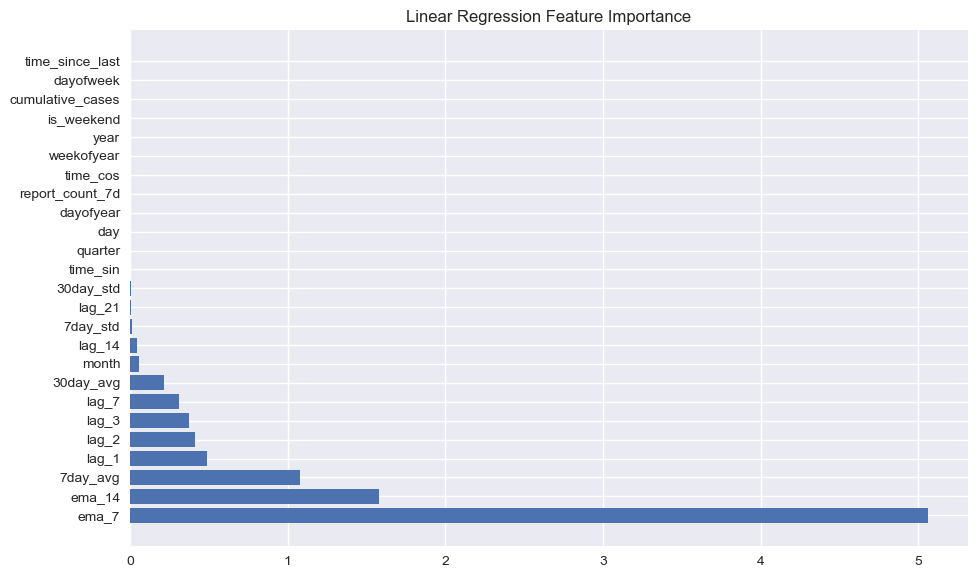


Linear Regression Evaluation:
  MAE: 0.33
  MSE: 0.22
  RMSE: 0.47
  MAPE: 0.80%
  SMAPE: 0.81%
  R2: 1.00
Linear Regression - Train MAE: 0.04, Test MAE: 0.33
Linear Regression - Train RMSE: 0.09, Test RMSE: 0.47


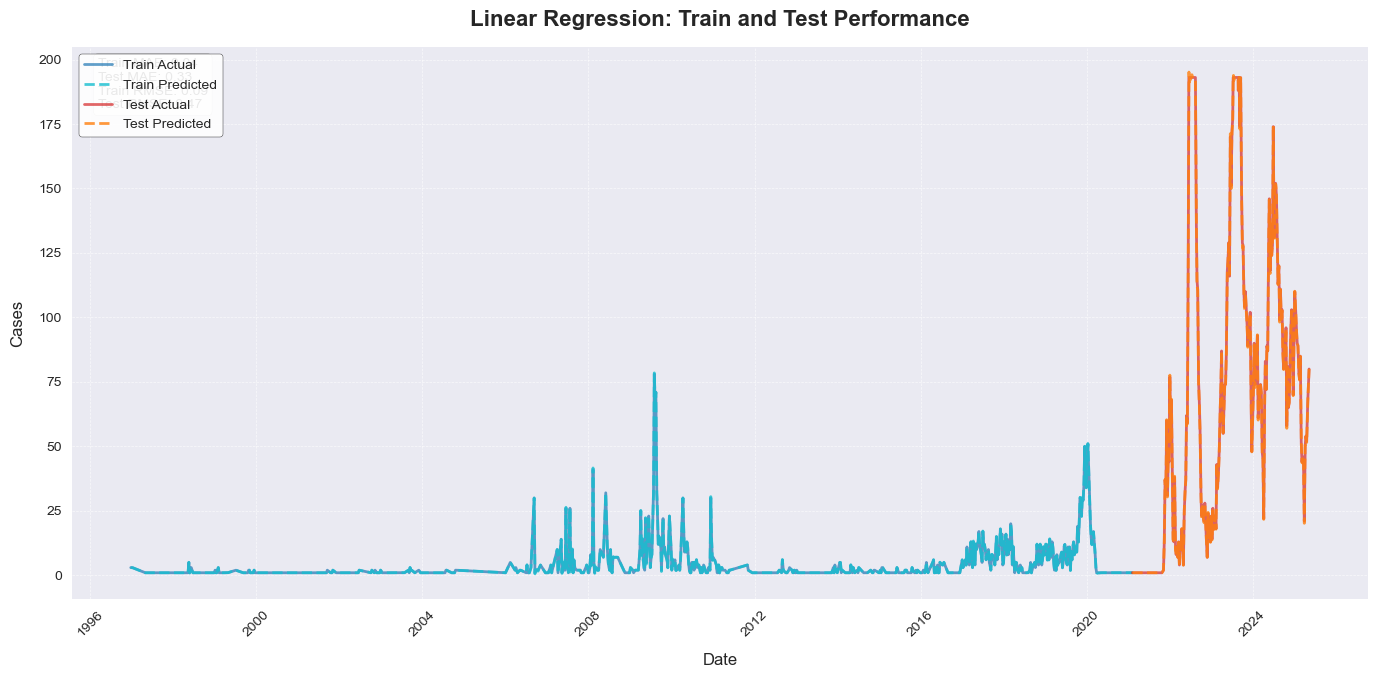

Running ACO for feature selection...
Iteration 0, Best MAE: 0.06
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05


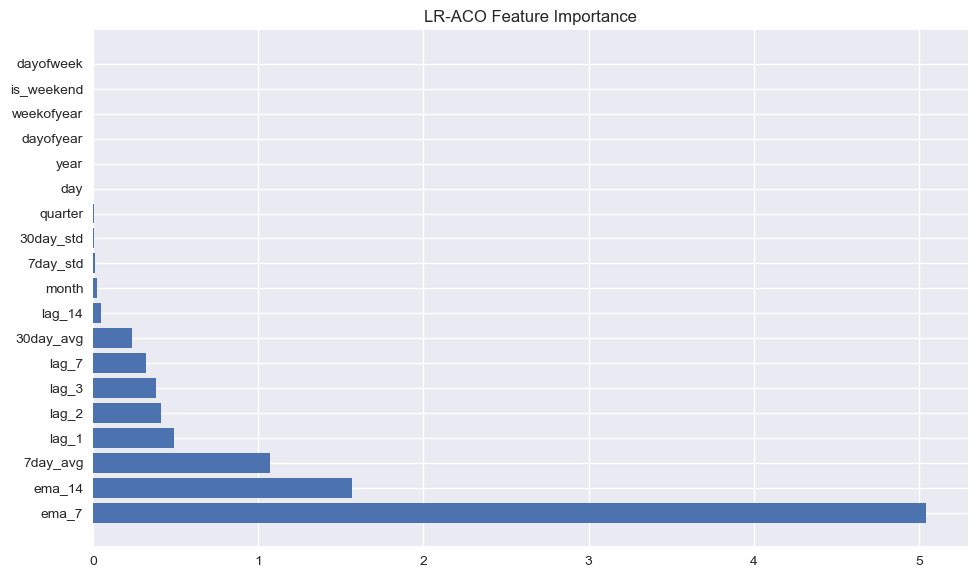


LR-ACO Evaluation:
  MAE: 0.33
  MSE: 0.21
  RMSE: 0.46
  MAPE: 1.01%
  SMAPE: 1.01%
  R2: 1.00
LR-ACO - Train MAE: 0.04, Test MAE: 0.33
LR-ACO - Train RMSE: 0.09, Test RMSE: 0.46


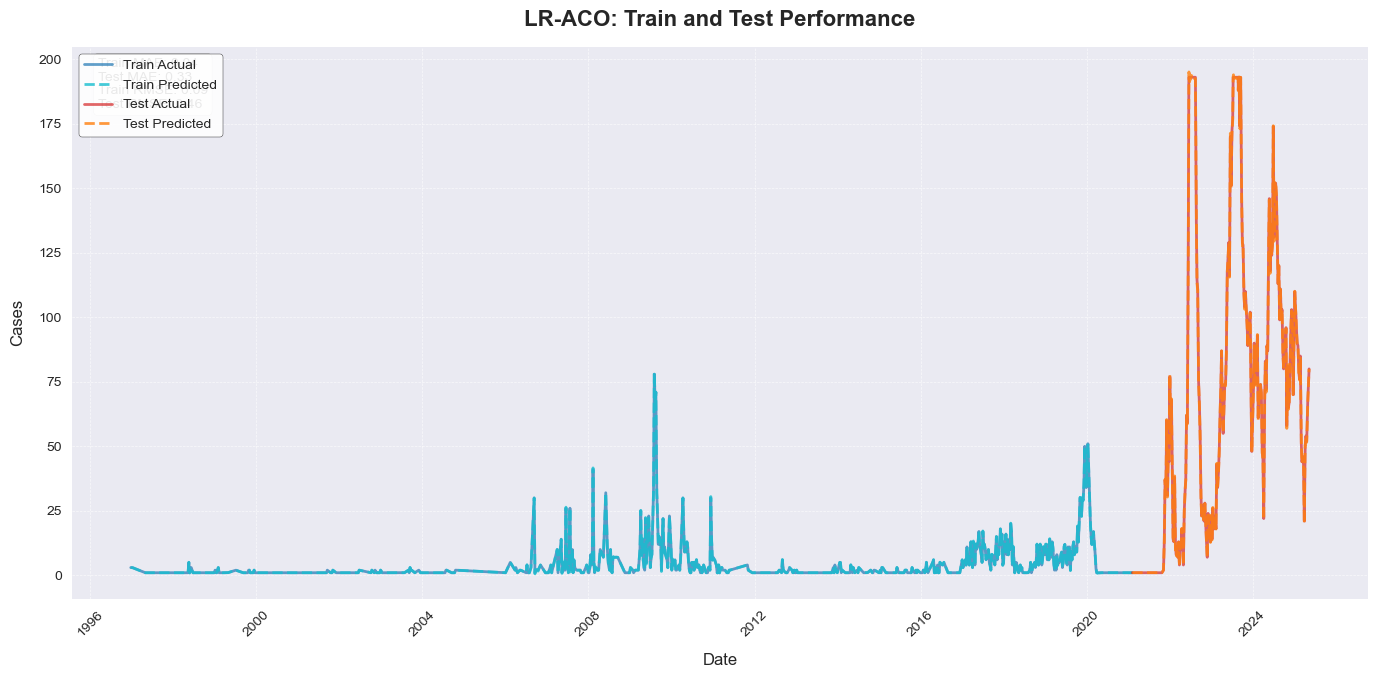

Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.10
Iteration 10, Best MAE: 0.08
Iteration 20, Best MAE: 0.08
Iteration 30, Best MAE: 0.08
Iteration 40, Best MAE: 0.08


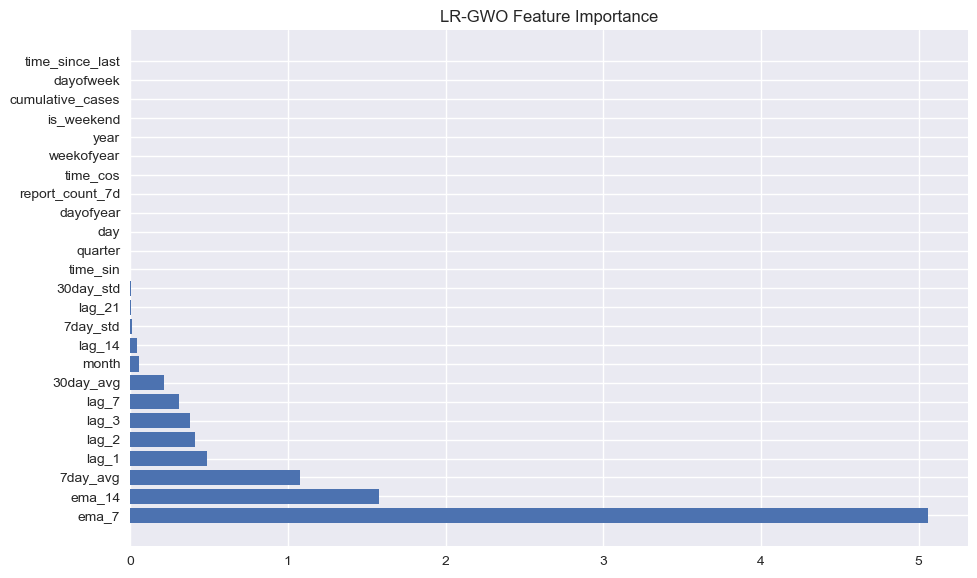


LR-GWO Evaluation:
  MAE: 0.33
  MSE: 0.22
  RMSE: 0.47
  MAPE: 0.80%
  SMAPE: 0.81%
  R2: 1.00
LR-GWO - Train MAE: 0.04, Test MAE: 0.33
LR-GWO - Train RMSE: 0.09, Test RMSE: 0.47


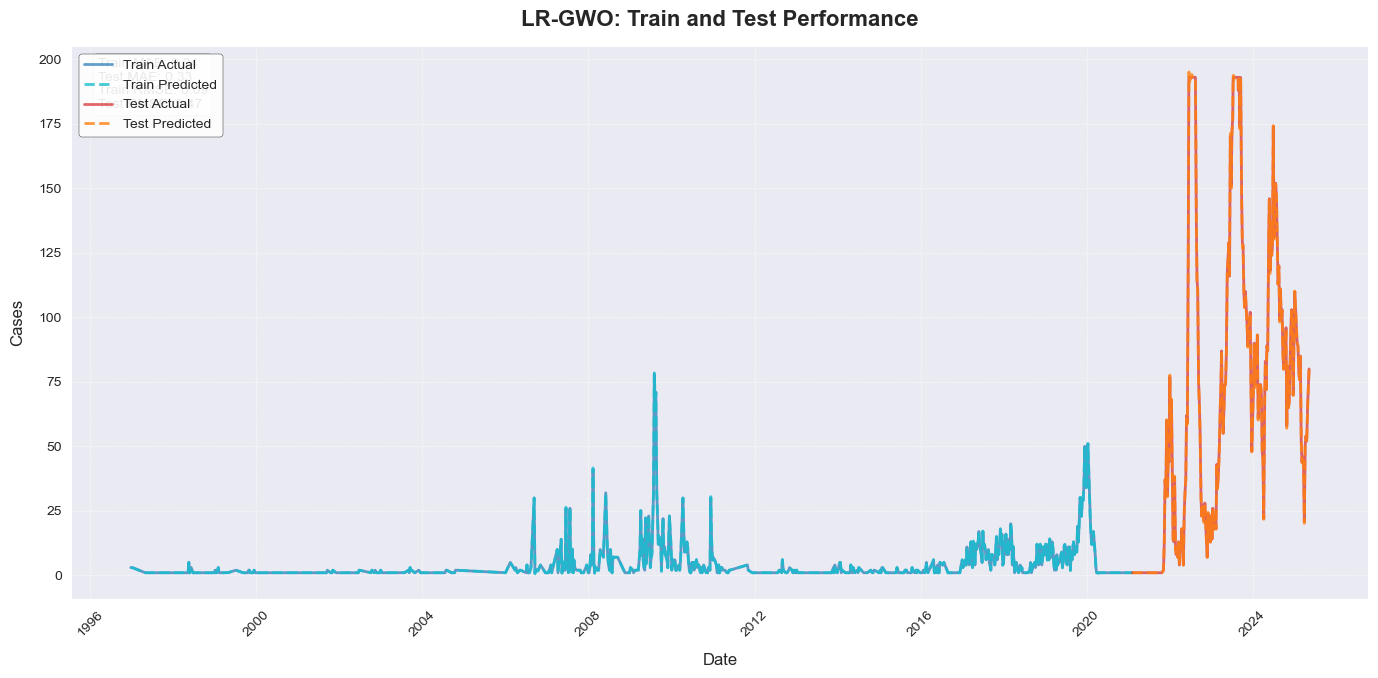

Running ACO for feature selection...
Iteration 0, Best MAE: 0.05
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.07
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05


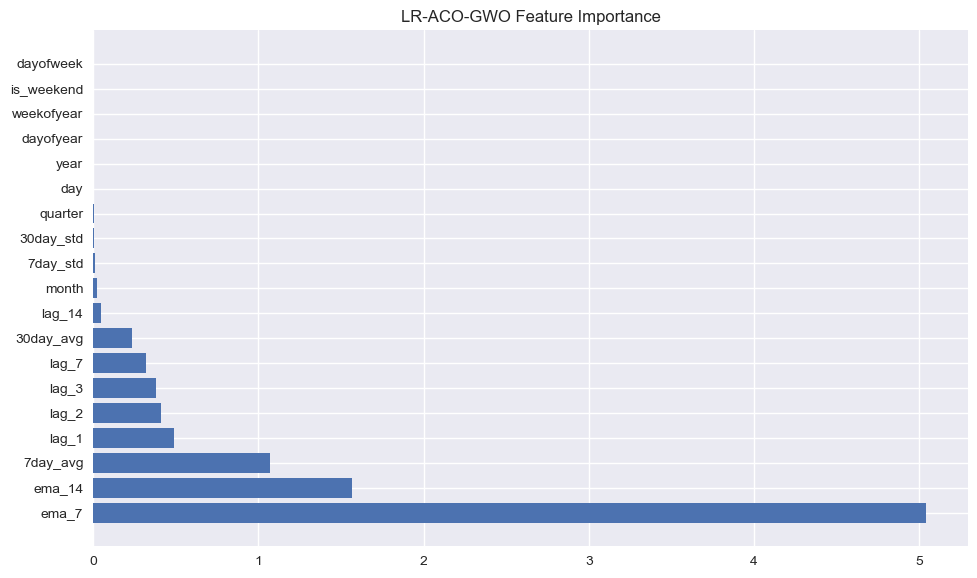


LR-ACO-GWO Evaluation:
  MAE: 0.33
  MSE: 0.21
  RMSE: 0.46
  MAPE: 1.01%
  SMAPE: 1.01%
  R2: 1.00
LR-ACO-GWO - Train MAE: 0.04, Test MAE: 0.33
LR-ACO-GWO - Train RMSE: 0.09, Test RMSE: 0.46


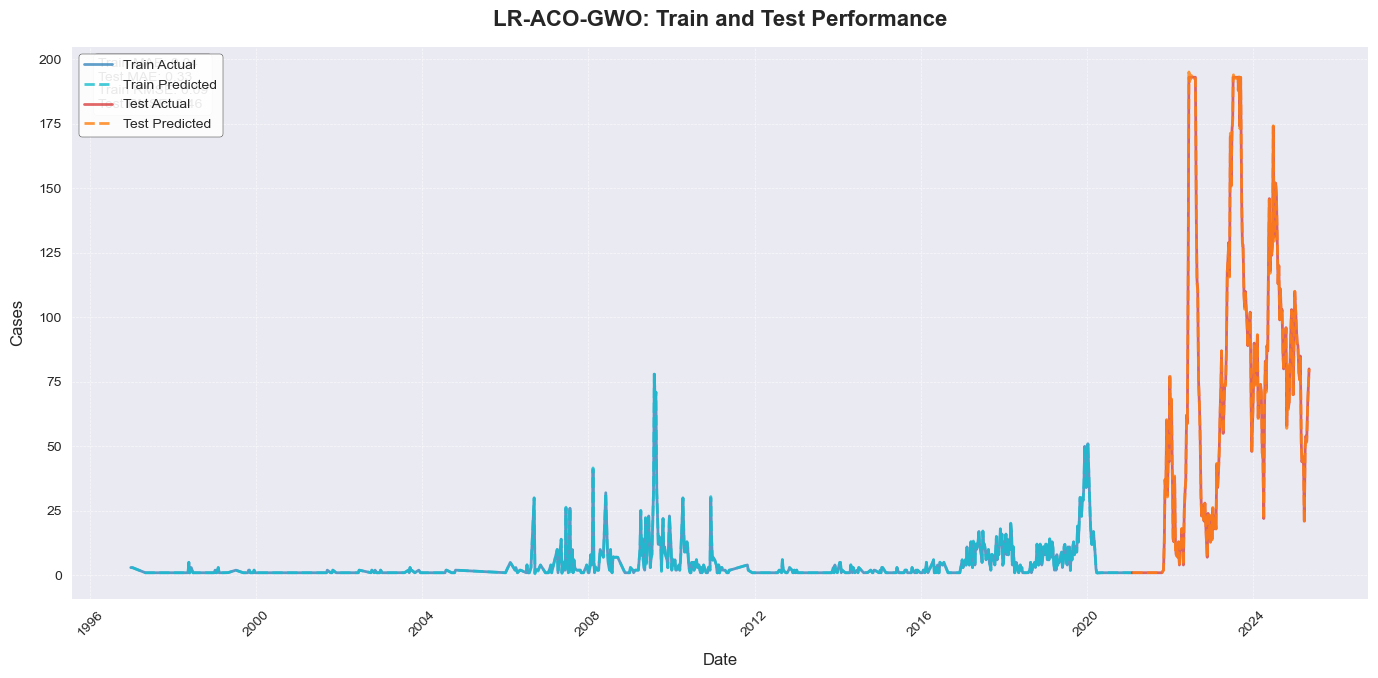


LR Bagging Ensemble Evaluation:
  MAE: 0.40
  MSE: 0.38
  RMSE: 0.61
  MAPE: 1.00%
  SMAPE: 1.00%
  R2: 1.00
LR Bagging Ensemble - Train MAE: 0.05, Test MAE: 0.40
LR Bagging Ensemble - Train RMSE: 0.13, Test RMSE: 0.61


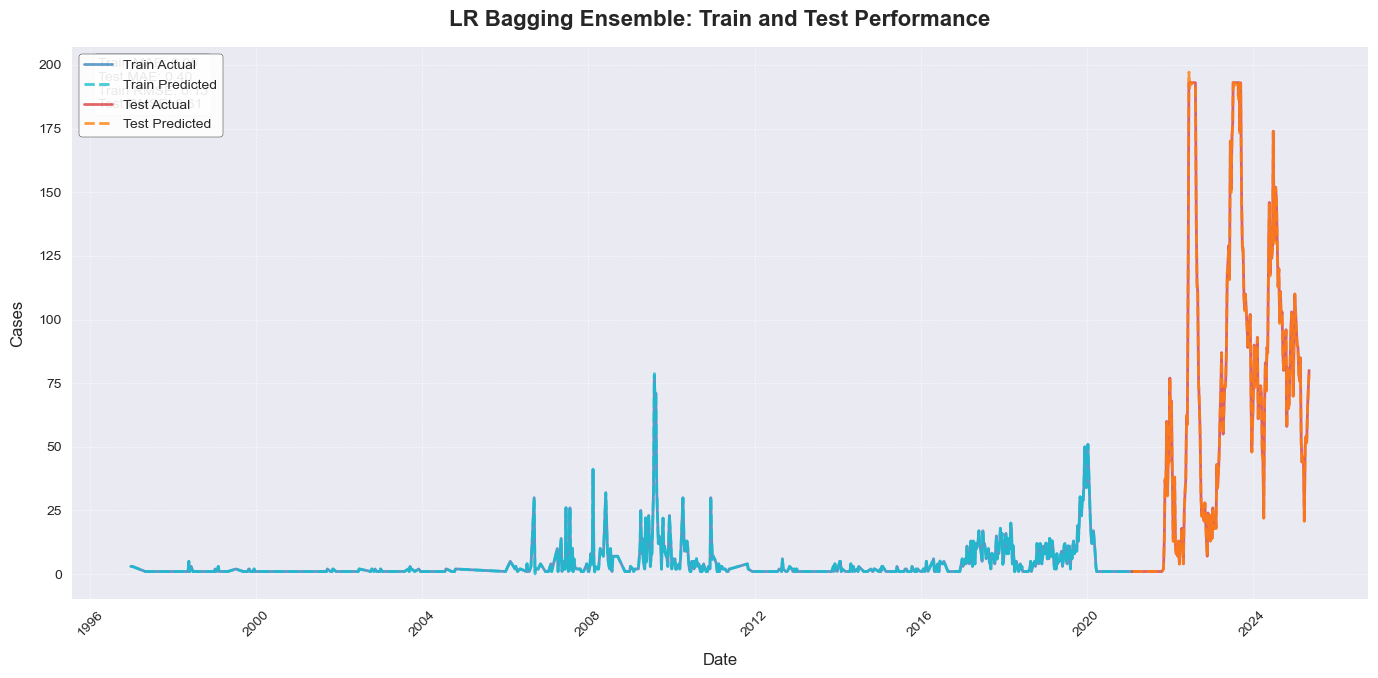

Running ACO for feature selection...
Iteration 0, Best MAE: 0.06
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Selected features by ACO: ['year', 'dayofyear', 'month', 'dayofweek', 'day', 'quarter', 'weekofyear', 'is_weekend', '30day_avg', '7day_avg', '7day_std', 'lag_2', 'lag_1', '30day_std', 'lag_7', 'ema_7', 'lag_3', 'lag_14', 'ema_14', 'time_since_last']
Running GWO for hyperparameter optimization...
Iteration 0, Best MAE: 0.05
Iteration 10, Best MAE: 0.05
Iteration 20, Best MAE: 0.05
Iteration 30, Best MAE: 0.05
Iteration 40, Best MAE: 0.05
Optimized hyperparameters: {'n_estimators': 144.424043667905, 'max_samples': 0.5}


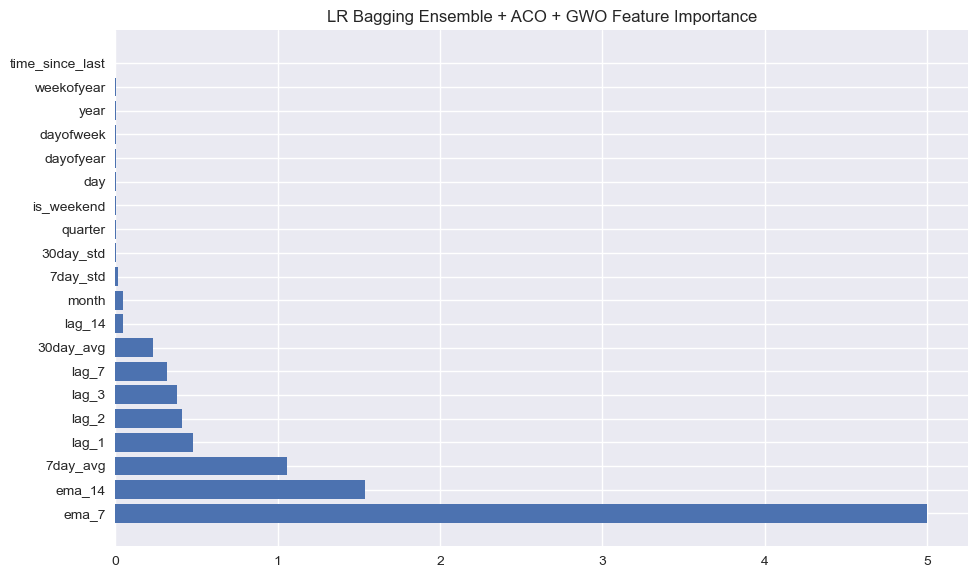


LR Bagging Ensemble + ACO + GWO Evaluation:
  MAE: 0.33
  MSE: 0.21
  RMSE: 0.46
  MAPE: 0.99%
  SMAPE: 0.99%
  R2: 1.00
LR Bagging Ensemble + ACO + GWO - Train MAE: 0.04, Test MAE: 0.33
LR Bagging Ensemble + ACO + GWO - Train RMSE: 0.09, Test RMSE: 0.46


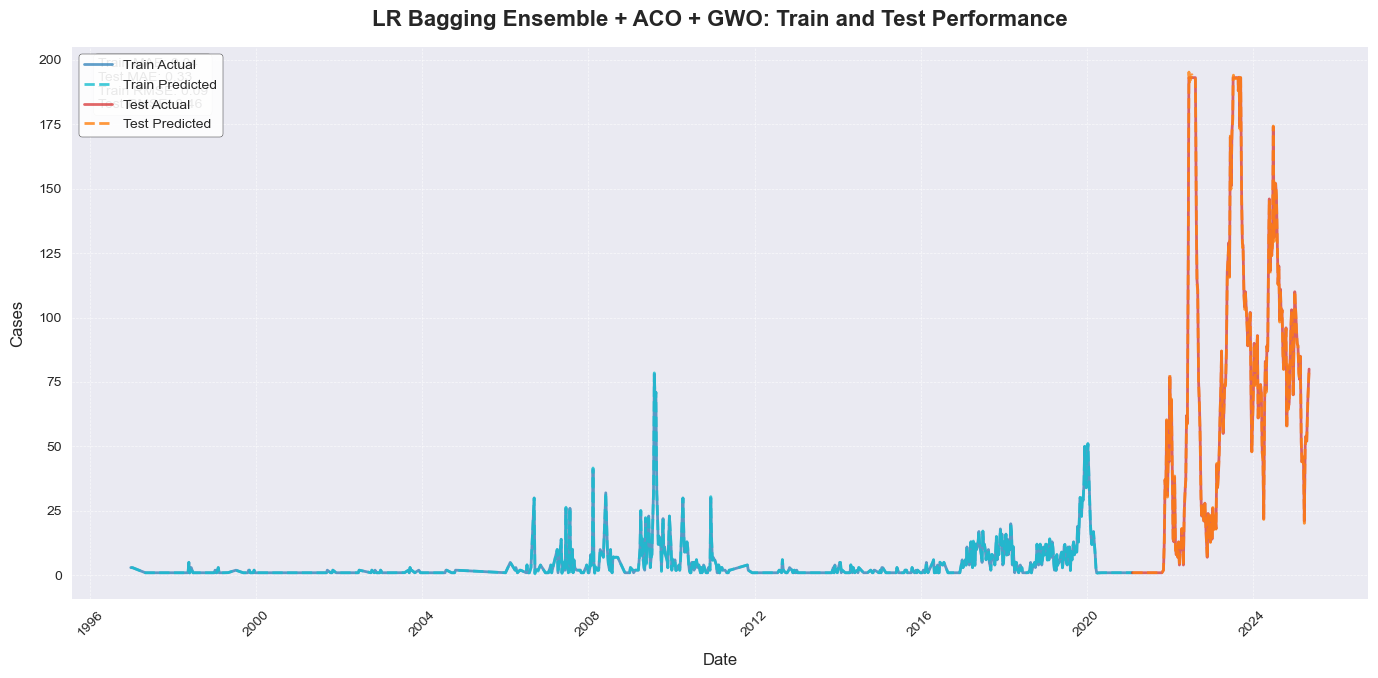

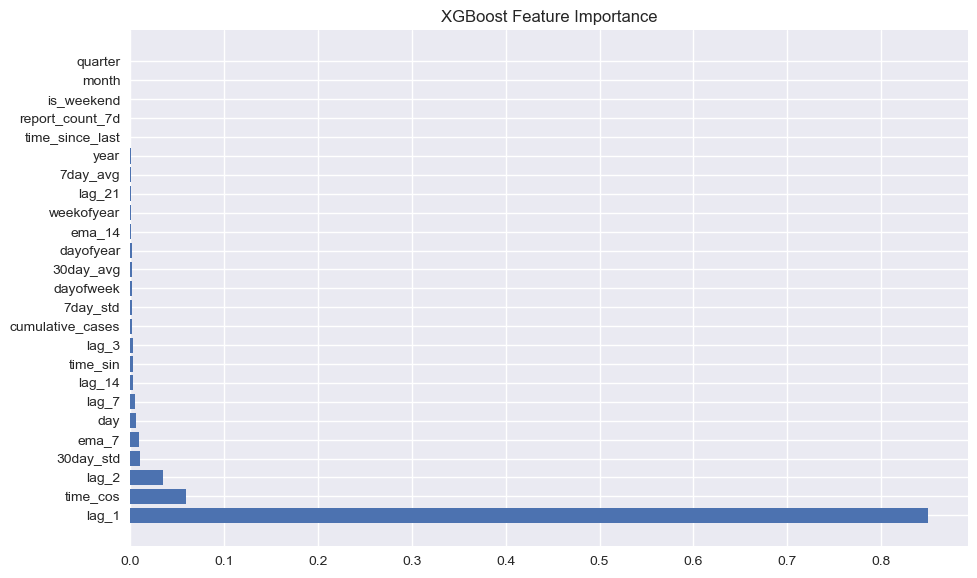


XGBoost Evaluation:
  MAE: 30.58
  MSE: 2564.81
  RMSE: 50.64
  MAPE: 25.59%
  SMAPE: 33.84%
  R2: 0.24
XGBoost - Train MAE: 0.15, Test MAE: 30.58
XGBoost - Train RMSE: 0.34, Test RMSE: 50.64


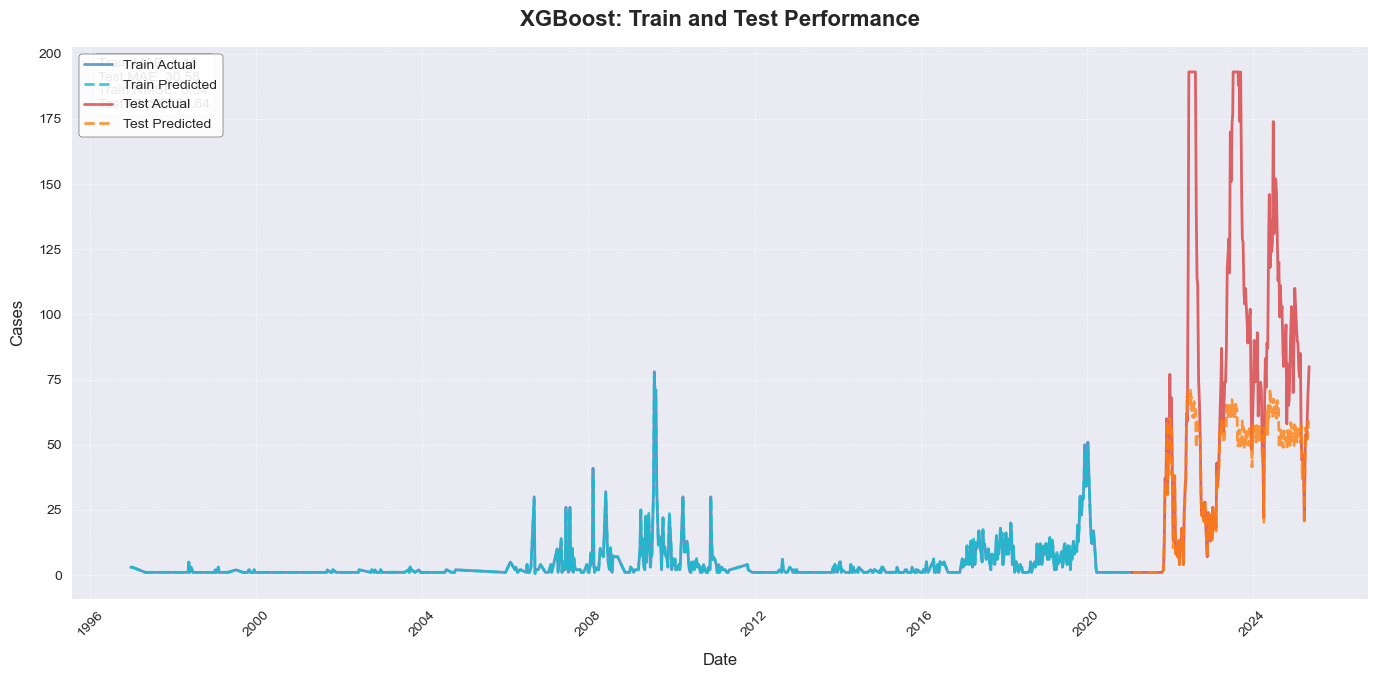


LightGBM Evaluation:
  MAE: 29.51
  MSE: 2402.32
  RMSE: 49.01
  MAPE: 24.68%
  SMAPE: 32.24%
  R2: 0.29
LightGBM - Train MAE: 0.15, Test MAE: 29.51
LightGBM - Train RMSE: 0.33, Test RMSE: 49.01


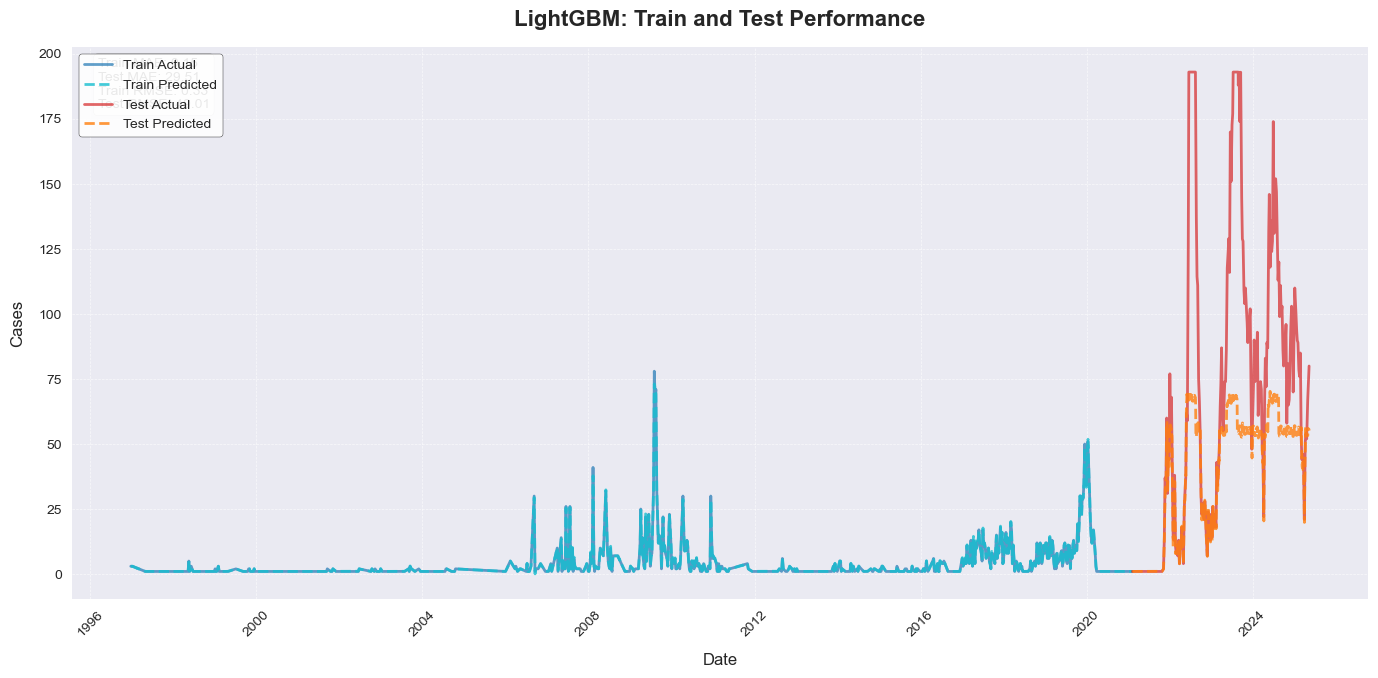

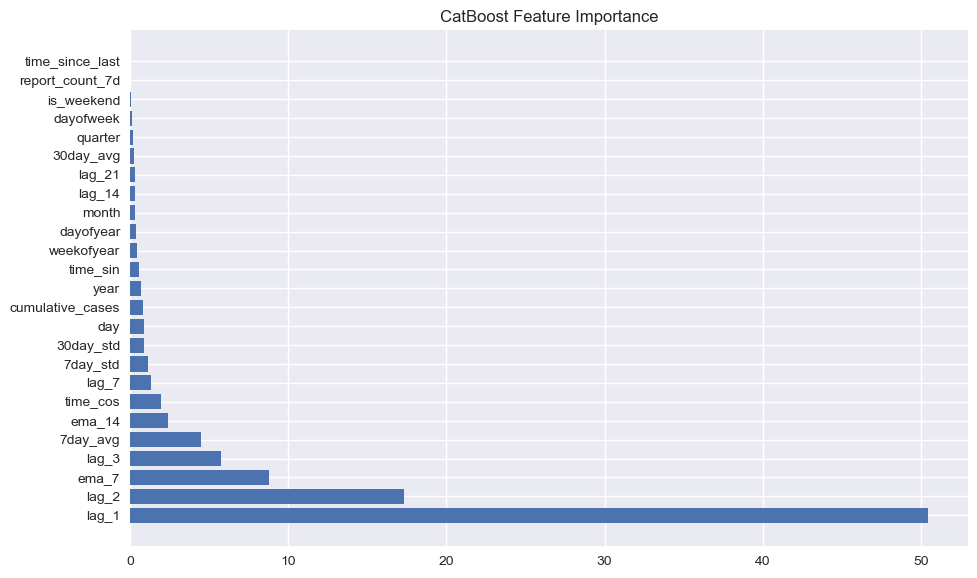


CatBoost Evaluation:
  MAE: 33.22
  MSE: 2888.56
  RMSE: 53.75
  MAPE: 28.51%
  SMAPE: 38.29%
  R2: 0.15
CatBoost - Train MAE: 0.18, Test MAE: 33.22
CatBoost - Train RMSE: 0.34, Test RMSE: 53.75


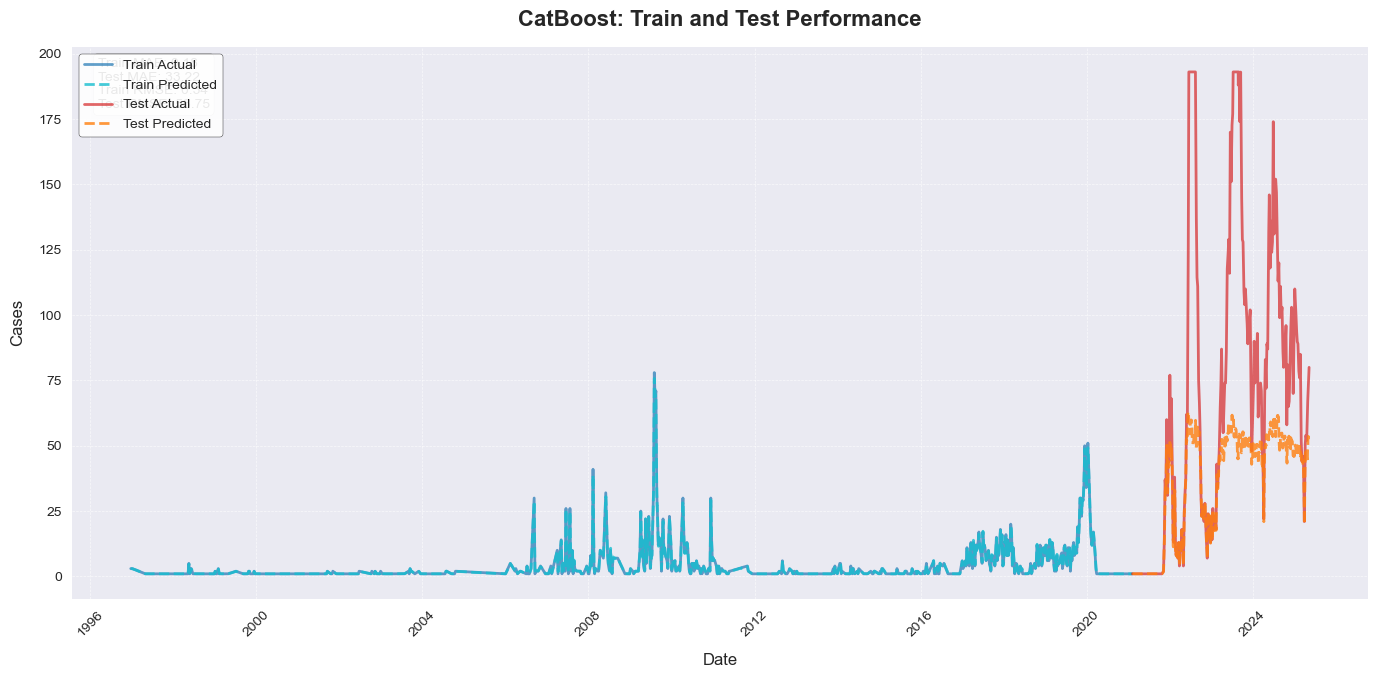

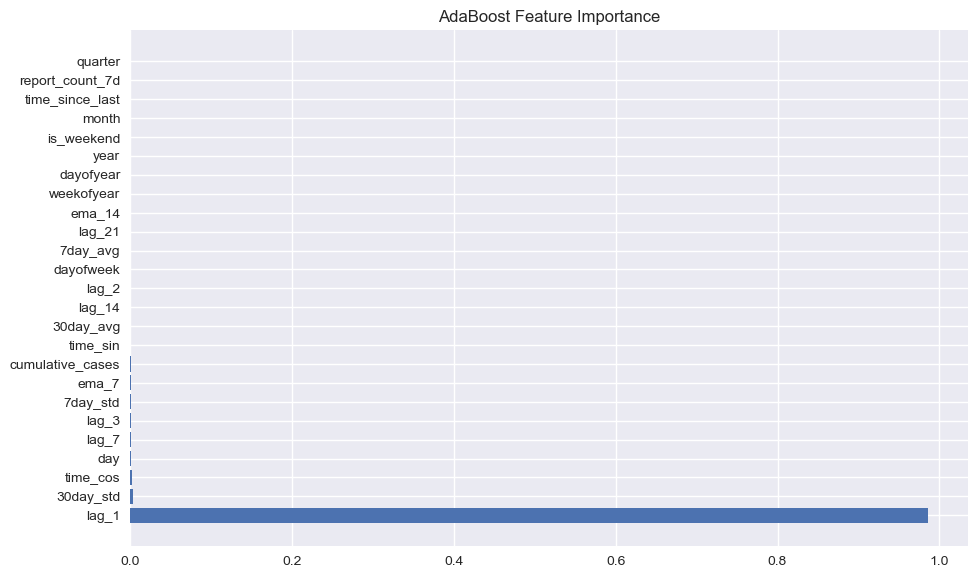


AdaBoost Evaluation:
  MAE: 26.23
  MSE: 2204.17
  RMSE: 46.95
  MAPE: 21.15%
  SMAPE: 27.32%
  R2: 0.35
AdaBoost - Train MAE: 0.22, Test MAE: 26.23
AdaBoost - Train RMSE: 0.44, Test RMSE: 46.95


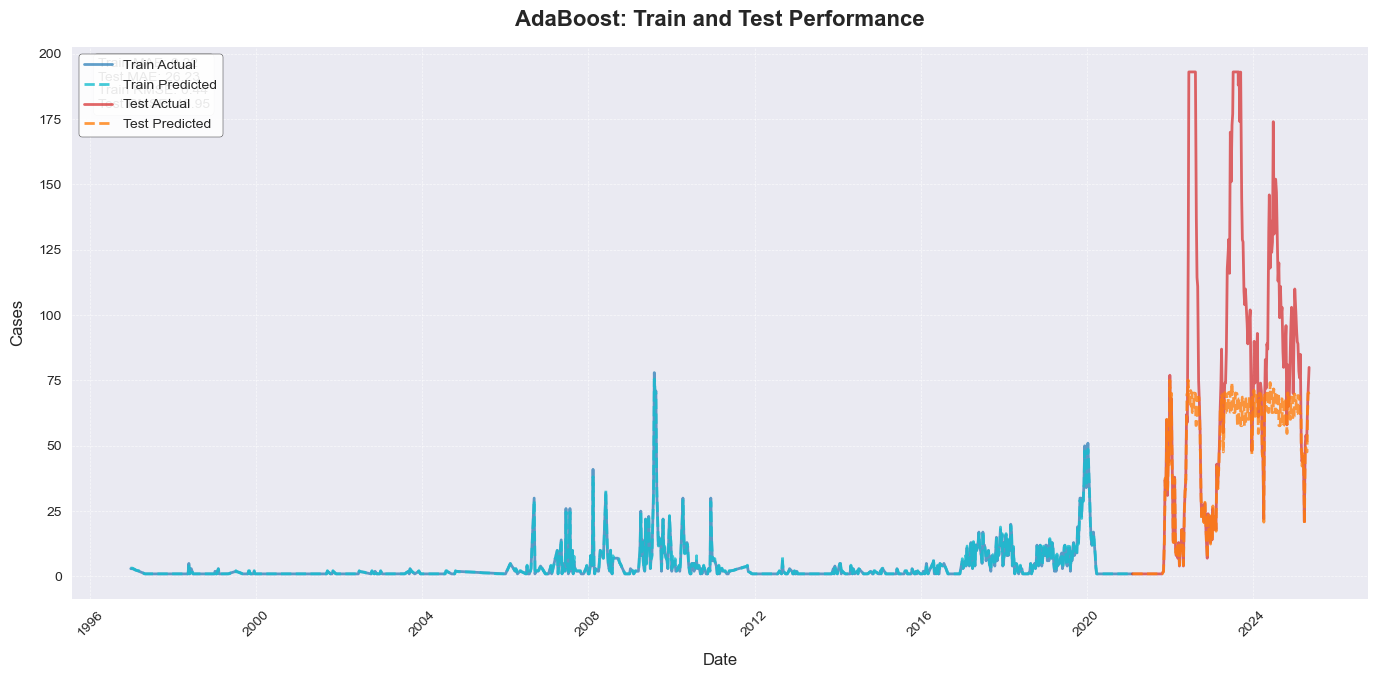


SVR Evaluation:
  MAE: 52.12
  MSE: 5569.26
  RMSE: 74.63
  MAPE: 103.31%
  SMAPE: 98.57%
  R2: -0.64
SVR - Train MAE: 0.05, Test MAE: 52.12
SVR - Train RMSE: 0.06, Test RMSE: 74.63


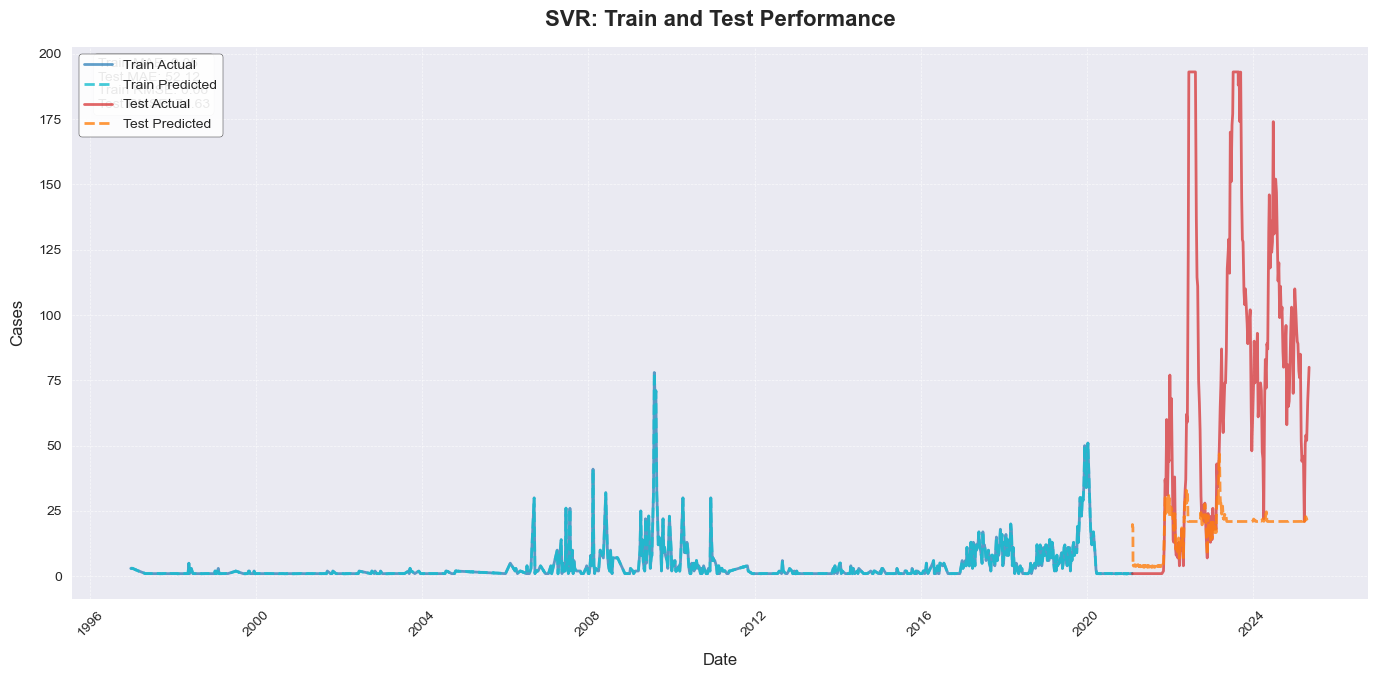


KNN Evaluation:
  MAE: 29.16
  MSE: 2361.40
  RMSE: 48.59
  MAPE: 30.80%
  SMAPE: 37.07%
  R2: 0.30
KNN - Train MAE: 0.31, Test MAE: 29.16
KNN - Train RMSE: 0.62, Test RMSE: 48.59


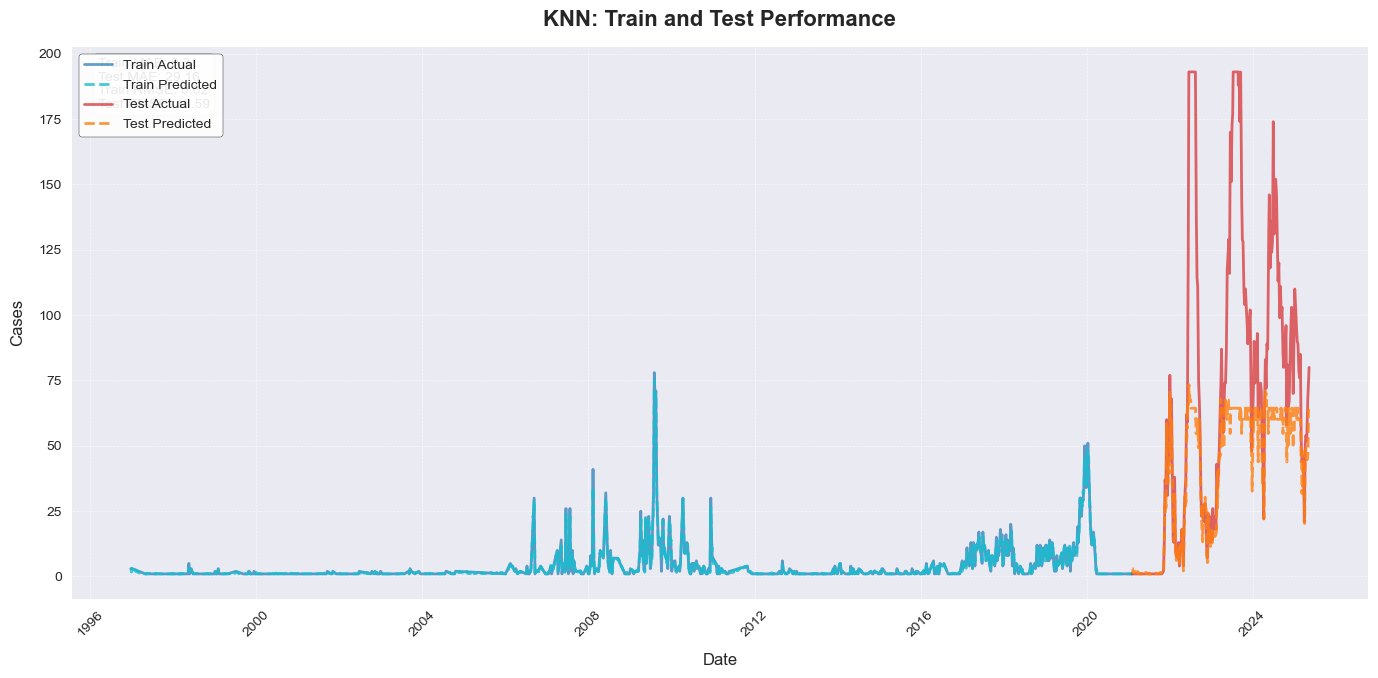

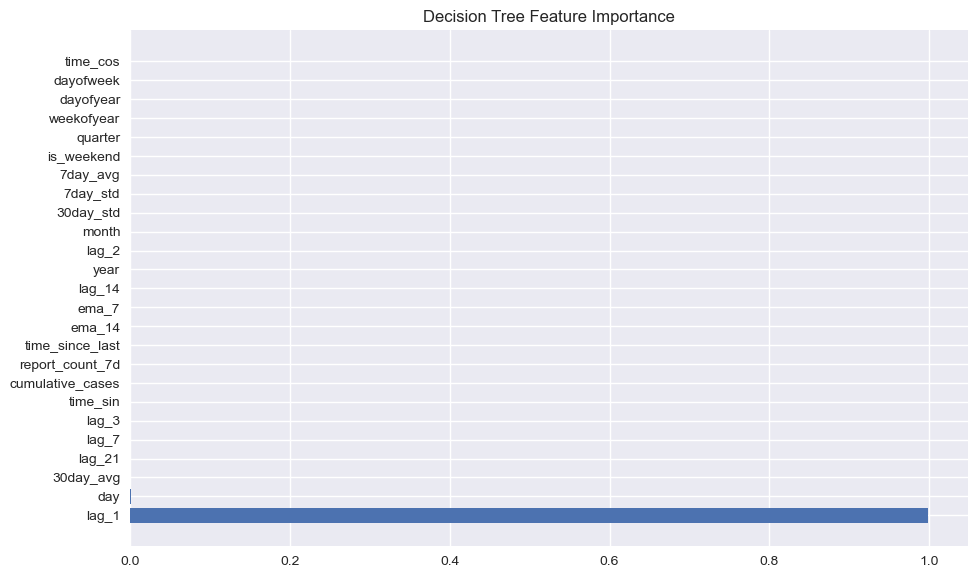


Decision Tree Evaluation:
  MAE: 25.94
  MSE: 2178.70
  RMSE: 46.68
  MAPE: 20.73%
  SMAPE: 26.70%
  R2: 0.36
Decision Tree - Train MAE: 0.25, Test MAE: 25.94
Decision Tree - Train RMSE: 0.56, Test RMSE: 46.68


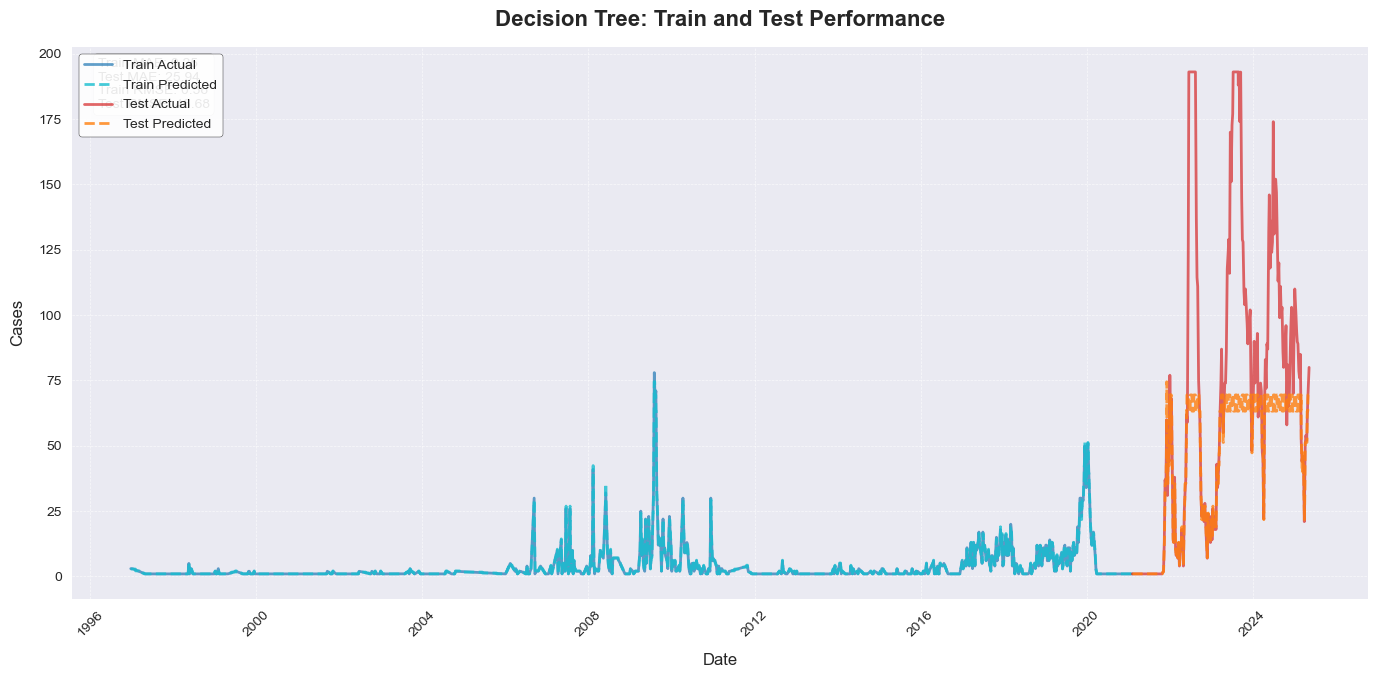

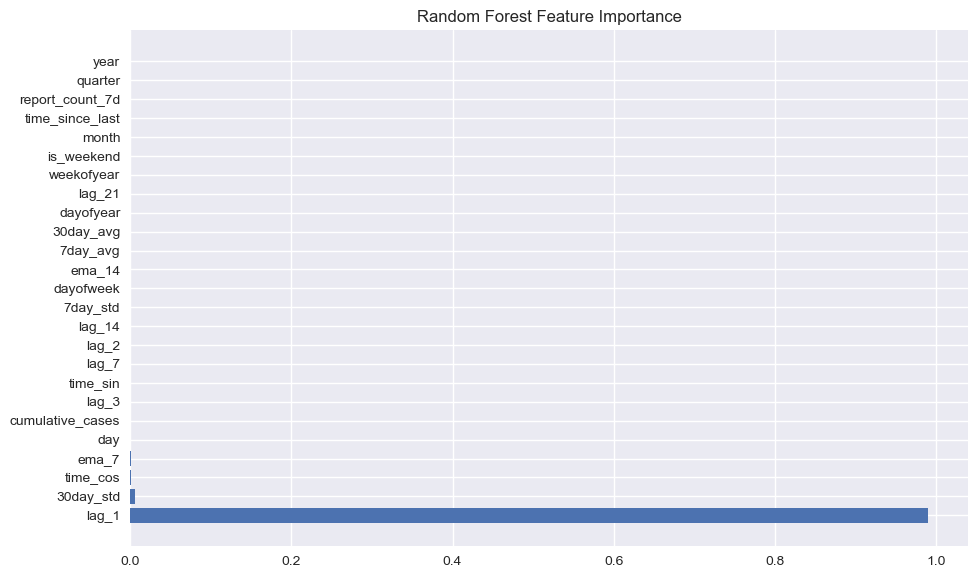


Random Forest Evaluation:
  MAE: 27.05
  MSE: 2274.76
  RMSE: 47.69
  MAPE: 21.69%
  SMAPE: 28.16%
  R2: 0.33
Random Forest - Train MAE: 0.21, Test MAE: 27.05
Random Forest - Train RMSE: 0.50, Test RMSE: 47.69


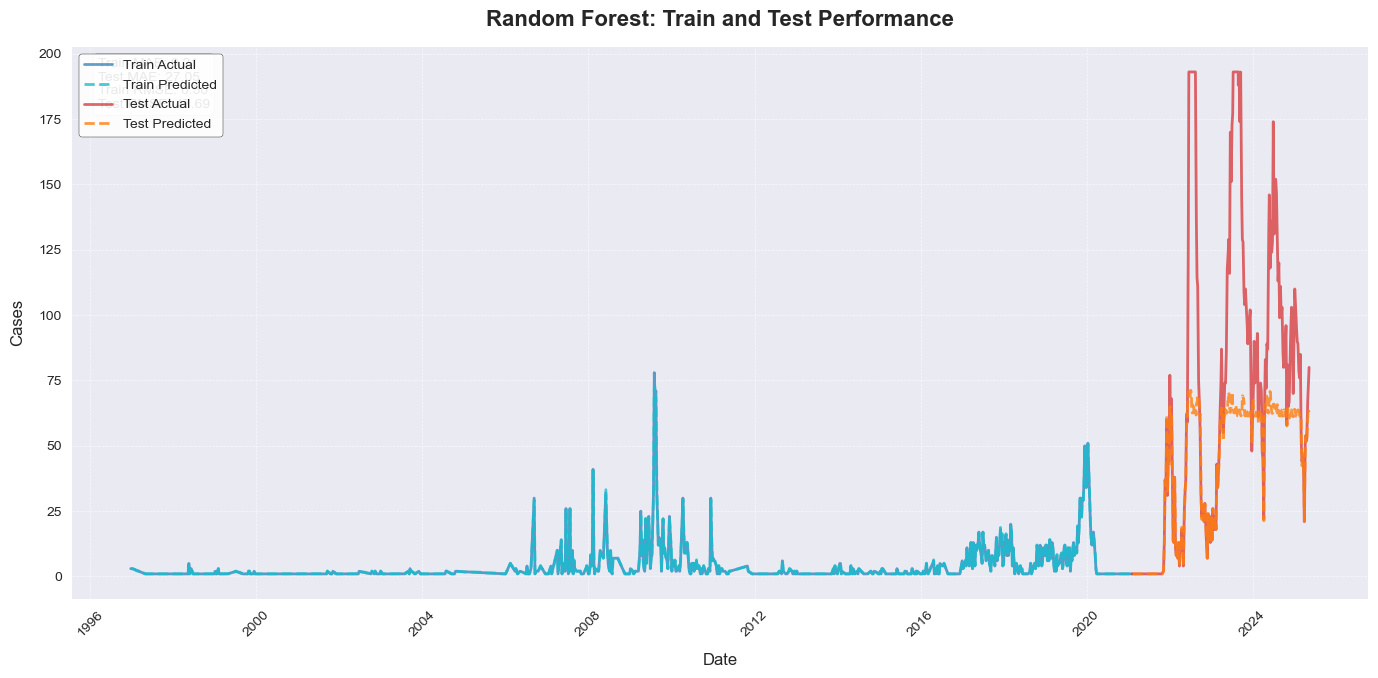


Voting Regressor Evaluation:
  MAE: 0.92
  MSE: 1.67
  RMSE: 1.29
  MAPE: 1.52%
  SMAPE: 1.54%
  R2: 1.00
Voting Regressor - Train MAE: 0.09, Test MAE: 0.92
Voting Regressor - Train RMSE: 0.22, Test RMSE: 1.29


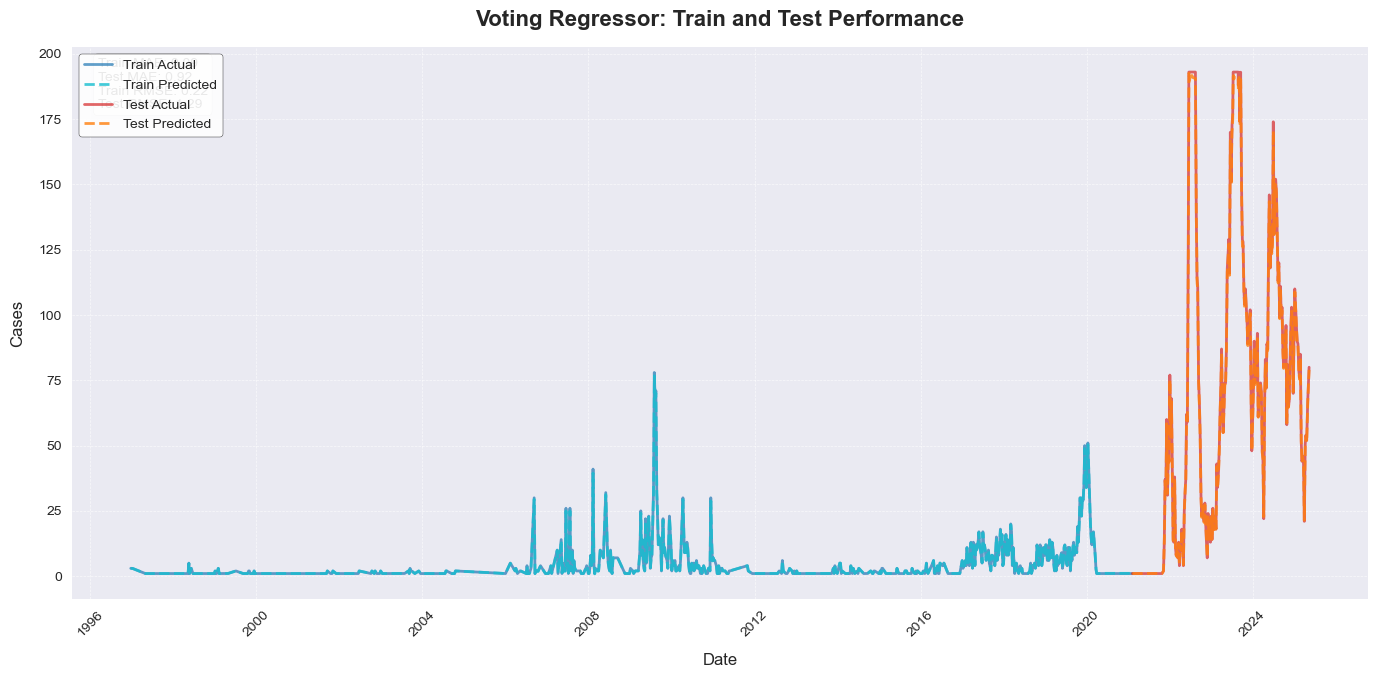


XGBoost + LR Evaluation:
  MAE: 26.91
  MSE: 2105.43
  RMSE: 45.88
  MAPE: 27.05%
  SMAPE: 33.46%
  R2: 0.38
XGBoost + LR - Train MAE: 0.47, Test MAE: 26.91
XGBoost + LR - Train RMSE: 0.99, Test RMSE: 45.88


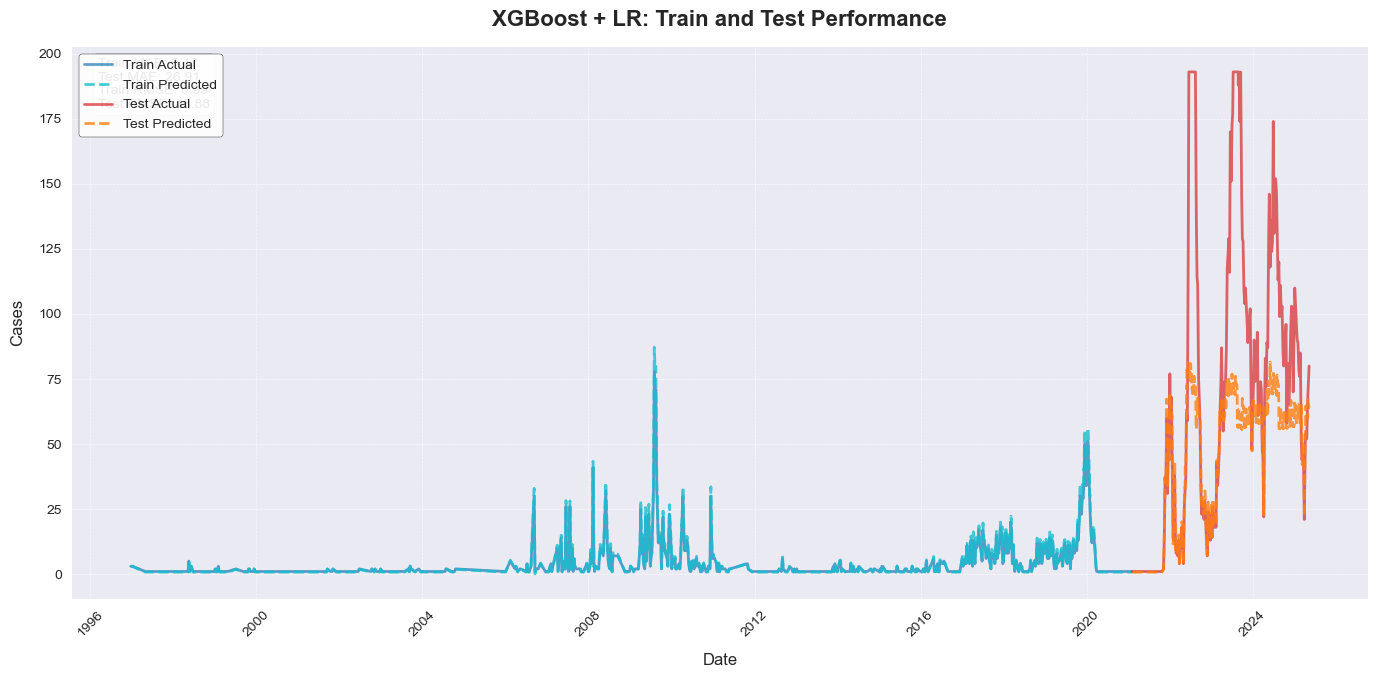

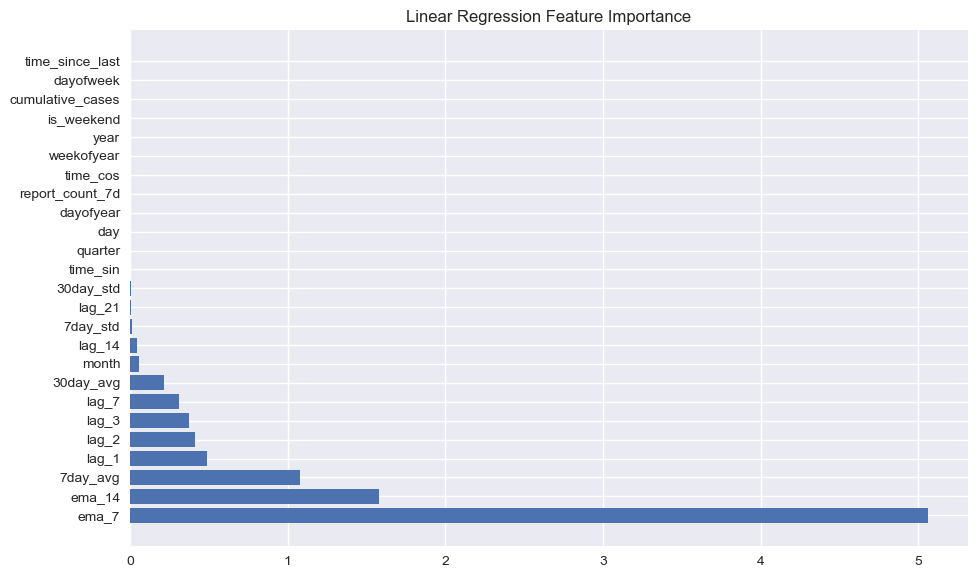


Prophet + LR Evaluation:
  MAE: 1.09
  MSE: 2.35
  RMSE: 1.53
  MAPE: 3.63%
  SMAPE: 3.51%
  R2: 1.00
Prophet + LR - Train MAE: 0.13, Test MAE: 1.09
Prophet + LR - Train RMSE: 0.28, Test RMSE: 1.53


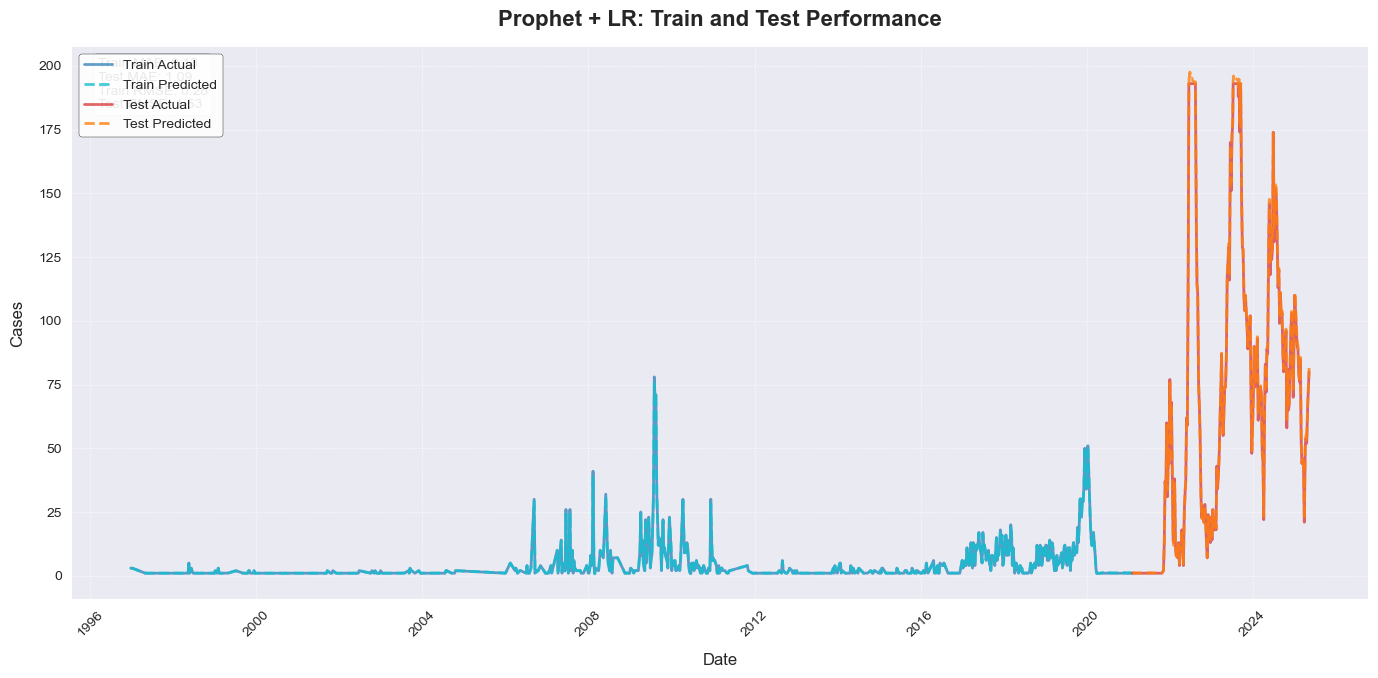


ANN Evaluation:
  MAE: 5.02
  MSE: 50.08
  RMSE: 7.08
  MAPE: 20.06%
  SMAPE: 16.09%
  R2: 0.99
ANN - Train MAE: 0.29, Test MAE: 5.02
ANN - Train RMSE: 0.61, Test RMSE: 7.08


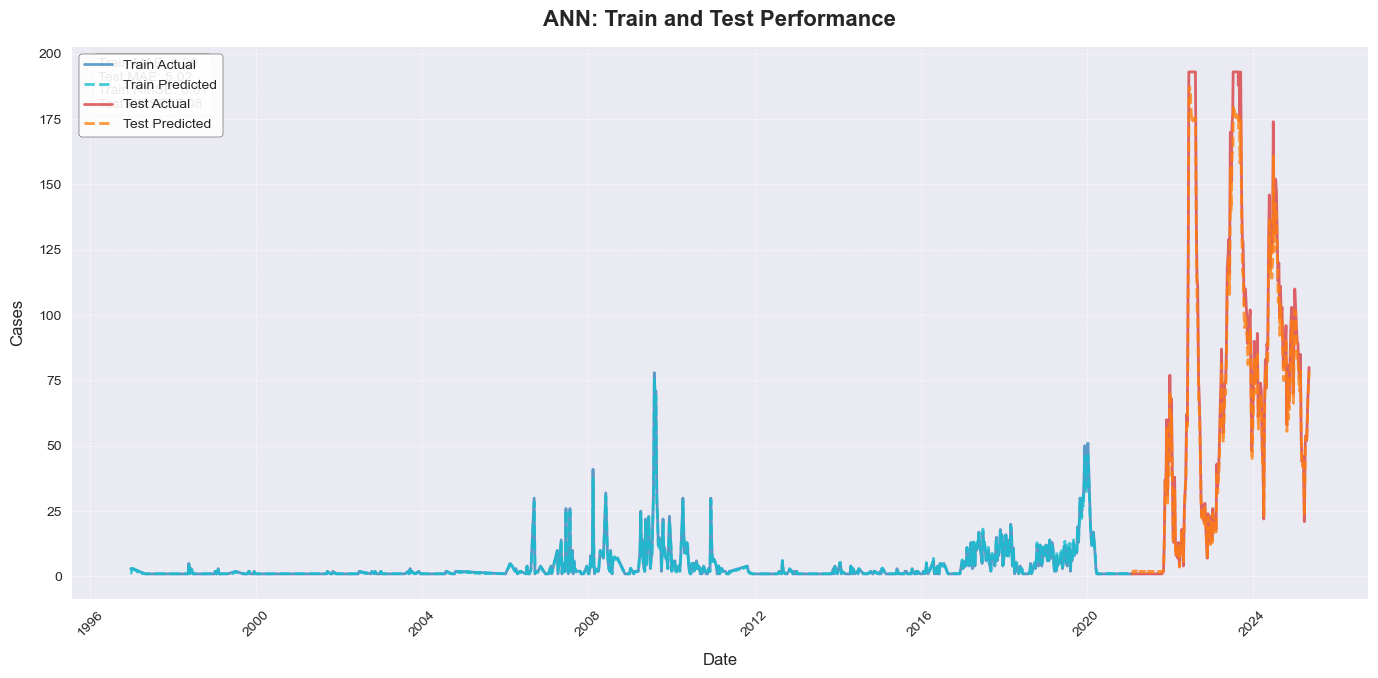

Training boosting base models with time-series cross-validation...
Fold 1: Train size 1472, Validation size 1468
Fold 2: Train size 2940, Validation size 1468
Fold 3: Train size 4408, Validation size 1468
Fold 4: Train size 5876, Validation size 1468
Fold 5: Train size 7344, Validation size 1468
Retraining boosting base models on full training set...

Boosting Stacking Evaluation:
  MAE: 24.78
  MSE: 1954.85
  RMSE: 44.21
  MAPE: 27.68%
  SMAPE: 31.38%
  R2: 0.42
Boosting Stacking - Train MAE: 0.65, Test MAE: 24.78
Boosting Stacking - Train RMSE: 0.91, Test RMSE: 44.21


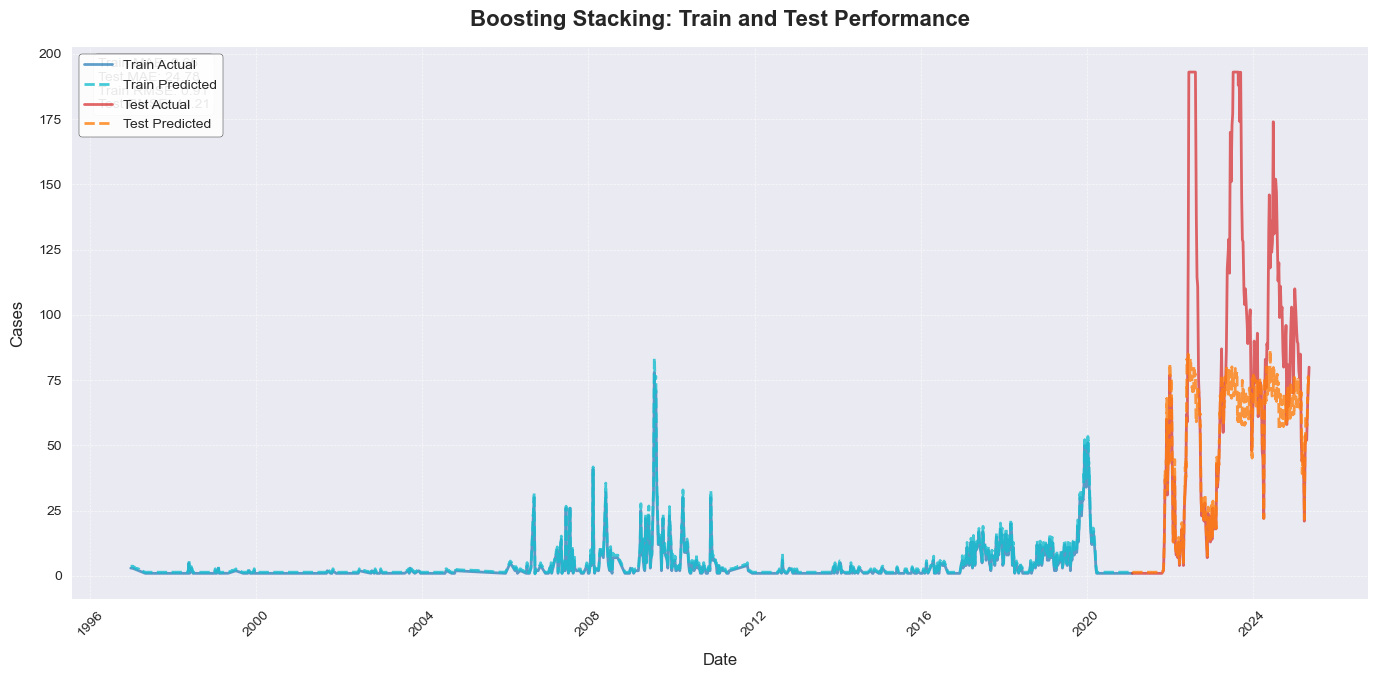

Training tree-based base models with time-series cross-validation...
Fold 1: Train size 1472, Validation size 1468
Fold 2: Train size 2940, Validation size 1468
Fold 3: Train size 4408, Validation size 1468
Fold 4: Train size 5876, Validation size 1468
Fold 5: Train size 7344, Validation size 1468
Retraining tree-based base models on full training set...

Tree Stacking Evaluation:
  MAE: 26.45
  MSE: 2136.65
  RMSE: 46.22
  MAPE: 30.43%
  SMAPE: 34.36%
  R2: 0.37
Tree Stacking - Train MAE: 0.70, Test MAE: 26.45
Tree Stacking - Train RMSE: 1.08, Test RMSE: 46.22


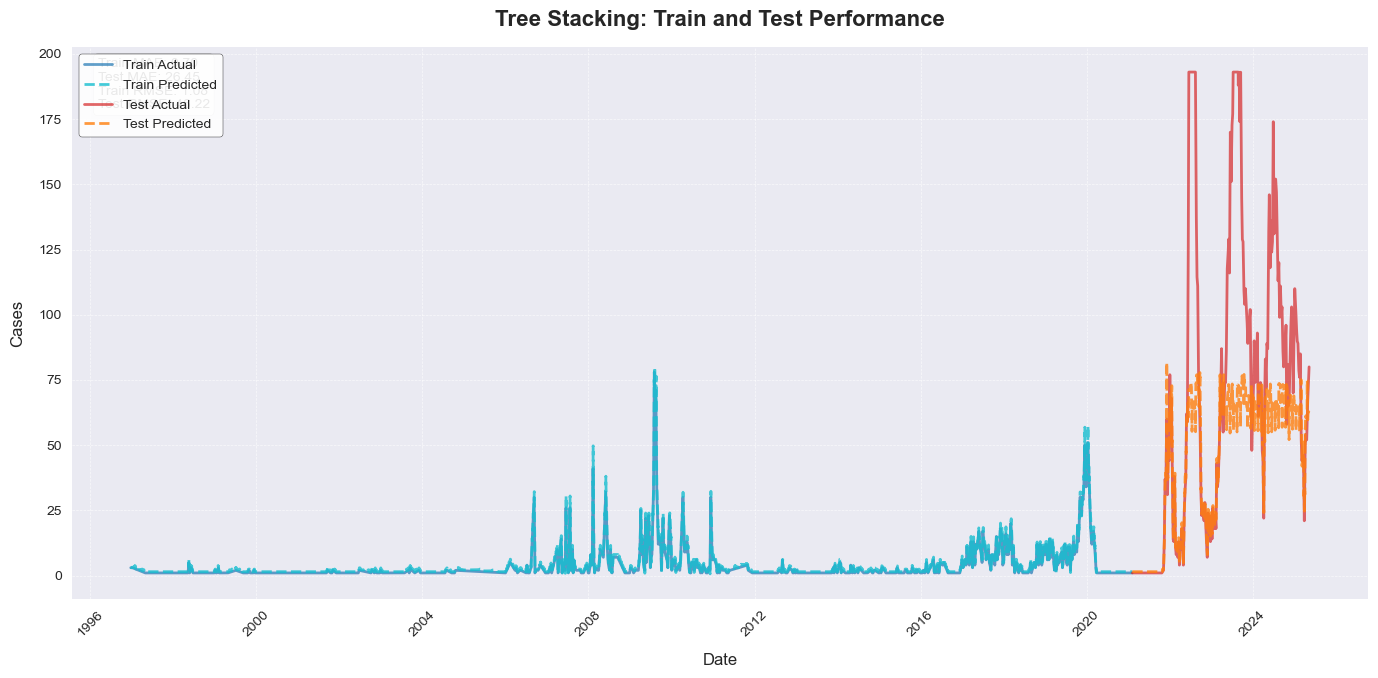


Model Performance Summary:
                          Model       MAE         MSE      RMSE       MAPE     SMAPE        R2
LR Bagging Ensemble + ACO + GWO  0.327797    0.207882  0.455941   0.988281  0.990071  0.999939
                     LR-ACO-GWO  0.331658    0.212172  0.460621   1.010563  1.012088  0.999937
                         LR-ACO  0.331708    0.212231  0.460685   1.010808  1.012333  0.999937
                         LR-GWO  0.332813    0.217968  0.466870   0.801689  0.808868  0.999936
              Linear Regression  0.332950    0.218130  0.467044   0.802787  0.809984  0.999936
            LR Bagging Ensemble  0.401834    0.375743  0.612979   0.996183  1.001570  0.999889
               Voting Regressor  0.918471    1.667440  1.291294   1.521026  1.539804  0.999508
                   Prophet + LR  1.089525    2.354335  1.534384   3.629093  3.505332  0.999306
                            ANN  5.015041   50.084147  7.077015  20.062447 16.093821  0.985228
                      

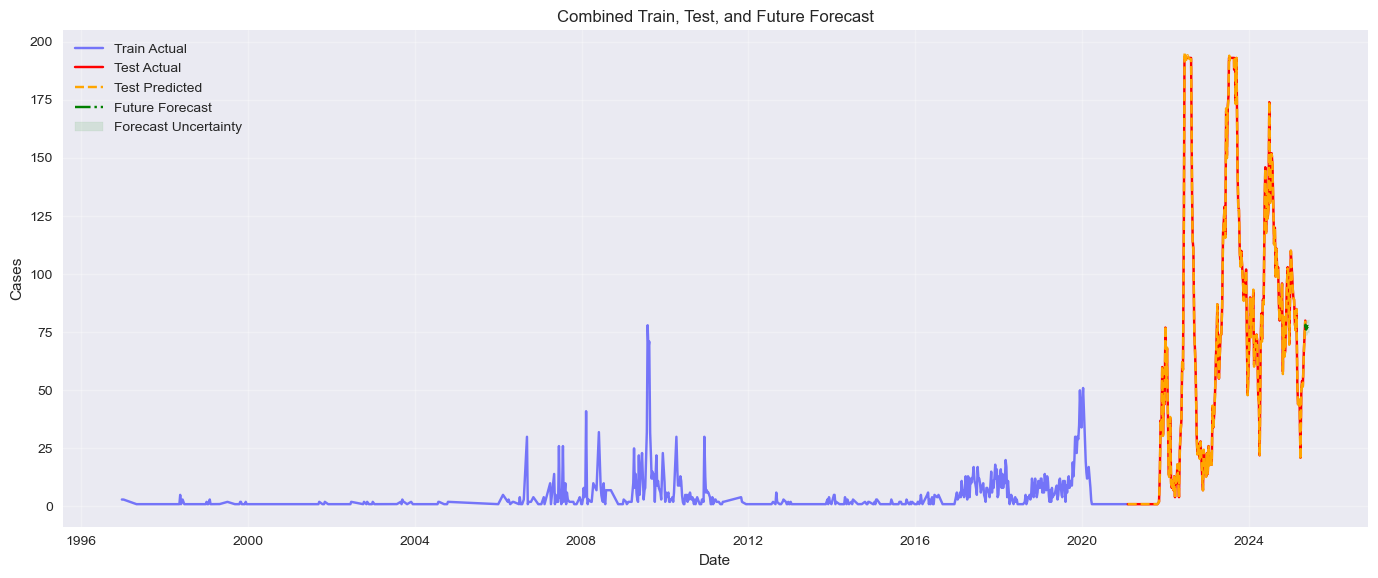

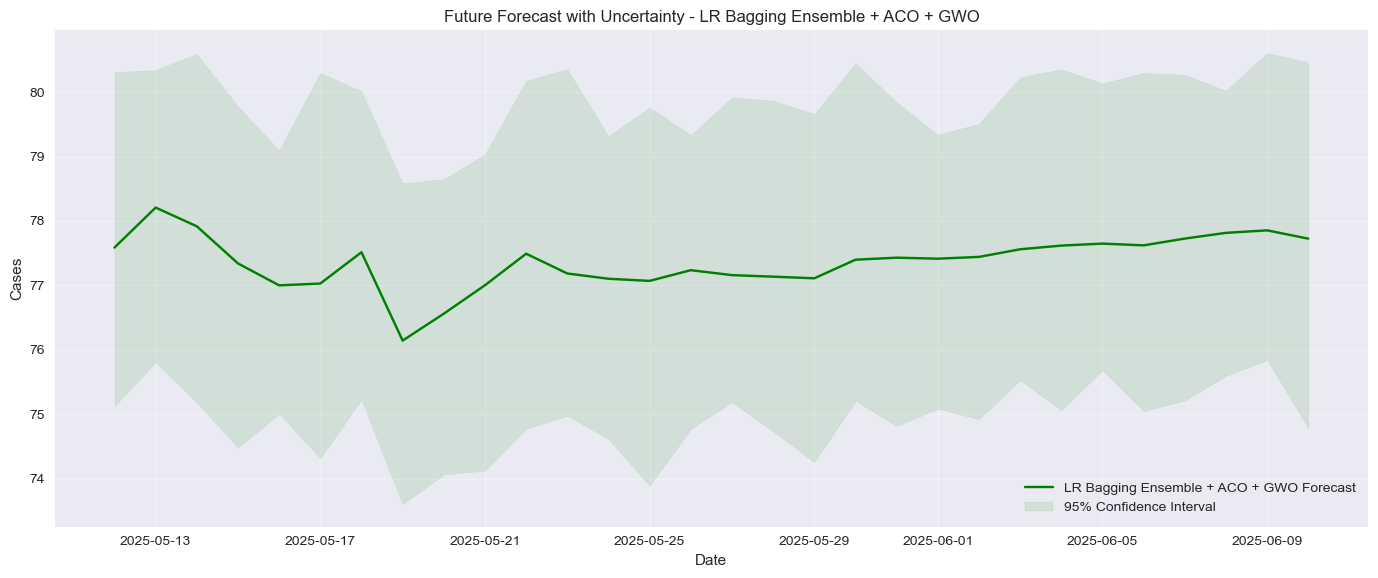


Future Forecasts for All Models:

Prophet Forecast:
        ds      yhat
2025-05-12 86.429309
2025-05-13 86.423882
2025-05-14 86.381691
2025-05-15 86.314660
2025-05-16 86.240071
2025-05-17 86.179337
2025-05-18 86.146891
2025-05-19 86.152617
2025-05-20 86.198180
2025-05-21 86.269143
2025-05-22 86.345016
2025-05-23 86.403702
2025-05-24 86.428921
2025-05-25 86.407832
2025-05-26 86.041148
2025-05-27 86.237950
2025-05-28 86.114620
2025-05-29 85.989013
2025-05-30 85.879473
2025-05-31 85.801617
2025-06-01 85.759217
2025-06-02 85.751293
2025-06-03 85.773649
2025-06-04 85.814055
2025-06-05 85.861704
2025-06-06 85.907809
2025-06-07 85.947973
2025-06-08 85.975576
2025-06-09 85.988696
2025-06-10 85.989021

Linear Regression Forecast:
        ds      yhat
2025-05-12 77.671036
2025-05-13 78.271642
2025-05-14 77.935387
2025-05-15 77.346527
2025-05-16 77.035330
2025-05-17 77.059468
2025-05-18 77.529440
2025-05-19 76.139999
2025-05-20 76.592599
2025-05-21 77.030227
2025-05-22 77.489983
2025-05-23 77.1

In [27]:
# BEST ONE
from sklearn.ensemble import AdaBoostRegressor
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

# Configure logging to suppress unnecessary warnings
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Define universal feature set for ML models
FEATURES = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    '7day_avg', '30day_avg', '7day_std', '30day_std', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
    'lag_14', 'lag_21', 'ema_7', 'ema_14', 'time_since_last', 'report_count_7d',
    'cumulative_cases', 'time_sin', 'time_cos'
]

# === DATA PREPROCESSING ===

def preprocess_data(df, frequency='D', fixed_daily=True):
    """Preprocess input DataFrame for forecasting, handling both fixed and irregular time series."""
    try:
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if 'SUM_INF_A' not in df.columns:
            raise ValueError("DataFrame must contain 'SUM_INF_A' column")

        df = df.copy()
        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)
        elif not pd.api.types.is_datetime64_any_dtype(df.index):
            df.index = pd.to_datetime(df.index)
            df.index.name = 'Datetime'
        df.index = pd.to_datetime(df.index)

        if fixed_daily:
            df = df.resample(frequency).sum(numeric_only=True).fillna(0)
        else:
            df = df.sort_index()
            df['SUM_INF_A'] = df['SUM_INF_A'].replace(0, np.nan).interpolate(method='time').fillna(method='bfill')

        df.index.name = 'ds'
        df.rename(columns={'SUM_INF_A': 'y'}, inplace=True)
        df['y'] = df['y'].replace(0, np.nan).interpolate(method='time').fillna(method='bfill')
        df['y'] = df['y'].clip(lower=df['y'].quantile(0.01), upper=df['y'].quantile(0.99))
        df['y_log'] = np.log(df['y'].clip(lower=df['y'].quantile(0.01)))
        df = df.reset_index()
        return df
    except Exception as e:
        print(f"Error in preprocess_data: {e}")
        raise

def add_features(df, fixed_daily=True, is_future=False, base_df=None):
    """Add time-series features to DataFrame, ensuring no data leakage."""
    try:
        df = df.copy()
        df['ds'] = pd.to_datetime(df['ds'])

        df['dayofweek'] = df['ds'].dt.dayofweek
        df['month'] = df['ds'].dt.month
        df['is_weekend'] = df['dayofweek'].ge(5).astype(int)
        df['year'] = df['ds'].dt.year
        df['day'] = df['ds'].dt.day
        df['dayofyear'] = df['ds'].dt.dayofyear
        df['weekofyear'] = df['ds'].dt.isocalendar().week
        df['quarter'] = df['ds'].dt.quarter

        if not is_future:
            df.set_index('ds', inplace=True)
            window = '7D' if fixed_daily else '7D'
            df['7day_avg'] = df['y'].rolling(window, min_periods=1, closed='both' if not fixed_daily else None).mean()
            df['30day_avg'] = df['y'].rolling('30D', min_periods=1, closed='both' if not fixed_daily else None).mean()
            df['7day_std'] = df['y'].rolling(window, min_periods=1, closed='both' if not fixed_daily else None).std()
            df['30day_std'] = df['y'].rolling('30D', min_periods=1, closed='both' if not fixed_daily else None).std()
            df = df.reset_index()

            lags = [1, 2, 3, 7, 14, 21]
            if fixed_daily:
                for lag in lags:
                    df[f'lag_{lag}'] = df['y'].shift(lag)
            else:
                for lag in lags:
                    df[f'lag_{lag}'] = df['y'].shift(1)
                    for i in range(1, len(df)):
                        time_diff = (df['ds'].iloc[i] - df['ds'].iloc[:i]).dt.total_seconds() / 86400
                        idx = np.argmin(np.abs(time_diff - lag))
                        df.loc[df.index[i], f'lag_{lag}'] = df['y'].iloc[idx]

            df['ema_7'] = df['y'].ewm(span=7, adjust=False).mean()
            df['ema_14'] = df['y'].ewm(span=14, adjust=False).mean()
            df['time_since_last'] = df['ds'].diff().dt.total_seconds() / 86400
            df.set_index('ds', inplace=True)
            df['report_count_7d'] = df['y'].rolling('7D', min_periods=1).count()
            df = df.reset_index()
            df['cumulative_cases'] = df['y'].cumsum()
            df['time_sin'] = np.sin(2 * np.pi * df['ds'].dt.dayofyear / 365)
            df['time_cos'] = np.cos(2 * np.pi * df['ds'].dt.dayofyear / 365)

            if fixed_daily:
                stl = STL(df.set_index('ds')['y'], period=7, robust=True)
                result = stl.fit()
                df['trend'] = result.trend.values
                df['seasonal'] = result.seasonal.values
                df['resid'] = result.resid.values

        else:
            if base_df is None:
                raise ValueError("base_df must be provided for future forecasting")
            
            lags = [1, 2, 3, 7, 14, 21]
            latest_values = base_df.tail(max(lags)).copy()
            y_values = latest_values['y'].values
            
            df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
            df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
            df['7day_std'] = base_df['7day_std'].iloc[-7:].mean()
            df['30day_std'] = base_df['30day_std'].iloc[-30:].mean()
            
            if fixed_daily:
                for lag in lags:
                    if len(y_values) >= lag:
                        df[f'lag_{lag}'] = y_values[-lag]
            else:
                for lag in lags:
                    df[f'lag_{lag}'] = y_values[-1]
                    for i in range(len(df)):
                        time_diff = (df['ds'].iloc[i] - base_df['ds']).dt.total_seconds() / 86400
                        idx = np.argmin(np.abs(time_diff - lag))
                        df.loc[df.index[i], f'lag_{lag}'] = base_df['y'].iloc[idx]

            df['ema_7'] = base_df['ema_7'].iloc[-1]
            df['ema_14'] = base_df['ema_14'].iloc[-1]
            df['time_since_last'] = base_df['time_since_last'].mean()
            df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
            df['cumulative_cases'] = base_df['cumulative_cases'].iloc[-1]
            df['time_sin'] = np.sin(2 * np.pi * df['ds'].dt.dayofyear / 365)
            df['time_cos'] = np.cos(2 * np.pi * df['ds'].dt.dayofyear / 365)

        df[FEATURES] = df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        df['time_since_last'] = df['time_since_last'].fillna(df['time_since_last'].mean())
        
        return df
    except Exception as e:
        print(f"Error in add_features: {e}")
        raise

# === MODEL IMPLEMENTATIONS ===

def create_prophet_model():
    """Create and configure a Prophet model with custom seasonalities and regressors."""
    model = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=12,
        holidays_prior_scale=15,
        weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_range=0.9
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
    model.add_country_holidays(country_name='US')
    for reg in ['7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']:
        model.add_regressor(reg)
    return model

def run_linear_regression(train_df, test_df, target='y'):
    """Fit and forecast using Linear Regression model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('Linear Regression Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model
    except Exception as e:
        print(f"Error in run_linear_regression: {e}")
        raise

def run_voting_regressor(train_df, test_df, target='y'):
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        estimators = [
            ('lr', LinearRegression()),
            ('ridge', Ridge(alpha=1.0)),
            ('lasso', Lasso(alpha=1.0))
        ]
        model = VotingRegressor(estimators=estimators, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        return predictions, model
    except Exception as e:
        print(f"Error in run_voting_regressor: {e}")
        raise

from sklearn.ensemble import StackingRegressor

def run_xgboost_lr(train_df, test_df, target='y'):
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        xgb_model = XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=3,
            random_state=42,
            verbosity=0
        )
        
        # Define stacking model
        model = StackingRegressor(
            estimators=[('xgboost', xgb_model)],
            final_estimator=LinearRegression()
        )
        
        # Fit model
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)  
        
        return predictions, model

    except Exception as e:
        print(f"Error in run_xgboost_lr: {e}")
        raise
        
def run_xgboost(train_df, test_df, target='y'):
    """Fit and forecast using XGBoost model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

def run_lightgbm(train_df, test_df, target='y'):
    """Fit and forecast using LightGBM model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions, model

def run_catboost(train_df, test_df, target='y'):
    """Fit and forecast using CatBoost model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.get_feature_importance()
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('CatBoost Feature Importance')
    plt.tight_layout()
    plt.show()    
    plt.close()
    return predictions, model

def run_adaboost(train_df, test_df, target='y'):
    """Fit and forecast using AdaBoost model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('AdaBoost Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model
    except Exception as e:
        print(f"Error in run_adaboost: {e}")
        raise

def run_svr(train_df, test_df, target='y'):
    """Fit and forecast using SVR model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = SVR(kernel='rbf', C=100, epsilon=0.1)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions, (model, scaler)

def run_knn(train_df, test_df, target='y'):
    """Fit and forecast using KNN model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions, (model, scaler)

def run_decision_tree(train_df, test_df, target='y'):
    """Fit and forecast using Decision Tree model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('Decision Tree Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

def run_random_forest(train_df, test_df, target='y'):
    """Fit and forecast using Random Forest model."""
    X_train = train_df.dropna()[FEATURES]
    y_train = train_df.dropna()[target]
    X_test = test_df.dropna()[FEATURES]
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    fi = pd.DataFrame({
        'feature': FEATURES,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()
    plt.close()
    return predictions, model

# === NEW STACKING MODELS ===

class StackingModelWrapper:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        
    def predict(self, X):
        base_preds = []
        for name, model in self.base_models.items():
            base_preds.append(model.predict(X))
        stacked_X = np.column_stack(base_preds)
        return self.meta_model.predict(stacked_X)

def create_boosting_stacking_model(train_df, test_df, target='y'):
    """Create a stacking ensemble with boosting models (XGBoost, LightGBM, CatBoost, AdaBoost) and Linear Regression as meta-model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]

        # Define base boosting models
        base_models = {
            'xgb': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42),
            'lgbm': LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1),
            'catboost': CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0),
            'adaboost': AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            )
        }

        # Prepare out-of-fold predictions for meta-model training
        tscv = TimeSeriesSplit(n_splits=5)
        oof_preds = np.zeros((len(X_train), len(base_models)))
        
        print("Training boosting base models with time-series cross-validation...")
        for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            print(f"Fold {i+1}: Train size {len(train_idx)}, Validation size {len(val_idx)}")
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            
            for j, (name, model) in enumerate(base_models.items()):
                model.fit(X_tr, y_tr)
                oof_preds[val_idx, j] = model.predict(X_val)
        
        # Train meta-model on out-of-fold predictions
        meta_model = LinearRegression()
        meta_model.fit(oof_preds, y_train)
        
        # Train base models on full training data for final predictions
        print("Retraining boosting base models on full training set...")
        final_base_models = {}
        for name, model in base_models.items():
            model.fit(X_train, y_train)
            final_base_models[name] = model
        
        # Create predictions for test set
        test_base_preds = np.column_stack([
            model.predict(X_test) for model in final_base_models.values()
        ])
        predictions = meta_model.predict(test_base_preds)
        
        return predictions, StackingModelWrapper(final_base_models, meta_model)
    except Exception as e:
        print(f"Error in create_boosting_stacking_model: {e}")
        raise

def create_tree_stacking_model(train_df, test_df, target='y'):
    """Create a stacking ensemble with tree-based models (Decision Tree, Random Forest, AdaBoost) and Linear Regression as meta-model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]

        # Define base tree-based models
        base_models = {
            'dt': DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
            'rf': RandomForestRegressor(
                n_estimators=100,
                max_depth=5,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            ),
            'adaboost': AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
                n_estimators=100,
                learning_rate=0.1,
                random_state=42
            )
        }

        # Prepare out-of-fold predictions for meta-model training
        tscv = TimeSeriesSplit(n_splits=5)
        oof_preds = np.zeros((len(X_train), len(base_models)))
        
        print("Training tree-based base models with time-series cross-validation...")
        for i, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            print(f"Fold {i+1}: Train size {len(train_idx)}, Validation size {len(val_idx)}")
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            
            for j, (name, model) in enumerate(base_models.items()):
                model.fit(X_tr, y_tr)
                oof_preds[val_idx, j] = model.predict(X_val)
        
        # Train meta-model on out-of-fold predictions
        meta_model = LinearRegression()
        meta_model.fit(oof_preds, y_train)
        
        # Train base models on full training data for final predictions
        print("Retraining tree-based base models on full training set...")
        final_base_models = {}
        for name, model in base_models.items():
            model.fit(X_train, y_train)
            final_base_models[name] = model
        
        # Create predictions for test set
        test_base_preds = np.column_stack([
            model.predict(X_test) for model in final_base_models.values()
        ])
        predictions = meta_model.predict(test_base_preds)
        
        return predictions, StackingModelWrapper(final_base_models, meta_model)
    except Exception as e:
        print(f"Error in create_tree_stacking_model: {e}")
        raise

def create_lr_bagging_ensemble(train_df, test_df):
    """Create a bagging ensemble of Linear Regression models."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()['y']
        X_test = test_df.dropna()[FEATURES]
        model = BaggingRegressor(
            estimator=LinearRegression(),
            n_estimators=100,
            max_samples=0.8,
            max_features=0.8,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        return predictions, model
    except Exception as e:
        print(f"Error in create_lr_bagging_ensemble: {e}")
        raise

def run_prophet_lr_ensemble(train_df, test_df):
    """Create a simple averaging ensemble of Prophet and Linear Regression."""
    try:
        prophet_model = create_prophet_model()
        prophet_model.fit(train_df)
        prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
        prophet_test = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
        prophet_pred = prophet_model.predict(prophet_test)['yhat'].values
        lr_pred, lr_model = run_linear_regression(train_df, test_df)
        ensemble_pred = 0.2 * prophet_pred + 0.8 * lr_pred
        return ensemble_pred, {'prophet': prophet_model, 'lr': lr_model}
    except Exception as e:
        print(f"Error in run_prophet_lr_ensemble: {e}")
        raise

def create_neural_network(input_dim):
    """Create and configure a feedforward ANN for time series forecasting."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def run_neural_network(train_df, test_df, target='y', epochs=100, batch_size=32):
    """Fit and forecast using ANN model."""
    try:
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model = create_neural_network(input_dim=len(FEATURES))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
        predictions = model.predict(X_test_scaled, verbose=0).flatten()
        return predictions, (model, scaler)
    except Exception as e:
        print(f"Error in run_neural_network: {e}")
        raise

# === ACO for Feature Selection ===

class AntColonyOptimization:
    def __init__(self, n_ants, n_features, n_iterations=50, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.n_ants = n_ants
        self.n_features = n_features
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.pheromones = np.ones(n_features)
        self.best_solution = None
        self.best_score = np.inf

    def _evaluate_solution(self, selected_features, train_df, target='y'):
        if not selected_features:
            return np.inf
        selected_feature_names = [FEATURES[i] for i in selected_features]
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        tscv = TimeSeriesSplit(n_splits=5)
        mae_scores = []
        for train_idx, val_idx in tscv.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model = LinearRegression()
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            mae_scores.append(mae)
        return np.mean(mae_scores)

    def _construct_solution(self):
        selected_features = []
        available_features = list(range(self.n_features))
        n_select = np.random.randint(1, self.n_features + 1)
        for _ in range(n_select):
            if not available_features:
                break
            pheromones = self.pheromones[available_features]
            heuristic = 1.0 / (1.0 + np.arange(len(available_features)))
            probabilities = (pheromones ** self.alpha) * (heuristic ** self.beta)
            probabilities /= probabilities.sum()
            selected_idx = np.random.choice(len(available_features), p=probabilities)
            selected_feature = available_features.pop(selected_idx)
            selected_features.append(selected_feature)
        return selected_features

    def _update_pheromones(self, solutions, scores):
        self.pheromones *= (1 - self.evaporation_rate)
        for solution, score in zip(solutions, scores):
            for feature_idx in solution:
                self.pheromones[feature_idx] += self.Q / score
        best_idx = np.argmin(scores)
        if scores[best_idx] < self.best_score:
            self.best_score = scores[best_idx]
            self.best_solution = solutions[best_idx]

    def optimize(self, train_df, target='y'):
        print("Running ACO for feature selection...")
        for iteration in range(self.n_iterations):
            solutions = []
            scores = []
            for _ in range(self.n_ants):
                solution = self._construct_solution()
                score = self._evaluate_solution(solution, train_df, target)
                solutions.append(solution)
                scores.append(score)
            self._update_pheromones(solutions, scores)
            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best MAE: {self.best_score:.2f}")
        return self.best_solution

def run_lr_aco(train_df, test_df, target='y', n_ants=20, n_iterations=50):
    """Fit and forecast using Linear Regression with ACO feature selection."""
    try:
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-ACO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model, selected_feature_indices
    except Exception as e:
        print(f"Error in run_lr_aco: {e}")
        raise

# === Grey Wolf Optimization ===

class GreyWolfOptimization:
    def __init__(self, n_wolves, n_iterations, search_space, train_df, selected_features, target='y'):
        self.n_wolves = n_wolves
        self.n_iterations = n_iterations
        self.search_space = search_space
        self.train_df = train_df
        self.selected_features = selected_features
        self.target = target
        self.best_alpha = None
        self.best_score = np.inf

    def _evaluate_solution(self, params):
        try:
            selected_feature_names = [FEATURES[i] for i in self.selected_features]
            X_train = self.train_df.dropna()[selected_feature_names]
            y_train = self.train_df.dropna()[self.target]
            tscv = TimeSeriesSplit(n_splits=5)
            mae_scores = []
            for train_idx, val_idx in tscv.split(X_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                model = Ridge(alpha=params['alpha'])
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
                mae = mean_absolute_error(y_val, y_pred)
                mae_scores.append(mae)
            return np.mean(mae_scores)
        except Exception as e:
            print(f"Error in GWO evaluation: {e}")
            return np.inf

    def optimize(self):
        print("Running GWO for hyperparameter optimization...")
        wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                  for key, bounds in self.search_space.items()}
        alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
        alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

        for iteration in range(self.n_iterations):
            a = 2 - iteration * (2 / self.n_iterations)
            for i in range(self.n_wolves):
                params = {key: wolves[key][i] for key in self.search_space}
                score = self._evaluate_solution(params)
                if score < alpha_score:
                    delta_score, delta_pos = beta_score, beta_pos
                    beta_score, beta_pos = alpha_score, alpha_pos
                    alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                elif score < beta_score:
                    delta_score, delta_pos = beta_score, beta_pos
                    beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                elif score < delta_score:
                    delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

            for key in self.search_space:
                for i in range(self.n_wolves):
                    r1, r2 = np.random.random(2)
                    A1, C1 = 2 * a * r1 - a, 2 * r2
                    D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                    X1 = alpha_pos[key] - A1 * D_alpha
                    r1, r2 = np.random.random(2)
                    A2, C2 = 2 * a * r1 - a, 2 * r2
                    D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                    X2 = beta_pos[key] - A2 * D_beta
                    r1, r2 = np.random.random(2)
                    A3, C3 = 2 * a * r1 - a, 2 * r2
                    D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                    X3 = delta_pos[key] - A3 * D_delta
                    wolves[key][i] = (X1 + X2 + X3) / 3
                    wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

            if iteration % 10 == 0:
                print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
        self.best_alpha = alpha_pos
        self.best_score = alpha_score
        return alpha_pos

def run_lr_gwo(train_df, test_df, target='y', n_wolves=20, n_iterations=50):
    """Fit and forecast using Linear Regression (Ridge) with GWO hyperparameter optimization."""
    try:
        # Define search space for GWO (optimizing Ridge's alpha parameter)
        search_space = {'alpha': [1e-6, 1e2]}  # Range for alpha: from very small to moderate regularization
        
        # GWO implementation for hyperparameter optimization
        class GreyWolfOptimization:
            def __init__(self, n_wolves, n_iterations, search_space, train_df, target):
                self.n_wolves = n_wolves
                self.n_iterations = n_iterations
                self.search_space = search_space
                self.train_df = train_df
                self.target = target
                self.best_alpha = None
                self.best_score = np.inf

            def _evaluate_solution(self, params):
                try:
                    X_train = self.train_df.dropna()[FEATURES]
                    y_train = self.train_df.dropna()[self.target]
                    tscv = TimeSeriesSplit(n_splits=5)
                    mae_scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        model = Ridge(alpha=params['alpha'])
                        model.fit(X_tr, y_tr)
                        y_pred = model.predict(X_val)
                        mae = mean_absolute_error(y_val, y_pred)
                        mae_scores.append(mae)
                    return np.mean(mae_scores)
                except Exception as e:
                    print(f"Error in GWO evaluation: {e}")
                    return np.inf

            def optimize(self):
                print("Running GWO for hyperparameter optimization...")
                wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                          for key, bounds in self.search_space.items()}
                alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
                alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

                for iteration in range(self.n_iterations):
                    a = 2 - iteration * (2 / self.n_iterations)  # Linearly decrease a from 2 to 0
                    for i in range(self.n_wolves):
                        params = {key: wolves[key][i] for key in self.search_space}
                        score = self._evaluate_solution(params)
                        if score < alpha_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = alpha_score, alpha_pos
                            alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < beta_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < delta_score:
                            delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

                    for key in self.search_space:
                        for i in range(self.n_wolves):
                            r1, r2 = np.random.random(2)
                            A1, C1 = 2 * a * r1 - a, 2 * r2
                            D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                            X1 = alpha_pos[key] - A1 * D_alpha
                            r1, r2 = np.random.random(2)
                            A2, C2 = 2 * a * r1 - a, 2 * r2
                            D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                            X2 = beta_pos[key] - A2 * D_beta
                            r1, r2 = np.random.random(2)
                            A3, C3 = 2 * a * r1 - a, 2 * r2
                            D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                            X3 = delta_pos[key] - A3 * D_delta
                            wolves[key][i] = (X1 + X2 + X3) / 3
                            wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

                    if iteration % 10 == 0:
                        print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
                self.best_alpha = alpha_pos
                self.best_score = alpha_score
                return alpha_pos

        # Run GWO to optimize alpha
        gwo = GreyWolfOptimization(n_wolves=n_wolves, n_iterations=n_iterations, search_space=search_space,
                                  train_df=train_df, target=target)
        best_params = gwo.optimize()
        
        # Train Ridge model with optimized alpha
        X_train = train_df.dropna()[FEATURES]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[FEATURES]
        model = Ridge(alpha=best_params['alpha'])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Plot feature importance
        fi = pd.DataFrame({
            'feature': FEATURES,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        return predictions, model
    except Exception as e:
        print(f"Error in run_lr_gwo: {e}")
        raise

def run_lr_aco_gwo(train_df, test_df, target='y', n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50):
    """Fit and forecast using Linear Regression with ACO feature selection and GWO hyperparameter optimization."""
    try:
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations_aco)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        search_space = {'alpha': [1e-6, 1e2]}
        gwo = GreyWolfOptimization(n_wolves=n_wolves, n_iterations=n_iterations_gwo, search_space=search_space,
                                  train_df=train_df, selected_features=selected_feature_indices, target=target)
        best_params = gwo.optimize()
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = Ridge(alpha=best_params['alpha'])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': np.abs(model.coef_)
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR-ACO-GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()
        return predictions, model, selected_feature_indices, best_params
    except Exception as e:
        print(f"Error in run_lr_aco_gwo: {e}")
        raise

def run_lr_bagging_aco_gwo(train_df, test_df, target='y', n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50):
    """Fit and forecast using Linear Regression Bagging Ensemble with ACO feature selection and GWO hyperparameter optimization."""
    try:
        # Step 1: ACO for feature selection
        aco = AntColonyOptimization(n_ants=n_ants, n_features=len(FEATURES), n_iterations=n_iterations_aco)
        selected_feature_indices = aco.optimize(train_df, target)
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        print(f"Selected features by ACO: {selected_feature_names}")

        # Step 2: GWO for hyperparameter optimization
        search_space = {
            'n_estimators': [10, 200],  # Range for number of estimators
            'max_samples': [0.5, 1.0]   # Range for max_samples
        }

        class GreyWolfOptimizationBagging:
            def __init__(self, n_wolves, n_iterations, search_space, train_df, selected_features, target):
                self.n_wolves = n_wolves
                self.n_iterations = n_iterations
                self.search_space = search_space
                self.train_df = train_df
                self.selected_features = selected_features
                self.target = target
                self.best_alpha = None
                self.best_score = np.inf

            def _evaluate_solution(self, params):
                try:
                    selected_feature_names = [FEATURES[i] for i in self.selected_features]
                    X_train = self.train_df.dropna()[selected_feature_names]
                    y_train = self.train_df.dropna()[self.target]
                    tscv = TimeSeriesSplit(n_splits=5)
                    mae_scores = []
                    for train_idx, val_idx in tscv.split(X_train):
                        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        model = BaggingRegressor(
                            estimator=LinearRegression(),
                            n_estimators=int(params['n_estimators']),
                            max_samples=params['max_samples'],
                            bootstrap=True,
                            random_state=42,
                            n_jobs=-1
                        )
                        model.fit(X_tr, y_tr)
                        y_pred = model.predict(X_val)
                        mae = mean_absolute_error(y_val, y_pred)
                        mae_scores.append(mae)
                    return np.mean(mae_scores)
                except Exception as e:
                    print(f"Error in GWO evaluation: {e}")
                    return np.inf

            def optimize(self):
                print("Running GWO for hyperparameter optimization...")
                wolves = {key: np.random.uniform(low=bounds[0], high=bounds[1], size=self.n_wolves)
                          for key, bounds in self.search_space.items()}
                alpha_pos, beta_pos, delta_pos = {key: None for key in self.search_space}, {key: None for key in self.search_space}, {key: None for key in self.search_space}
                alpha_score, beta_score, delta_score = np.inf, np.inf, np.inf

                for iteration in range(self.n_iterations):
                    a = 2 - iteration * (2 / self.n_iterations)
                    for i in range(self.n_wolves):
                        params = {key: wolves[key][i] for key in self.search_space}
                        score = self._evaluate_solution(params)
                        if score < alpha_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = alpha_score, alpha_pos
                            alpha_score, alpha_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < beta_score:
                            delta_score, delta_pos = beta_score, beta_pos
                            beta_score, beta_pos = score, {key: wolves[key][i] for key in self.search_space}
                        elif score < delta_score:
                            delta_score, delta_pos = score, {key: wolves[key][i] for key in self.search_space}

                    for key in self.search_space:
                        for i in range(self.n_wolves):
                            r1, r2 = np.random.random(2)
                            A1, C1 = 2 * a * r1 - a, 2 * r2
                            D_alpha = abs(C1 * alpha_pos[key] - wolves[key][i])
                            X1 = alpha_pos[key] - A1 * D_alpha
                            r1, r2 = np.random.random(2)
                            A2, C2 = 2 * a * r1 - a, 2 * r2
                            D_beta = abs(C2 * beta_pos[key] - wolves[key][i])
                            X2 = beta_pos[key] - A2 * D_beta
                            r1, r2 = np.random.random(2)
                            A3, C3 = 2 * a * r1 - a, 2 * r2
                            D_delta = abs(C3 * delta_pos[key] - wolves[key][i])
                            X3 = delta_pos[key] - A3 * D_delta
                            wolves[key][i] = (X1 + X2 + X3) / 3
                            wolves[key][i] = np.clip(wolves[key][i], self.search_space[key][0], self.search_space[key][1])

                    if iteration % 10 == 0:
                        print(f"Iteration {iteration}, Best MAE: {alpha_score:.2f}")
                self.best_alpha = alpha_pos
                self.best_score = alpha_score
                return alpha_pos

        # Run GWO to optimize hyperparameters
        gwo = GreyWolfOptimizationBagging(
            n_wolves=n_wolves,
            n_iterations=n_iterations_gwo,
            search_space=search_space,
            train_df=train_df,
            selected_features=selected_feature_indices,
            target=target
        )
        best_params = gwo.optimize()
        print(f"Optimized hyperparameters: {best_params}")

        # Step 3: Train Bagging Regressor with selected features and optimized hyperparameters
        X_train = train_df.dropna()[selected_feature_names]
        y_train = train_df.dropna()[target]
        X_test = test_df.dropna()[selected_feature_names]
        model = BaggingRegressor(
            estimator=LinearRegression(),
            n_estimators=int(best_params['n_estimators']),
            max_samples=best_params['max_samples'],
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Step 4: Feature importance (average of base estimators' coefficients)
        feature_importance = np.zeros(len(selected_feature_names))
        for estimator in model.estimators_:
            feature_importance += np.abs(estimator.coef_)
        feature_importance /= len(model.estimators_)
        fi = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10, 6))
        plt.barh(fi['feature'], fi['importance'])
        plt.title('LR Bagging Ensemble + ACO + GWO Feature Importance')
        plt.tight_layout()
        plt.show()
        plt.close()

        return predictions, (model, selected_feature_indices), best_params
    except Exception as e:
        print(f"Error in run_lr_bagging_aco_gwo: {e}")
        raise
        
# === FORECASTING ===

def forecast_future_prophet(model, base_df, periods=30, freq='D', fixed_daily=True):
    """Generate future forecasts for Prophet model with adaptive smoothing and confidence intervals."""
    try:
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates})
        future_df['dayofweek'] = future_df['ds'].dt.dayofweek
        future_df['is_weekend'] = future_df['ds'].dt.dayofweek.ge(5).astype(int)
        future_df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
        future_df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
        future_df['time_since_last'] = base_df['time_since_last'].mean()
        future_df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
        forecast = model.predict(future_df)
        recent_std = base_df['y'].iloc[-30:].std()
        sigma = max(0.8, min(1.5, recent_std / 10)) if recent_std > 0 else 1.0
        forecast['yhat_smoothed'] = gaussian_filter1d(forecast['yhat'], sigma=sigma)
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_smoothed']]
    except Exception as e:
        print(f"Error in forecast_future_prophet: {e}")
        raise

def forecast_future_ml(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for ML models with bootstrap confidence intervals."""
    try:
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        full_df['year'] = full_df['ds'].dt.year
        full_df['month'] = full_df['ds'].dt.month
        full_df['day'] = full_df['ds'].dt.day
        full_df['dayofweek'] = full_df['ds'].dt.dayofweek
        full_df['dayofyear'] = full_df['ds'].dt.dayofyear
        full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
        full_df['quarter'] = full_df['ds'].dt.quarter
        full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
        full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
        full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
        full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
        full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
        lags = [1, 2, 3, 7, 14, 21]
        latest_values = base_df.tail(max(lags)).copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
                for i in full_df[full_df['is_future']].index:
                    time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
        full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
        full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
        full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
        default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
        full_df['time_since_last'] = full_df['time_since_last'].fillna(default_time_since_last)
        full_df = full_df.set_index('ds')
        full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
        full_df = full_df.reset_index()
        full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
        full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1  # Perturbation scale
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][FEATURES]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            # Generate bootstrap samples
            for b in range(n_bootstrap):
                perturbed_row = row.copy()
                for feature in FEATURES:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                bootstrap_preds[i, b] = model.predict(perturbed_row)[0]
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_ml: {e}")
        raise

def forecast_future_voting_regressor(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Voting Regressor model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_voting_regressor: {e}")
        raise

def forecast_future_xgboost_lr(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for XGBoost with Linear Regression model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_xgboost_lr: {e}")
        raise
        
def forecast_future_lr_aco(model, selected_feature_indices, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for LR-ACO model with bootstrap confidence intervals."""
    try:
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'], errors='coerce')
        if base_df['ds'].isna().all():
            raise ValueError("base_df['ds'] contains no valid datetime values")
        
        last_date = base_df['ds'].max()
        if pd.isna(last_date):
            raise ValueError("Cannot determine last date in base_df['ds']")
        
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        
        # Compute default_time_since_last robustly
        default_time_since_last = 1.0  # Default to 1 day for fixed daily data
        if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all():
            default_time_since_last = base_df['time_since_last'].mean()
        elif not fixed_daily and len(base_df) > 1:
            time_diffs = base_df['ds'].diff().dt.total_seconds() / 86400
            if not time_diffs.isna().all():
                default_time_since_last = time_diffs.mean()
        
        for feature in selected_feature_names:
            if feature in ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'is_weekend']:
                full_df[feature] = getattr(full_df['ds'].dt, feature) if feature != 'is_weekend' else full_df['ds'].dt.dayofweek.ge(5).astype(int)
            elif feature == 'weekofyear':
                full_df[feature] = full_df['ds'].dt.isocalendar().week
            elif feature in ['7day_avg', '30day_avg', '7day_std', '30day_std']:
                window = 7 if '7day' in feature else 30
                stat = 'mean' if 'avg' in feature else 'std'
                full_df[feature] = full_df['y'].rolling(window=window, min_periods=1).agg(stat).fillna(method='ffill')
            elif feature.startswith('lag_'):
                lag = int(feature.split('_')[1])
                latest_values = base_df.tail(lag).copy()
                y_values = latest_values['y'].values
                if fixed_daily and len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], feature] = y_values[-lag]
                else:
                    full_df.loc[full_df['is_future'], feature] = y_values[-1] if y_values.size > 0 else 0
            elif feature in ['ema_7', 'ema_14']:
                span = 7 if '7' in feature else 14
                full_df[feature] = full_df['y'].ewm(span=span, adjust=False).mean().fillna(method='ffill')
            elif feature == 'time_since_last':
                full_df[feature] = full_df['ds'].diff().dt.total_seconds() / 86400
                full_df[feature] = full_df[feature].fillna(default_time_since_last)
            elif feature == 'report_count_7d':
                full_df = full_df.set_index('ds')
                full_df[feature] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
                full_df = full_df.reset_index()
            elif feature == 'cumulative_cases':
                full_df[feature] = full_df['y'].cumsum().fillna(method='ffill')
            elif feature == 'time_sin':
                full_df[feature] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
            elif feature == 'time_cos':
                full_df[feature] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        
        future_df = full_df[full_df['is_future']].copy()
        future_df[selected_feature_names] = future_df[selected_feature_names].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1 if not base_df['y'].iloc[-30:].empty else 1.0
        lags = [int(f.split('_')[1]) for f in selected_feature_names if f.startswith('lag_')]
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][selected_feature_names]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            for b in range(n_bootstrap):
                perturbed_row = row.copy()
                for feature in selected_feature_names:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                bootstrap_preds[i, b] = model.predict(perturbed_row)[0]
            if fixed_daily:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
            else:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_lr_aco: {e}")
        raise

def forecast_future_lr_gwo(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for LR-GWO model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_lr_gwo: {e}")
        raise

def forecast_future_lr_aco_gwo(model, selected_feature_indices, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for LR-ACO-GWO model with confidence intervals."""
    try:
        return forecast_future_lr_aco(model, selected_feature_indices, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_lr_aco_gwo: {e}")
        raise

def forecast_future_lr_bagging(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Linear Regression Bagging Ensemble model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_lr_bagging: {e}")
        raise

def forecast_future_lr_bagging_aco_gwo(model_tuple, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for LR Bagging Ensemble + ACO + GWO model with bootstrap confidence intervals."""
    try:
        model, selected_feature_indices = model_tuple
        selected_feature_names = [FEATURES[i] for i in selected_feature_indices]
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        
        # Calculate default_time_since_last before using it
        default_time_since_last = 1.0  # Default to 1 day for fixed daily data
        if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all():
            default_time_since_last = base_df['time_since_last'].mean()
        elif not fixed_daily and len(base_df) > 1:
            time_diffs = base_df['ds'].diff().dt.total_seconds() / 86400
            if not time_diffs.isna().all():
                default_time_since_last = time_diffs.mean()

        # Rest of the function remains the same...
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        
        for feature in selected_feature_names:
            if feature in ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'is_weekend']:
                full_df[feature] = getattr(full_df['ds'].dt, feature) if feature != 'is_weekend' else full_df['ds'].dt.dayofweek.ge(5).astype(int)
            elif feature == 'weekofyear':
                full_df[feature] = full_df['ds'].dt.isocalendar().week
            elif feature in ['7day_avg', '30day_avg', '7day_std', '30day_std']:
                window = 7 if '7day' in feature else 30
                stat = 'mean' if 'avg' in feature else 'std'
                full_df[feature] = full_df['y'].rolling(window=window, min_periods=1).agg(stat).fillna(method='ffill')
            elif feature.startswith('lag_'):
                lag = int(feature.split('_')[1])
                latest_values = base_df.tail(lag).copy()
                y_values = latest_values['y'].values
                if fixed_daily and len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], feature] = y_values[-lag]
                else:
                    full_df.loc[full_df['is_future'], feature] = y_values[-1] if y_values.size > 0 else 0
            elif feature in ['ema_7', 'ema_14']:
                span = 7 if '7' in feature else 14
                full_df[feature] = full_df['y'].ewm(span=span, adjust=False).mean().fillna(method='ffill')
            elif feature == 'time_since_last':
                full_df[feature] = full_df['ds'].diff().dt.total_seconds() / 86400
                default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
                full_df[feature] = full_df[feature].fillna(default_time_since_last)
            elif feature == 'report_count_7d':
                full_df = full_df.set_index('ds')
                full_df[feature] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
                full_df = full_df.reset_index()
            elif feature == 'cumulative_cases':
                full_df[feature] = full_df['y'].cumsum().fillna(method='ffill')
            elif feature == 'time_sin':
                full_df[feature] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
            elif feature == 'time_cos':
                full_df[feature] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[selected_feature_names] = future_df[selected_feature_names].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1
        lags = [int(f.split('_')[1]) for f in selected_feature_names if f.startswith('lag_')]
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][selected_feature_names]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            for b in range(n_bootstrap):
                perturbed_row = row.copy()
                for feature in selected_feature_names:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                bootstrap_preds[i, b] = model.predict(perturbed_row)[0]
            if fixed_daily:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
            else:
                for lag in lags:
                    if f'lag_{lag}' in selected_feature_names and i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_lr_bagging_aco_gwo: {e}")
        raise

def forecast_future_adaboost(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for AdaBoost model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_adaboost: {e}")
        raise

def forecast_future_svr(model_tuple, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for SVR model with bootstrap confidence intervals."""
    try:
        model, scaler = model_tuple
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        full_df['year'] = full_df['ds'].dt.year
        full_df['month'] = full_df['ds'].dt.month
        full_df['day'] = full_df['ds'].dt.day
        full_df['dayofweek'] = full_df['ds'].dt.dayofweek
        full_df['dayofyear'] = full_df['ds'].dt.dayofyear
        full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
        full_df['quarter'] = full_df['ds'].dt.quarter
        full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
        full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
        full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
        full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
        full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
        lags = [1, 2, 3, 7, 14, 21]
        latest_values = base_df.tail(max(lags)).copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
                for i in full_df[full_df['is_future']].index:
                    time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
        full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
        full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
        full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
        default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
        full_df['time_since_last'] = full_df['time_since_last'].fillna(default_time_since_last)
        full_df = full_df.set_index('ds')
        full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
        full_df = full_df.reset_index()
        full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
        full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1
        future_df_scaled = scaler.transform(future_df[FEATURES])
        for i in range(len(future_df)):
            row = future_df_scaled[i:i+1]
            pred = model.predict(row)[0]
            future_preds.append(pred)
            for b in range(n_bootstrap):
                perturbed_row = future_df.iloc[i:i+1][FEATURES].copy()
                for feature in FEATURES:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                perturbed_row_scaled = scaler.transform(perturbed_row)
                bootstrap_preds[i, b] = model.predict(perturbed_row_scaled)[0]
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + lag] = scaler.transform(future_df.iloc[i + lag][FEATURES].values.reshape(1, -1))
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + 1] = scaler.transform(future_df.iloc[i + 1][FEATURES].values.reshape(1, -1))

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_svr: {e}")
        raise

def forecast_future_knn(model_tuple, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for KNN model with bootstrap confidence intervals."""
    return forecast_future_svr(model_tuple, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)

def forecast_future_decision_tree(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Decision Tree model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_decision_tree: {e}")
        raise

def forecast_future_random_forest(model, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Random Forest model with confidence intervals."""
    try:
        return forecast_future_ml(model, base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
    except Exception as e:
        print(f"Error in forecast_future_random_forest: {e}")
        raise

def forecast_future_stacked(model_wrapper, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Stacked model with bootstrap confidence intervals."""
    try:
        lags = [1, 2, 3, 7, 14, 21]
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates})
        future_df = add_features(future_df, fixed_daily=fixed_daily, is_future=True, base_df=base_df)
        future_df['year'] = future_df['ds'].dt.year
        future_df['month'] = future_df['ds'].dt.month
        future_df['day'] = future_df['ds'].dt.day
        future_df['dayofweek'] = future_df['ds'].dt.dayofweek
        future_df['dayofyear'] = future_df['ds'].dt.dayofyear
        future_df['weekofyear'] = future_df['ds'].dt.isocalendar().week
        future_df['quarter'] = future_df['ds'].dt.quarter
        future_df['is_weekend'] = future_df['ds'].dt.dayofweek.ge(5).astype(int)
        future_df['7day_avg'] = base_df['7day_avg'].iloc[-7:].mean()
        future_df['30day_avg'] = base_df['30day_avg'].iloc[-30:].mean()
        future_df['7day_std'] = base_df['7day_std'].iloc[-7:].mean()
        future_df['30day_std'] = base_df['30day_std'].iloc[-30:].mean()
        latest_values = base_df.iloc[-max(lags):].copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    future_df[f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                future_df[f'lag_{lag}'] = y_values[-1]
                for i in range(len(future_df)):
                    time_diff = (future_df['ds'].iloc[i] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    future_df.loc[future_df.index[i], f'lag_{lag}'] = base_df['y'].iloc[idx]
        future_df['ema_7'] = base_df['ema_7'].iloc[-1]
        future_df['ema_14'] = base_df['ema_14'].iloc[-1]
        future_df['time_since_last'] = base_df['time_since_last'].mean()
        future_df['report_count_7d'] = base_df['report_count_7d'].iloc[-7:].mean()
        future_df['cumulative_cases'] = base_df['cumulative_cases'].iloc[-1]
        future_df['time_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df['time_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofyear / 365)
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1
        for i in range(len(future_df)):
            row = future_df.iloc[i:i+1][FEATURES]
            pred = model_wrapper.predict(row)[0]
            future_preds.append(pred)
            for b in range(n_bootstrap):
                perturbed_row = row.copy()
                for feature in FEATURES:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                bootstrap_preds[i, b] = model_wrapper.predict(perturbed_row)[0]
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.loc[future_df.index[i + lag], f'lag_{lag}'] = pred
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.loc[future_df.index[i + 1], f'lag_{lag}'] = pred

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_stacked: {e}")
        raise

def forecast_future_prophet_lr_ensemble(models, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for Prophet + Linear Regression ensemble with confidence intervals."""
    try:
        prophet_forecast = forecast_future_prophet(models['prophet'], base_df, periods, freq, fixed_daily)
        prophet_yhat = prophet_forecast['yhat'].values
        prophet_lower = prophet_forecast['yhat_lower'].values
        prophet_upper = prophet_forecast['yhat_upper'].values
        lr_forecast = forecast_future_ml(models['lr'], base_df, periods, freq, fixed_daily, n_bootstrap, ci_level)
        lr_yhat = lr_forecast['yhat'].values
        lr_lower = lr_forecast['yhat_lower'].values
        lr_upper = lr_forecast['yhat_upper'].values
        ensemble_yhat = 0.2 * prophet_yhat + 0.8 * lr_yhat
        # Combine confidence intervals (weighted average of variances)
        ensemble_lower = 0.2 * prophet_lower + 0.8 * lr_lower
        ensemble_upper = 0.2 * prophet_upper + 0.8 * lr_upper
        return pd.DataFrame({
            'ds': prophet_forecast['ds'],
            'yhat': ensemble_yhat,
            'yhat_lower': ensemble_lower,
            'yhat_upper': ensemble_upper,
            'yhat_smoothed': gaussian_filter1d(ensemble_yhat, sigma=1.0)
        })
    except Exception as e:
        print(f"Error in forecast_future_prophet_lr_ensemble: {e}")
        raise

def forecast_future_neural_network(model_tuple, base_df, periods=30, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Generate future forecasts for ANN model with bootstrap confidence intervals."""
    try:
        model, scaler = model_tuple
        base_df = base_df.reset_index() if base_df.index.name == 'ds' else base_df
        base_df['ds'] = pd.to_datetime(base_df['ds'])
        last_date = base_df['ds'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=periods, freq=freq) if fixed_daily else \
                       [last_date + timedelta(days=i) for i in range(1, periods + 1)]
        future_df = pd.DataFrame({'ds': future_dates, 'is_future': True})
        hist_df = base_df.copy()
        hist_df['is_future'] = False
        full_df = pd.concat([hist_df, future_df], ignore_index=True)
        full_df['year'] = full_df['ds'].dt.year
        full_df['month'] = full_df['ds'].dt.month
        full_df['day'] = full_df['ds'].dt.day
        full_df['dayofweek'] = full_df['ds'].dt.dayofweek
        full_df['dayofyear'] = full_df['ds'].dt.dayofyear
        full_df['weekofyear'] = full_df['ds'].dt.isocalendar().week
        full_df['quarter'] = full_df['ds'].dt.quarter
        full_df['is_weekend'] = full_df['dayofweek'].ge(5).astype(int)
        full_df['7day_avg'] = full_df['y'].rolling(window=7, min_periods=1).mean().fillna(method='ffill')
        full_df['30day_avg'] = full_df['y'].rolling(window=30, min_periods=1).mean().fillna(method='ffill')
        full_df['7day_std'] = full_df['y'].rolling(window=7, min_periods=1).std().fillna(method='ffill')
        full_df['30day_std'] = full_df['y'].rolling(window=30, min_periods=1).std().fillna(method='ffill')
        lags = [1, 2, 3, 7, 14, 21]
        latest_values = base_df.tail(max(lags)).copy()
        y_values = latest_values['y'].values
        if fixed_daily:
            for lag in lags:
                if len(y_values) >= lag:
                    full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-lag]
        else:
            for lag in lags:
                full_df.loc[full_df['is_future'], f'lag_{lag}'] = y_values[-1]
                for i in full_df[full_df['is_future']].index:
                    time_diff = (full_df.loc[i, 'ds'] - base_df['ds']).dt.total_seconds() / 86400
                    idx = np.argmin(np.abs(time_diff - lag))
                    full_df.loc[i, f'lag_{lag}'] = base_df['y'].iloc[idx]
        full_df['ema_7'] = full_df['y'].ewm(span=7, adjust=False).mean().fillna(method='ffill')
        full_df['ema_14'] = full_df['y'].ewm(span=14, adjust=False).mean().fillna(method='ffill')
        full_df['time_since_last'] = full_df['ds'].diff().dt.total_seconds() / 86400
        default_time_since_last = base_df['time_since_last'].mean() if 'time_since_last' in base_df.columns and not base_df['time_since_last'].isna().all() else (1.0 if fixed_daily else base_df['ds'].diff().dt.total_seconds().mean() / 86400)
        full_df['time_since_last'] = full_df['time_since_last'].fillna(default_time_since_last)
        full_df = full_df.set_index('ds')
        full_df['report_count_7d'] = full_df['y'].rolling('7D', min_periods=1).count().fillna(method='ffill')
        full_df = full_df.reset_index()
        full_df['cumulative_cases'] = full_df['y'].cumsum().fillna(method='ffill')
        full_df['time_sin'] = np.sin(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        full_df['time_cos'] = np.cos(2 * np.pi * full_df['ds'].dt.dayofyear / 365)
        future_df = full_df[full_df['is_future']].copy()
        future_df[FEATURES] = future_df[FEATURES].fillna(method='ffill').fillna(method='bfill')
        future_df['time_since_last'] = future_df['time_since_last'].fillna(default_time_since_last)

        # Bootstrap for confidence intervals
        future_preds = []
        bootstrap_preds = np.zeros((periods, n_bootstrap))
        recent_std = base_df['y'].iloc[-30:].std() * 0.1
        future_df_scaled = scaler.transform(future_df[FEATURES])
        for i in range(len(future_df)):
            row = future_df_scaled[i:i+1]
            pred = model.predict(row, verbose=0)[0][0]
            future_preds.append(pred)
            for b in range(n_bootstrap):
                perturbed_row = future_df.iloc[i:i+1][FEATURES].copy()
                for feature in FEATURES:
                    if feature in ['lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14', 'lag_21', '7day_avg', '30day_avg']:
                        perturbed_row[feature] += np.random.normal(0, recent_std)
                perturbed_row_scaled = scaler.transform(perturbed_row)
                bootstrap_preds[i, b] = model.predict(perturbed_row_scaled, verbose=0)[0][0]
            if fixed_daily:
                for lag in lags:
                    if i + lag < len(future_df):
                        future_df.iloc[i + lag, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + lag] = scaler.transform(future_df.iloc[i + lag][FEATURES].values.reshape(1, -1))
            else:
                for lag in lags:
                    if i + 1 < len(future_df):
                        future_df.iloc[i + 1, future_df.columns.get_loc(f'lag_{lag}')] = pred
                        future_df_scaled[i + 1] = scaler.transform(future_df.iloc[i + 1][FEATURES].values.reshape(1, -1))

        # Calculate confidence intervals
        lower_bound = np.percentile(bootstrap_preds, (1 - ci_level) / 2 * 100, axis=1)
        upper_bound = np.percentile(bootstrap_preds, (1 + ci_level) / 2 * 100, axis=1)

        return pd.DataFrame({
            'ds': future_dates,
            'yhat': future_preds,
            'yhat_lower': lower_bound,
            'yhat_upper': upper_bound
        })
    except Exception as e:
        print(f"Error in forecast_future_neural_network: {e}")
        raise
        
# === EVALUATION AND VISUALIZATION ===

from sklearn.metrics import r2_score  # Add import for R² score

def evaluate_predictions(true, pred, label=""):
    """Calculate and print evaluation metrics for predictions, including MSE, SMAPE, and R²."""
    try:
        true = np.array(true)
        pred = np.array(pred)
        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        metrics = {
            'MAE': mean_absolute_error(true, pred),
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mean_absolute_percentage_error(true, pred) * 100,
            'SMAPE': 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-10)),
            'R2': r2_score(true, pred)
        }
        print(f"\n{label} Evaluation:")
        for k, v in metrics.items():
            print(f"  {k}: {v:.2f}{'%' if k in ['MAPE', 'SMAPE'] else ''}")
        return metrics
    except Exception as e:
        print(f"Error in evaluate_predictions: {e}")
        return {}

def plot_train_test_performance(model, train_df, test_df, model_name):
    """Compare training and test performance with model-specific prediction handling and enhanced visualization."""
    try:
        train_pred = None
        test_pred = None
        if model_name == "Prophet":
            prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
            train_input = train_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            test_input = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            train_pred = model.predict(train_input)['yhat'].values
            test_pred = model.predict(test_input)['yhat'].values
        elif model_name in ["SVR", "KNN", "ANN"]:
            actual_model, scaler = model
            train_scaled = scaler.transform(train_df[FEATURES])
            test_scaled = scaler.transform(test_df[FEATURES])
            train_pred = actual_model.predict(train_scaled, verbose=0).flatten() if model_name == "ANN" else actual_model.predict(train_scaled)
            test_pred = actual_model.predict(test_scaled, verbose=0).flatten() if model_name == "ANN" else actual_model.predict(test_scaled)
        elif model_name == "Huber Regression":
            actual_model, scaler, selected_features = model
            train_scaled = scaler.transform(train_df[selected_features])
            test_scaled = scaler.transform(test_df[selected_features])
            train_pred = actual_model.predict(train_scaled)
            test_pred = actual_model.predict(test_scaled)
        elif model_name in ["Boosting Stacking", "Tree Stacking"]:
            train_pred = model.predict(train_df[FEATURES])
            test_pred = model.predict(test_df[FEATURES])
        elif model_name == "Prophet + LR":
            prophet_model = model['prophet']
            lr_model = model['lr']
            prophet_cols = ['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']
            train_input = train_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            test_input = test_df[prophet_cols].copy().fillna(method='ffill').fillna(method='bfill')
            train_pred_prophet = prophet_model.predict(train_input)['yhat'].values
            test_pred_prophet = prophet_model.predict(test_input)['yhat'].values
            train_pred_lr = lr_model.predict(train_df[FEATURES])
            test_pred_lr = lr_model.predict(test_df[FEATURES])
            train_pred = 0.2 * train_pred_prophet + 0.8 * train_pred_lr
            test_pred = 0.2 * test_pred_prophet + 0.8 * test_pred_lr
        elif model_name in ["LR-ACO", "LR-ACO-GWO", "LR Bagging Ensemble + ACO + GWO"]:
            actual_model, selected_features = model
            selected_feature_names = [FEATURES[i] for i in selected_features]
            train_pred = actual_model.predict(train_df[selected_feature_names])
            test_pred = actual_model.predict(test_df[selected_feature_names])
        else:
            train_pred = model.predict(train_df[FEATURES])
            test_pred = model.predict(test_df[FEATURES])

        train_mae = mean_absolute_error(train_df['y'], train_pred)
        test_mae = mean_absolute_error(test_df['y'], test_pred)
        train_mse = mean_squared_error(train_df['y'], train_pred)
        test_mse = mean_squared_error(test_df['y'], test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        print(f"{model_name} - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
        print(f"{model_name} - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

        # Set style and context for better visuals
        plt.style.use('seaborn-v0_8')  # Use a clean, modern style
        plt.figure(figsize=(14, 7), facecolor='white')

        # Plot actual and predicted data with enhanced styling
        plt.plot(train_df['ds'], train_df['y'], 
                 label='Train Actual', 
                 color='#1f77b4',  # Muted blue
                 linewidth=2, 
                 alpha=0.7)
        plt.plot(train_df['ds'], train_pred, 
                 label='Train Predicted', 
                 color='#17becf',  # Cyan
                 linewidth=2, 
                 linestyle='--',
                 alpha=0.8)
        plt.plot(test_df['ds'], test_df['y'], 
                 label='Test Actual', 
                 color='#d62728',  # Muted red
                 linewidth=2, 
                 alpha=0.7)
        plt.plot(test_df['ds'], test_pred, 
                 label='Test Predicted', 
                 color='#ff7f0e',  # Orange
                 linewidth=2, 
                 linestyle='--',
                 alpha=0.8)

        # Customize title and labels with better fonts
        plt.title(f"{model_name}: Train and Test Performance", 
                  fontsize=16, 
                  fontweight='bold', 
                  pad=15)
        plt.xlabel("Date", fontsize=12, labelpad=10)
        plt.ylabel("Cases", fontsize=12, labelpad=10)

        # Enhance legend
        plt.legend(loc='upper left', 
                  fontsize=10, 
                  frameon=True, 
                  facecolor='white', 
                  edgecolor='black', 
                  framealpha=0.9)

        # Customize grid
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Add annotations for MAE and RMSE
        metrics_text = (f"Train MAE: {train_mae:.2f}\nTest MAE: {test_mae:.2f}\n"
                       f"Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}")
        plt.text(0.02, 0.98, metrics_text, 
                 transform=plt.gca().transAxes, 
                 fontsize=10, 
                 verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

        # Customize axes
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_color('gray')
        plt.gca().spines['bottom'].set_color('gray')
        plt.gca().tick_params(axis='both', which='major', labelsize=10)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Save and show plot
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Failed to plot train-test performance for {model_name}: {e}")

def plot_combined_forecast(train_df, test_df, test_forecast, future_forecast):
    """Plot combined train, test, and future forecasts with confidence intervals."""
    try:
        plt.figure(figsize=(14, 6))
        plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='blue', alpha=0.5)
        plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='red')
        plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Predicted', color='orange', linestyle='--')
        plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Future Forecast', color='green', linestyle='-.')
        plt.fill_between(future_forecast['ds'], 
                         future_forecast['yhat_lower'],
                         future_forecast['yhat_upper'],
                         color='green', alpha=0.1, label='Forecast Uncertainty')
        plt.title("Combined Train, Test, and Future Forecast")
        plt.xlabel("Date")
        plt.ylabel("Cases")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot combined forecast: {e}")

def plot_best_model_forecast(future_forecast, model_name):
    """Plot future forecast for the best model with confidence intervals."""
    try:
        plt.figure(figsize=(14, 6))
        plt.plot(future_forecast['ds'], future_forecast['yhat'], label=f'{model_name} Forecast', color='green')
        plt.fill_between(future_forecast['ds'], 
                         future_forecast['yhat_lower'],
                         future_forecast['yhat_upper'],
                         color='green', alpha=0.1, label='95% Confidence Interval')
        plt.title(f"Future Forecast with Uncertainty - {model_name}")
        plt.xlabel("Date")
        plt.ylabel("Cases")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to plot best model forecast for {model_name}: {e}")

# === MAIN EXECUTION ===

def main(df, periods=30, test_size=0.15, freq='D', fixed_daily=True, n_bootstrap=100, ci_level=0.95):
    """Execute the forecasting pipeline with multiple models.

    Args:
        df (pd.DataFrame): Input DataFrame with 'date' and 'cases' columns.
        periods (int): Number of future periods to forecast (default: 30).
        test_size (float): Proportion of data for test set (default: 0.15).
        freq (str): Frequency of data (default: 'D').
        fixed_daily (bool): Whether data is fixed daily (default: True).
        n_bootstrap (int): Number of bootstrap samples for confidence intervals (default: 100).
        ci_level (float): Confidence interval level (default: 0.95).

    Returns:
        tuple: (predictions_dict, future_forecasts, best_model)
    """
    try:
        # Preprocess data and split into train/test
        df_processed = preprocess_data(df, frequency=freq, fixed_daily=fixed_daily)
        df_processed = add_features(df_processed, fixed_daily=fixed_daily)
        
        # Verify that required columns are present
        required_cols = ['ds', 'y', '7day_avg', '30day_avg', 'time_since_last', 'report_count_7d']
        missing_cols = [col for col in required_cols if col not in df_processed.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in df_processed: {missing_cols}")
            
        split_idx = int((1 - test_size) * len(df_processed))
        train_df, test_df = df_processed.iloc[:split_idx], df_processed.iloc[split_idx:]

        # Add features to train and test separately
        train_df = add_features(train_df, fixed_daily=fixed_daily)
        test_df = add_features(test_df, fixed_daily=fixed_daily, base_df=train_df)
        
        # Initialize models
        models = {
            'Prophet': create_prophet_model(),
            'Linear Regression': LinearRegression(),
            'Voting Regressor': None,
            'XGBoost + LR': None,
            'XGBoost': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42),
            'LightGBM': LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1),
            'CatBoost': CatBoostRegressor(n_estimators=1000, learning_rate=0.01, depth=6, random_state=42, verbose=0),
            'AdaBoost': None,
            'SVR': None,
            'KNN': None,
            'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10,
                                                  min_samples_leaf=5, random_state=42, n_jobs=-1),
            'Prophet + LR': None,
            'LR Bagging Ensemble': None,
            'ANN': None,
            'LR-ACO': None,
            'LR-ACO-GWO': None,
            'Boosting Stacking': None,
            'Tree Stacking': None,
            'LR-GWO': None,
            'LR Bagging Ensemble + ACO + GWO': None
        }

        predictions_dict = {}
        models_dict = {}
        future_forecasts = {}
        metrics_dict = {}

        # Run Prophet
        try:
            models['Prophet'].fit(train_df)
            future_test = test_df[['ds', '7day_avg', '30day_avg', 'is_weekend', 'time_since_last', 'report_count_7d']].copy()
            future_test = future_test.fillna(method='ffill').fillna(method='bfill')
            prophet_forecast = models['Prophet'].predict(future_test)
            predictions_dict['Prophet'] = prophet_forecast['yhat'].values
            models_dict['Prophet'] = models['Prophet']
            metrics_dict['Prophet'] = evaluate_predictions(test_df['y'], prophet_forecast['yhat'], "Prophet")
            future_forecasts['Prophet'] = forecast_future_prophet(models['Prophet'], df_processed, periods, freq, fixed_daily)
            plot_train_test_performance(models['Prophet'], train_df, test_df, "Prophet")
        except Exception as e:
            print(f"Prophet model failed: {e}")

        # Run Linear Regression
        try:
            lr_pred, lr_model = run_linear_regression(train_df.copy(), test_df.copy())
            predictions_dict['Linear Regression'] = lr_pred
            models_dict['Linear Regression'] = lr_model
            metrics_dict['Linear Regression'] = evaluate_predictions(test_df['y'], lr_pred, "Linear Regression")
            future_forecasts['Linear Regression'] = forecast_future_ml(lr_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(lr_model, train_df, test_df, "Linear Regression")
        except Exception as e:
            print(f"Linear Regression model failed: {e}")

        # Run LR-ACO
        try:
            lr_aco_pred, lr_aco_model, selected_features = run_lr_aco(train_df.copy(), test_df.copy(), n_ants=20, n_iterations=50)
            predictions_dict['LR-ACO'] = lr_aco_pred
            models_dict['LR-ACO'] = (lr_aco_model, selected_features)
            metrics_dict['LR-ACO'] = evaluate_predictions(test_df['y'], lr_aco_pred, "LR-ACO")
            future_forecasts['LR-ACO'] = forecast_future_lr_aco(lr_aco_model, selected_features, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(models_dict['LR-ACO'], train_df, test_df, "LR-ACO")
        except Exception as e:
            print(f"LR-ACO model failed: {e}")

        # Run LR-GWO
        try:
            lr_gwo_pred, lr_gwo_model = run_lr_gwo(train_df.copy(), test_df.copy(), n_wolves=20, n_iterations=50)
            predictions_dict['LR-GWO'] = lr_gwo_pred
            models_dict['LR-GWO'] = lr_gwo_model
            metrics_dict['LR-GWO'] = evaluate_predictions(test_df['y'], lr_gwo_pred, "LR-GWO")
            future_forecasts['LR-GWO'] = forecast_future_lr_gwo(lr_gwo_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(lr_gwo_model, train_df, test_df, "LR-GWO")
        except Exception as e:
            print(f"LR-GWO model failed: {e}")

        # Run LR-ACO-GWO
        try:
            lr_aco_gwo_pred, lr_aco_gwo_model, selected_features, best_params = run_lr_aco_gwo(
                train_df.copy(), test_df.copy(), n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50
            )
            predictions_dict['LR-ACO-GWO'] = lr_aco_gwo_pred
            models_dict['LR-ACO-GWO'] = (lr_aco_gwo_model, selected_features)
            metrics_dict['LR-ACO-GWO'] = evaluate_predictions(test_df['y'], lr_aco_gwo_pred, "LR-ACO-GWO")
            future_forecasts['LR-ACO-GWO'] = forecast_future_lr_aco_gwo(
                lr_aco_gwo_model, selected_features, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level
            )
            plot_train_test_performance(models_dict['LR-ACO-GWO'], train_df, test_df, "LR-ACO-GWO")
        except Exception as e:
            print(f"LR-ACO-GWO model failed: {e}")

        # Run Linear Regression Bagging Ensemble
        try:
            lr_bag_pred, lr_bag_model = create_lr_bagging_ensemble(train_df.copy(), test_df.copy())
            predictions_dict['LR Bagging Ensemble'] = lr_bag_pred
            models_dict['LR Bagging Ensemble'] = lr_bag_model
            metrics_dict['LR Bagging Ensemble'] = evaluate_predictions(test_df['y'], lr_bag_pred, "LR Bagging Ensemble")
            future_forecasts['LR Bagging Ensemble'] = forecast_future_lr_bagging(lr_bag_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(lr_bag_model, train_df, test_df, "LR Bagging Ensemble")
        except Exception as e:
            print(f"LR Bagging Ensemble failed: {e}")

        # Run LR Bagging Ensemble + ACO + GWO
        try:
            lr_bagging_aco_gwo_pred, lr_bagging_aco_gwo_model, best_params = run_lr_bagging_aco_gwo(
                train_df.copy(), test_df.copy(), n_ants=20, n_iterations_aco=50, n_wolves=20, n_iterations_gwo=50
            )
            predictions_dict['LR Bagging Ensemble + ACO + GWO'] = lr_bagging_aco_gwo_pred
            models_dict['LR Bagging Ensemble + ACO + GWO'] = lr_bagging_aco_gwo_model
            metrics_dict['LR Bagging Ensemble + ACO + GWO'] = evaluate_predictions(test_df['y'], lr_bagging_aco_gwo_pred, "LR Bagging Ensemble + ACO + GWO")
            future_forecasts['LR Bagging Ensemble + ACO + GWO'] = forecast_future_lr_bagging_aco_gwo(
                lr_bagging_aco_gwo_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level
            )
            plot_train_test_performance(lr_bagging_aco_gwo_model, train_df, test_df, "LR Bagging Ensemble + ACO + GWO")
        except Exception as e:
            print(f"LR Bagging Ensemble + ACO + GWO model failed: {e}")

        # Run XGBoost
        try:
            xgb_pred, xgb_model = run_xgboost(train_df.copy(), test_df.copy())
            predictions_dict['XGBoost'] = xgb_pred
            models_dict['XGBoost'] = xgb_model
            metrics_dict['XGBoost'] = evaluate_predictions(test_df['y'], xgb_pred, "XGBoost")
            future_forecasts['XGBoost'] = forecast_future_ml(xgb_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(xgb_model, train_df, test_df, "XGBoost")
        except Exception as e:
            print(f"XGBoost model failed: {e}")

        # Run LightGBM
        try:
            lgbm_pred, lgbm_model = run_lightgbm(train_df.copy(), test_df.copy())
            predictions_dict['LightGBM'] = lgbm_pred
            models_dict['LightGBM'] = lgbm_model
            metrics_dict['LightGBM'] = evaluate_predictions(test_df['y'], lgbm_pred, "LightGBM")
            future_forecasts['LightGBM'] = forecast_future_ml(lgbm_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(lgbm_model, train_df, test_df, "LightGBM")
        except Exception as e:
            print(f"LightGBM model failed: {e}")

        # Run CatBoost
        try:
            cb_pred, cb_model = run_catboost(train_df.copy(), test_df.copy())
            predictions_dict['CatBoost'] = cb_pred
            models_dict['CatBoost'] = cb_model
            metrics_dict['CatBoost'] = evaluate_predictions(test_df['y'], cb_pred, "CatBoost")
            future_forecasts['CatBoost'] = forecast_future_ml(cb_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(cb_model, train_df, test_df, "CatBoost")
        except Exception as e:
            print(f"CatBoost model failed: {e}")

        # Run AdaBoost
        try:
            adaboost_pred, adaboost_model = run_adaboost(train_df.copy(), test_df.copy())
            predictions_dict['AdaBoost'] = adaboost_pred
            models_dict['AdaBoost'] = adaboost_model
            metrics_dict['AdaBoost'] = evaluate_predictions(test_df['y'], adaboost_pred, "AdaBoost")
            future_forecasts['AdaBoost'] = forecast_future_adaboost(adaboost_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(adaboost_model, train_df, test_df, "AdaBoost")
        except Exception as e:
            print(f"AdaBoost model failed: {e}")

        # Run SVR
        try:
            svr_pred, svr_model = run_svr(train_df.copy(), test_df.copy())
            predictions_dict['SVR'] = svr_pred
            models_dict['SVR'] = svr_model
            metrics_dict['SVR'] = evaluate_predictions(test_df['y'], svr_pred, "SVR")
            future_forecasts['SVR'] = forecast_future_svr(svr_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(svr_model, train_df, test_df, "SVR")
        except Exception as e:
            print(f"SVR model failed: {e}")

        # Run KNN
        try:
            knn_pred, knn_model = run_knn(train_df.copy(), test_df.copy())
            predictions_dict['KNN'] = knn_pred
            models_dict['KNN'] = knn_model
            metrics_dict['KNN'] = evaluate_predictions(test_df['y'], knn_pred, "KNN")
            future_forecasts['KNN'] = forecast_future_knn(knn_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(knn_model, train_df, test_df, "KNN")
        except Exception as e:
            print(f"KNN model failed: {e}")

        # Run Decision Tree
        try:
            dt_pred, dt_model = run_decision_tree(train_df.copy(), test_df.copy())
            predictions_dict['Decision Tree'] = dt_pred
            models_dict['Decision Tree'] = dt_model
            metrics_dict['Decision Tree'] = evaluate_predictions(test_df['y'], dt_pred, "Decision Tree")
            future_forecasts['Decision Tree'] = forecast_future_decision_tree(dt_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(dt_model, train_df, test_df, "Decision Tree")
        except Exception as e:
            print(f"Decision Tree model failed: {e}")

        # Run Random Forest
        try:
            rf_pred, rf_model = run_random_forest(train_df.copy(), test_df.copy())
            predictions_dict['Random Forest'] = rf_pred
            models_dict['Random Forest'] = rf_model
            metrics_dict['Random Forest'] = evaluate_predictions(test_df['y'], rf_pred, "Random Forest")
            future_forecasts['Random Forest'] = forecast_future_random_forest(rf_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(rf_model, train_df, test_df, "Random Forest")
        except Exception as e:
            print(f"Random Forest model failed: {e}")

        # Run Voting Regressor
        try:
            voting_pred, voting_model = run_voting_regressor(train_df.copy(), test_df.copy())
            predictions_dict['Voting Regressor'] = voting_pred
            models_dict['Voting Regressor'] = voting_model
            metrics_dict['Voting Regressor'] = evaluate_predictions(test_df['y'], voting_pred, "Voting Regressor")
            future_forecasts['Voting Regressor'] = forecast_future_voting_regressor(voting_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(voting_model, train_df, test_df, "Voting Regressor")
        except Exception as e:
            print(f"Voting Regressor model failed: {e}")

        # Run XGBoost + Linear Regression
        try:
            xgboost_lr_pred, xgboost_lr_model = run_xgboost_lr(train_df.copy(), test_df.copy())
            predictions_dict['XGBoost + LR'] = xgboost_lr_pred
            models_dict['XGBoost + LR'] = xgboost_lr_model
            metrics_dict['XGBoost + LR'] = evaluate_predictions(test_df['y'], xgboost_lr_pred, "XGBoost + LR")
            future_forecasts['XGBoost + LR'] = forecast_future_xgboost_lr(xgboost_lr_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(xgboost_lr_model, train_df, test_df, "XGBoost + LR")
        except Exception as e:
            print(f"XGBoost + LR model failed: {e}")

        # Run Prophet + Linear Regression Ensemble
        try:
            ensemble_pred, ensemble_model = run_prophet_lr_ensemble(train_df.copy(), test_df.copy())
            predictions_dict['Prophet + LR'] = ensemble_pred
            models_dict['Prophet + LR'] = ensemble_model
            metrics_dict['Prophet + LR'] = evaluate_predictions(test_df['y'], ensemble_pred, "Prophet + LR")
            future_forecasts['Prophet + LR'] = forecast_future_prophet_lr_ensemble(ensemble_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(ensemble_model, train_df, test_df, "Prophet + LR")
        except Exception as e:
            print(f"Prophet + LR failed: {e}")

        # Run ANN
        try:
            ann_pred, ann_model = run_neural_network(train_df.copy(), test_df.copy())
            predictions_dict['ANN'] = ann_pred
            models_dict['ANN'] = ann_model
            metrics_dict['ANN'] = evaluate_predictions(test_df['y'], ann_pred, "ANN")
            future_forecasts['ANN'] = forecast_future_neural_network(ann_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(ann_model, train_df, test_df, "ANN")
        except Exception as e:
            print(f"ANN model failed: {e}")

        # Run Boosting Stacking
        try:
            boosting_stacking_pred, boosting_stacking_model = create_boosting_stacking_model(train_df.copy(), test_df.copy())
            predictions_dict['Boosting Stacking'] = boosting_stacking_pred
            models_dict['Boosting Stacking'] = boosting_stacking_model
            metrics_dict['Boosting Stacking'] = evaluate_predictions(test_df['y'], boosting_stacking_pred, "Boosting Stacking")
            future_forecasts['Boosting Stacking'] = forecast_future_stacked(boosting_stacking_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(boosting_stacking_model, train_df, test_df, "Boosting Stacking")
        except Exception as e:
            print(f"Boosting Stacking model failed: {e}")

        # Run Tree Stacking
        try:
            tree_stacking_pred, tree_stacking_model = create_tree_stacking_model(train_df.copy(), test_df.copy())
            predictions_dict['Tree Stacking'] = tree_stacking_pred
            models_dict['Tree Stacking'] = tree_stacking_model
            metrics_dict['Tree Stacking'] = evaluate_predictions(test_df['y'], tree_stacking_pred, "Tree Stacking")
            future_forecasts['Tree Stacking'] = forecast_future_stacked(tree_stacking_model, df_processed, periods, freq, fixed_daily, n_bootstrap, ci_level)
            plot_train_test_performance(tree_stacking_model, train_df, test_df, "Tree Stacking")
        except Exception as e:
            print(f"Tree Stacking model failed: {e}")

        # Summarize performance
        results_df = pd.DataFrame({
            'Model': list(predictions_dict.keys()),
            'MAE': [metrics_dict[model].get('MAE', np.nan) for model in predictions_dict.keys()],
            'MSE': [metrics_dict[model].get('MSE', np.nan) for model in predictions_dict.keys()],
            'RMSE': [metrics_dict[model].get('RMSE', np.nan) for model in predictions_dict.keys()],
            'MAPE': [metrics_dict[model].get('MAPE', np.nan) for model in predictions_dict.keys()],
            'SMAPE': [metrics_dict[model].get('SMAPE', np.nan) for model in predictions_dict.keys()],
            'R2': [metrics_dict[model].get('R2', np.nan) for model in predictions_dict.keys()]
        })
        print("\nModel Performance Summary:")
        print(results_df.sort_values('MAE').to_string(index=False))

        # Plot best model forecasts
        mae_scores = {name: metrics_dict[name].get('MAE', np.inf) for name in predictions_dict.keys()}
        best_model = min(mae_scores, key=mae_scores.get) if mae_scores else None
        if best_model:
            print(f"\nBest performing model based on MAE: {best_model}")
            best_test_forecast = pd.DataFrame({
                'ds': test_df['ds'],
                'yhat': predictions_dict[best_model],
                'yhat_lower': predictions_dict[best_model] * 0.9,  # Approximation
                'yhat_upper': predictions_dict[best_model] * 1.1   # Approximation
            })
            print(f"Note: Test set uncertainty bounds for {best_model} are approximated (±10%)")
            best_future_forecast = future_forecasts[best_model]
            try:
                plot_combined_forecast(train_df, test_df, best_test_forecast, best_future_forecast)
                plot_best_model_forecast(future_forecasts[best_model], best_model)
            except Exception as e:
                print(f"Failed to plot forecasts for best model ({best_model}): {e}")

        return predictions_dict, future_forecasts, best_model

    except Exception as e:
        print(f"Pipeline failed: {e}")
        return {}, {}, None

if __name__ == "__main__":
    # Run pipeline and print forecasts
    predictions_dict, future_forecasts, best_model = main(summed_df)

    print("\nFuture Forecasts for All Models:")
    for model_name, forecast in future_forecasts.items():
        print(f"\n{model_name} Forecast:")
        print(forecast[['ds', 'yhat']].to_string(index=False))

    if best_model:
        print(f"\nBest Model ({best_model}) Detailed Forecast:")
        print(future_forecasts[best_model].to_string(index=False))